In [1]:
# 사용할 모든 파일 리스트로 읽어오기
import os
import numpy as np
import pandas as pd
import math #math 모듈을 먼저 import해야 한다.    
import matplotlib.pyplot as plt

path = os.getcwd() # 모델 저장할 경로
read_path = path+"\\"+"전처리된파일\\" # 데이터 저장 경로
os_file_list = os.listdir(path+'\전처리된파일') # 사용할 파일


# 딕셔너리 안에 모든 데이터 프레임 저장
All_data = {}

for files in os_file_list:
    print(files)
    df= pd.read_csv(read_path+files, encoding = "cp949")
    All_data[files[:-4]] = df

key_list = list(All_data.keys())
data = All_data.copy()
key_list = list(set(key_list) - {"BTC_KRW","bin_data"})
key_list

bin_data.csv
BTC_KRW.csv
dd.ipynb


ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2


In [ ]:
def For_LSTM_DATA(All_data,key_list):
    # All_data , key_list
    for i in range(len(key_list)):
        print(key_list[i])
        print(All_data[key_list[i]].info())
    #     All_data[key_list[i]] = All_data[key_list[i]]

    def set_index(df):
        df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='raise')
        df = df.set_index('time',drop=False)
        return df

    Use_data = {}
    # All_data , key_list
    for i in range(len(key_list)):
    #     print(key_list[i])
    #     print(All_data[key_list[i]].info())
        Use_data[key_list[i]] = All_data[key_list[i]].copy() # [["time","Open"]]
    #     All_data[key_list[i]] = All_data[key_list[i]]

    for i in range(len(key_list)):
        print(key_list[i],i)
        Use_data[key_list[i]] = set_index(Use_data[key_list[i]])

    # 기간 조정
    pariod_min_list = [Use_data[key_list[i]].index.min() for i in range(len(key_list)) ]
    pariod_max_list = [Use_data[key_list[i]].index.max() for i in range(len(key_list)) ]
    pariod_start = max(pariod_min_list)
    pariod_end = min(pariod_max_list)
    print("시작일 교집합 : ",pariod_start)
    print("최종일 교집합 : ",pariod_end)

    #날짜 조정.(모든 사용할 데이터들의 날짜를 같게 조정함.)
    for i in range(len(key_list)):
        Use_data[key_list[i]] = Use_data[key_list[i]].loc[Use_data[key_list[i]]["time"].between(pariod_start,pariod_end)]
    # 모든 컬럼명을 데이터 프레임 이름으로 바꿈
    for i in range(len(key_list)):
        col_list = list(Use_data[key_list[i]].columns)
        col_list = list(set(col_list) - {"time"})
        for j in range(len(col_list)):
            print(key_list[i]+"_"+col_list[j])
            Use_data[key_list[i]] = Use_data[key_list[i]].rename(columns={col_list[j]:key_list[i]+"_"+col_list[j]})

    ALL_DATA_BY_USE = pd.DataFrame()
    for i in range(len(key_list)):
    #     Use_data[key_list[i]]
        print(len(Use_data[key_list[i]]),key_list[i])
        if i == 0: # 처음시작만 @ 또는 가장 길이가 긴 값!!!!(날짜)
            ALL_DATA_BY_USE = Use_data[key_list[i]]
        else:
            ALL_DATA_BY_USE = pd.concat([ALL_DATA_BY_USE,Use_data[key_list[i]]],axis = 1)
    #     try:
    #         del ALL_DATA_BY_USE["time"]
    #     except:
    #         pass
    ALL_DATA_BY_USE = ALL_DATA_BY_USE.fillna(method="ffill")

    if (len(ALL_DATA_BY_USE) == len(ALL_DATA_BY_USE.drop_duplicates())): # 중복데이터가 더 없는지 확인
        pass
    else:
        print("길이가 다름")

    # try:
    #     del ALL_DATA_BY_USE["time"]
    # except:
    #     pass

    try:
        del ALL_DATA_BY_USE["time"]
    except:
        pass



    # 이렇게 설정하면 다음날 얼마나 오르고 내리는지 예측하게 됨.
    ALL_DATA_BY_USE["KRW_USDT_High - KRW_USDT_Close"] = ALL_DATA_BY_USE["KRW_USDT_High"] - ALL_DATA_BY_USE["KRW_USDT_Close"] # 변동성
    ALL_DATA_BY_USE["KRW_USDT_Open_shift_1"] = ALL_DATA_BY_USE[["KRW_USDT_Open"]].shift(-1) #다음날 시작가 데이터 까지 가지고 시작

    # 일단 다음날 시가를 예측해보자.!!
    use_columns = list(ALL_DATA_BY_USE.columns)
    print(use_columns)
    target = "KRW_USDT_Open"#"KRW_USDT_High - KRW_USDT_Open" # "KRW_USDT_Open"
    ALL_DATA_BY_USE = ALL_DATA_BY_USE.dropna()
    print(ALL_DATA_BY_USE[[target]])
    
    from statsmodels.tsa.seasonal import seasonal_decompose

    target_col = seasonal_decompose(ALL_DATA_BY_USE[target], model = 'additive' ,period = 500, extrapolate_trend = 1)

    fig = plt.figure()
    fig = target_col.plot()
    fig.set_size_inches(15,12)

    ALL_DATA_BY_USE[target+'col_trend'] = target_col.trend
    ALL_DATA_BY_USE[target+'col_seasonal'] = target_col.seasonal
    ALL_DATA_BY_USE[target+'col_resid'] = target_col.resid
    
    col_index = ['한국금리_Open', 'KRW_USDT_Open', 'KRW_USDT_High', 'KRW_USDT_Low',
           'KRW_USDT_Close', '미국금리_Open', 'KRW_CNY_Open', 'KRW_CNY_High',
           'KRW_CNY_Low', 'KRW_CNY_Close', 'krx_100_Open', 'krx_100_High',
           'krx_100_Low', 'krx_100_Close', '중화인민공화국 상해종합_Open',
           '중화인민공화국 상해종합_High', '중화인민공화국 상해종합_Low', '중화인민공화국 상해종합_Close',
           '프랑스_Open', '프랑스_High', '프랑스_Low', '프랑스_Close', '니케이 225_Open',
           '니케이 225_High', '니케이 225_Low', '니케이 225_Close', 'KRW_EUR_Open',
           'KRW_EUR_High', 'KRW_EUR_Low', 'KRW_EUR_Close', '독일_Open', '독일_High',
           '독일_Low', '독일_Close', '코스피_Open', '코스피_High', '코스피_Low', '코스피_Close',
           'DXY_Open', 'DXY_High', 'DXY_Low', 'DXY_Close',
           'KRW_USDT_High - KRW_USDT_Open', 'KRW_USDT_Open_shift_1',
           'KRW_USDT_Opencol_trend', 'KRW_USDT_Opencol_seasonal',
           'KRW_USDT_Opencol_resid']
    
    ALL_DATA_BY_USE = ALL_DATA_BY_USE[col_index]
    
    return ALL_DATA_BY_USE, target

ALL_DATA_BY_USE,target = For_LSTM_DATA(All_data,key_list)

## 만들어둔 LSTM 모델 불러오기

In [8]:
# X_data = ALL_DATA_BY_USE[list(set(use_columns) - {target})]
X_data = ALL_DATA_BY_USE
Y_data = ALL_DATA_BY_USE[[target]]
ALL_DATA_BY_USE = pd.concat([X_data,Y_data],axis = 1)

from sklearn.preprocessing import MinMaxScaler,PowerTransformer,LabelEncoder,StandardScaler

# 이부분 class로 변환할까? 나중에 정해진 범위까지만 데이터 스케일링 할 수도 있음.
# def MinMaxScaler_fun(df): #맞춤 변환 함수와 그에 맞는 데이터를 돌려줌
#     col = list(df.columns)
#     Scaler = MinMaxScaler()
#     Scaler.fit(df)
#     df = Scaler.transform(df)
# #     df = Scaler_X.fit_transform(df)
#     df = pd.DataFrame(df, columns = X_col)
#     return df, Scaler
# X_data ,Scaler = MinMaxScaler_fun(X_data)
# Y_data , Y_data_Scaler = MinMaxScaler_fun(Y_data)

X_col = list(X_data.columns)
Scaler = MinMaxScaler()
Scaler.fit(X_data)
X_data = Scaler.transform(X_data)
#     df = Scaler_X.fit_transform(df)
X_data = pd.DataFrame(X_data, columns = X_col)
    
# 최대최소 정규화
Y_col = list(Y_data.columns)

MAX_val = float(max(Y_data.values))
MIN_val = float(min(Y_data.values))
# 변환(man,max 변환을 또해주면 기존값을 잃어버림.)
Y_data[Y_col] = Y_data[Y_col].apply(lambda x : (x - MIN_val)/(MAX_val - MIN_val))
# 역변환
# Y_data[Y_col] = Y_data[Y_col].apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val))

In [9]:
# 지정해야할 초기변수들 
WINDOW_SIZE=64 # 64 #1024 # n일간 데이터를 기반으로 내일 데이터 예측 
BATCH_SIZE=4 # 16 # 32
day_offset = 0 # 예측할 미래 날짜 day_offset = 0 이면 하루 뒤

In [10]:
def make_window_size_dataset(data, label, window_size, day_offset=0): # x값 , y값 , 윈도우 사이즈, 예측할 미래 날짜
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size - day_offset):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size + day_offset]))
    return np.array(feature_list), np.array(label_list)

x_WINDOW, y_WINDOW = make_window_size_dataset(X_data, Y_data, WINDOW_SIZE, day_offset)
x_WINDOW.shape,y_WINDOW.shape

((8066, 64, 47), (8066, 1))

In [11]:
a = math.floor(y_WINDOW.shape[0]*0.2)

y_train_WINDOW = y_WINDOW[:-a]
y_test_WINDOW = y_WINDOW[-a:]

x_train_WINDOW = x_WINDOW[:-a]
x_test_WINDOW = x_WINDOW[-a:]

In [31]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU
import keras

from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, LSTM, Dense

from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras import optimizers
from keras import layers
import tensorflow as tf
from keras import losses

elu = tf.nn.elu


model = keras.models.Sequential([
    keras.layers.Input(shape=(x_train_WINDOW.shape[1] , x_train_WINDOW.shape[2])),
    keras.layers.LSTM(1024, return_sequences=True, name='LSTM_0'),
    keras.layers.LSTM(512, return_sequences=True, name='LSTM_1'),
    keras.layers.LSTM(256, return_sequences=True, name='LSTM_2'),
    keras.layers.LSTM(128, return_sequences=True, name='LSTM_3'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=elu),
    keras.layers.Dense(1, activation=elu)
#     keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss=Huber(), optimizer=Adam(0.000001), metrics=['mse']) #0.001이 기본 러닝 레이트


In [29]:
filename_2 = "USDT_LSTM_환율변동성예측.h5"
model.load_weights(filename_2) #저장된 최적 모델 불러옴 끄면 그냥 최종 모델 사용가능

In [56]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


202/202 [==============================] - 141s 686ms/step
(6453, 1) (6453, 1)


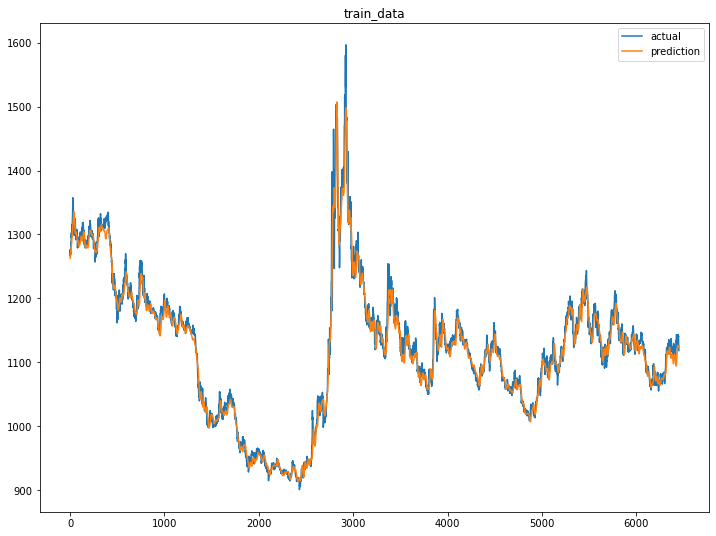

MSE 253.6876402725502
rmse = 15.927574839646812


In [14]:
pred = model.predict(x_train_WINDOW) #예측값(학습)
actual = np.asarray(y_train_WINDOW)

pred = pd.DataFrame(pred,columns = ["예측값"]).apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val)) # 원래 값 복원
actual = pd.DataFrame(actual,columns = ["실제값"]).apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val)) # 예측 값 복원

print(pred.shape, actual.shape)

i = 0
j = len(pred)

plt.figure(figsize=(12, 9))
plt.title('train_data')
plt.plot(actual[i:j], label='actual')
plt.plot(pred[i:j], label='prediction')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MSE",mean_squared_error(actual["실제값"],pred["예측값"]))
rmse = mean_squared_error(actual["실제값"],pred["예측값"], squared=False)
print("rmse = {}".format(rmse))

51/51 [==============================] - 35s 688ms/step
(1613, 1) (1613, 1)


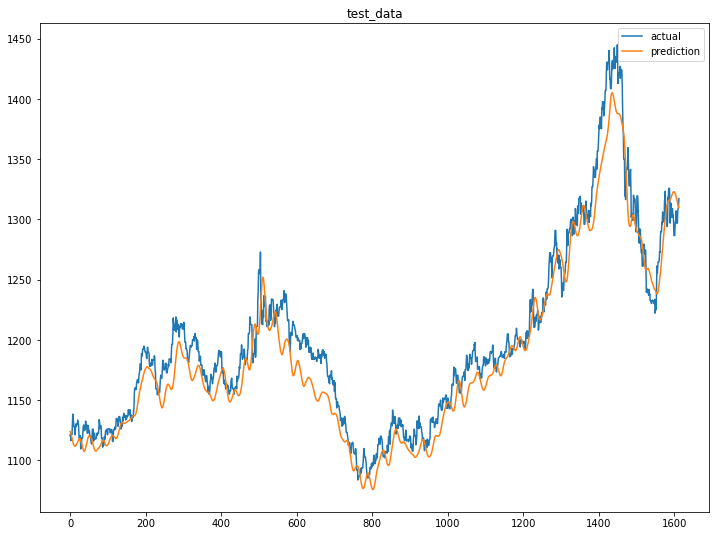

MSE 394.4891310924772
rmse = 19.861750453886916


In [15]:
pred = model.predict(x_test_WINDOW) #예측값(실제)
actual = np.asarray(y_test_WINDOW)

pred = pd.DataFrame(pred,columns = ["예측값"]).apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val)) # 원래 값 복원
actual = pd.DataFrame(actual,columns = ["실제값"]).apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val)) # 예측 값 복원

print(pred.shape, actual.shape)

i = 0
j = len(pred)

plt.figure(figsize=(12, 9))
plt.title('test_data')
plt.plot(actual[i:j], label='actual')
plt.plot(pred[i:j], label='prediction')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MSE",mean_squared_error(actual["실제값"],pred["예측값"]))
rmse = mean_squared_error(actual["실제값"],pred["예측값"], squared=False)
print("rmse = {}".format(rmse))

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [220]:
bin_data = data["bin_data"]
up_data = data["BTC_KRW"]
Usdt_data = data["KRW_USDT"]
####################
up_data = up_data.loc[~(up_data["Open"] == 0)]# 업비트 이상치 제거

data = pd.merge(up_data, Usdt_data, on = "time", how = "left")
data = pd.merge(data, bin_data, on = "time", how = "left") # 업비트 기준으로 맞는 잘짜 데이터끼리만 보여줌.
#################
def set_index(df):
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='raise')
    df = df.set_index('time',drop=True)
    return df

data = set_index(data)

data = pd.DataFrame({"날짜":data.index, 
                    "비트코인한국":data.Open_x.values,
                     "바이낸스USDT(달러)":data.Open.values,
                     "달러환율":data.Open_y.values,
                    })
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율
0,2017-09-26,4201000.0,3928.00,1134.80
1,2017-09-27,4317000.0,3882.36,1137.62
2,2017-09-28,4322000.0,4192.11,1145.75
3,2017-09-29,4657000.0,4178.98,1146.59
4,2017-09-30,4586000.0,4175.00,NaN
...,...,...,...,...
2018,2023-04-06,37207000.0,28170.01,1317.36
2019,2023-04-07,37139000.0,28033.83,1318.99
2020,2023-04-08,37058000.0,27906.34,NaN
2021,2023-04-09,36993000.0,27938.38,NaN


In [221]:
#data["day_of_week"] = data["날짜"].dt.day_of_week
data["달러환율"] = data["달러환율"].fillna(method="ffill")
data = data.dropna() # 바이낸스 오늘 날짜 까지 안받아와졋을 경우에(업비트와 데이터 차이)
data.isna().sum()

날짜              0
비트코인한국          0
바이낸스USDT(달러)    0
달러환율            0
dtype: int64

In [222]:
# 9시인것을 다 뺴버려서 다시 맞추어줌.
data["날짜_2"] = [str(data["날짜"][i])[:-8]+"09:00" for i in range(len(data["날짜"]))]
data["날짜_2"] = pd.to_datetime(data['날짜_2'], format='%Y-%m-%d %H:%M', errors='raise')

# 서버 점검일 or 비트코인 전송 불가일
up_sutdown = [("2018-04-16 20:00", "2018-04-17 00:00"),
            ("2018-04-24 07:59", "2018-04-24 08:30"),
            ("2018-06-15 04:00", "2018-06-15 05:00"),
            ("2018-08-22 02:00", "2018-08-22 07:00"),
            ("2018-10-18 02:00", "2018-10-18 03:00"),
            ("2018-12-05 03:00", "2018-12-05 04:00"),
            ("2018-12-12 03:00", "2018-12-12 04:00"),
            ("2019-01-01 01:00", "2019-01-01 03:00"),
            ("2019-03-20 02:00", "2019-03-20 06:00"),
            ("2019-03-24 03:00", "2019-03-24 04:00"),
            ("2020-01-31 02:00", "2020-01-31 05:00"),
            ("2021-01-07 05:00", "2021-01-07 06:00"),
            ("2021-03-03 03:30", "2021-03-03 06:30"),
            ("2021-03-14 03:00", "2021-03-14 06:00"),
            ("2021-03-23 03:00", "2021-03-23 06:00"),
            ("2021-06-30 23:00", "2021-07-01 03:00"),
            ("2019-10-17 21:00", "2019-10-18 13:00"),
            ("2019-04-10 21:50", "2019-04-17 02:00"),
            ("2019-12-12 23:55", "2019-12-13 03:00"),
            ("2019-12-15 00:00", "2019-12-15 01:00"),
            ("2020-12-29 01:30", "2020-12-29 02:25"),
            ("2020-12-30 19:01", "2021-01-01 05:02"),
            ("2021-06-29 21:01", "2021-07-01 04:51"),
            ("2021-08-17 02:00" , "2021-08-17 06:00") ,
            ("2021-08-26 03:00" , "2021-08-26 05:00") ,
            ("2021-09-30 05:50" , "2021-09-30 06:50") ,
            ("2021-10-05 23:30" , "2021-10-06 00:30") ,
            ("2021-10-12 23:00" , "2021-10-13 02:00") ,
            ("2021-10-19 23:00" , "2021-10-20 02:00") ,
            ("2021-11-15 03:00" , "2021-11-15 06:00") ,
            ("2021-10-19 23:30" , "2021-10-20 00:30") ,
            ("2021-11-15 03:00" , "2021-11-15 06:00") ,
            ("2022-01-01 07:00" , "2022-01-01 05:52") ,
            ("2022-02-14 04:46" , "2022-02-14 04:45") ,
            ("2022-05-11 02:00" , "2022-05-11 05:00") ,
            ("2022-05-24 02:00" , "2022-05-24 04:00") ,
            ("2022-10-01 04:25" , "2022-10-01 05:50") ,
            ("2022-10-15 23:50" , "2022-10-16 01:00") ,
            ("2022-12-31 20:00" , "2023-01-01 07:00") ,
            ("2023-02-22 02:00" , "2023-02-22 06:00") ,
            ("2023-03-31 23:00" , "2023-04-01 07:00") ,
            ("2023-04-01 05:54" , "2023-04-01 06:00") ,
            ("2023-04-03 17:55" , "2023-04-03 17:18") 
#             ("2001-01-02" , "2018-04-10"), # trian 기간 제외
            ("2023-04-07" , "2024-01-01") # LSTM데이터 셋과 타임테이블 맞춤
             ]
# 서버 점검일이 아닌 날짜만 받기
for i in range(len(up_sutdown)):
    data = data.loc[~(data["날짜_2"].between(up_sutdown[i][0],up_sutdown[i][1]))]


C:\Users\Happy\AppData\Local\Temp\ipykernel_23480\1361766116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["날짜_2"] = [str(data["날짜"][i])[:-8]+"09:00" for i in range(len(data["날짜"]))]
C:\Users\Happy\AppData\Local\Temp\ipykernel_23480\1361766116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["날짜_2"] = pd.to_datetime(data['날짜_2'], format='%Y-%m-%d %H:%M', errors='raise')


In [223]:
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율,날짜_2
0,2017-09-26,4201000.0,3928.00,1134.80,2017-09-26 09:00:00
1,2017-09-27,4317000.0,3882.36,1137.62,2017-09-27 09:00:00
2,2017-09-28,4322000.0,4192.11,1145.75,2017-09-28 09:00:00
3,2017-09-29,4657000.0,4178.98,1146.59,2017-09-29 09:00:00
4,2017-09-30,4586000.0,4175.00,1146.59,2017-09-30 09:00:00
...,...,...,...,...,...
2014,2023-04-02,37540000.0,28452.74,1296.97,2023-04-02 09:00:00
2015,2023-04-03,37596000.0,28171.87,1306.47,2023-04-03 09:00:00
2016,2023-04-04,37296000.0,27800.00,1308.76,2023-04-04 09:00:00
2017,2023-04-05,36814000.0,28165.47,1310.54,2023-04-05 09:00:00


In [224]:
# 예측값 컬럼별로 넣기.

ALL_DATA_BY_USE["time"] = ALL_DATA_BY_USE.index
ALL_DATA_BY_USE = ALL_DATA_BY_USE.reset_index(drop = True)


In [225]:
# LSTM 웬만함녀 데이터 불러오기
def inverse_transform_(x):
    x = x * (MAX_val - MIN_val) + MIN_val
    return x

from tqdm import tqdm
vals = []

for i in tqdm(range(len(data))):
    # data 셋의 날짜와 LSTM에서 쓸 값의 날짜의 인덱스를 맞추어가져롬. 그리고 해당 날짜에 맞게 데이터 집어넣음.
    idx = list(ALL_DATA_BY_USE["time"].values).index(data["날짜"].iloc[i]) + 1 # +1 은 ALL_DATA_BY_USE의 컬럼이 0부터 시작하기 떄문
    a = model.predict(x_WINDOW[idx-WINDOW_SIZE-1:idx-WINDOW_SIZE]) 
    a = inverse_transform_(a)
    vals.append(float(a))
    
data["LSTM예측값"] = vals # 빠진날도 있어서 이렇게 해야함..



  0%|                                                                                         | 0/2010 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  0%|                                                                               | 1/2010 [00:02<1:31:44,  2.74s/it]

1/1 [==============================] - 0s 243ms/step


  0%|                                                                                 | 2/2010 [00:03<44:18,  1.32s/it]

1/1 [==============================] - 0s 213ms/step


  0%|                                                                                 | 3/2010 [00:03<28:41,  1.17it/s]

1/1 [==============================] - 0s 213ms/step


  0%|▏                                                                                | 4/2010 [00:03<21:18,  1.57it/s]

1/1 [==============================] - 0s 213ms/step


  0%|▏                                                                                | 5/2010 [00:03<17:04,  1.96it/s]

1/1 [==============================] - 0s 174ms/step


  0%|▏                                                                                | 6/2010 [00:04<13:58,  2.39it/s]

1/1 [==============================] - 0s 243ms/step


  0%|▎                                                                                | 7/2010 [00:04<13:01,  2.56it/s]

1/1 [==============================] - 0s 229ms/step


  0%|▎                                                                                | 8/2010 [00:04<12:15,  2.72it/s]

1/1 [==============================] - 0s 211ms/step


  0%|▎                                                                                | 9/2010 [00:05<11:26,  2.92it/s]

1/1 [==============================] - 0s 210ms/step


  0%|▍                                                                               | 10/2010 [00:05<10:52,  3.06it/s]

1/1 [==============================] - 0s 202ms/step


  1%|▍                                                                               | 11/2010 [00:05<10:23,  3.21it/s]

1/1 [==============================] - 0s 260ms/step


  1%|▍                                                                               | 12/2010 [00:06<10:35,  3.14it/s]

1/1 [==============================] - 0s 235ms/step


  1%|▌                                                                               | 13/2010 [00:06<10:52,  3.06it/s]

1/1 [==============================] - 0s 216ms/step


  1%|▌                                                                               | 14/2010 [00:06<10:30,  3.17it/s]

1/1 [==============================] - 0s 202ms/step


  1%|▌                                                                               | 15/2010 [00:06<10:05,  3.29it/s]

1/1 [==============================] - 0s 212ms/step


  1%|▋                                                                               | 16/2010 [00:07<09:55,  3.35it/s]

1/1 [==============================] - 0s 211ms/step


  1%|▋                                                                               | 17/2010 [00:07<09:45,  3.41it/s]

1/1 [==============================] - 0s 224ms/step


  1%|▋                                                                               | 18/2010 [00:07<09:57,  3.33it/s]

1/1 [==============================] - 0s 166ms/step


  1%|▊                                                                               | 19/2010 [00:08<09:18,  3.57it/s]

1/1 [==============================] - 0s 196ms/step


  1%|▊                                                                               | 20/2010 [00:08<09:06,  3.64it/s]

1/1 [==============================] - 0s 219ms/step


  1%|▊                                                                               | 21/2010 [00:08<09:16,  3.57it/s]

1/1 [==============================] - 0s 205ms/step


  1%|▉                                                                               | 22/2010 [00:08<09:15,  3.58it/s]

1/1 [==============================] - 0s 260ms/step


  1%|▉                                                                               | 23/2010 [00:09<09:54,  3.34it/s]

1/1 [==============================] - 0s 218ms/step


  1%|▉                                                                               | 24/2010 [00:09<09:49,  3.37it/s]

1/1 [==============================] - 0s 244ms/step


  1%|▉                                                                               | 25/2010 [00:09<10:07,  3.27it/s]

1/1 [==============================] - 0s 169ms/step


  1%|█                                                                               | 26/2010 [00:10<09:24,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


  1%|█                                                                               | 27/2010 [00:10<09:16,  3.56it/s]

1/1 [==============================] - 0s 287ms/step


  1%|█                                                                               | 28/2010 [00:10<10:12,  3.23it/s]

1/1 [==============================] - 0s 218ms/step


  1%|█▏                                                                              | 29/2010 [00:11<09:59,  3.31it/s]

1/1 [==============================] - 0s 203ms/step


  1%|█▏                                                                              | 30/2010 [00:11<09:45,  3.38it/s]

1/1 [==============================] - 0s 205ms/step


  2%|█▏                                                                              | 31/2010 [00:11<09:35,  3.44it/s]

1/1 [==============================] - 0s 200ms/step


  2%|█▎                                                                              | 32/2010 [00:11<09:22,  3.51it/s]

1/1 [==============================] - 0s 195ms/step


  2%|█▎                                                                              | 33/2010 [00:12<09:05,  3.62it/s]

1/1 [==============================] - 0s 399ms/step


  2%|█▎                                                                              | 34/2010 [00:12<11:37,  2.83it/s]

1/1 [==============================] - 0s 268ms/step


  2%|█▍                                                                              | 35/2010 [00:13<11:41,  2.82it/s]

1/1 [==============================] - 0s 222ms/step


  2%|█▍                                                                              | 36/2010 [00:13<11:10,  2.94it/s]

1/1 [==============================] - 0s 361ms/step


  2%|█▍                                                                              | 37/2010 [00:13<12:13,  2.69it/s]

1/1 [==============================] - 0s 234ms/step


  2%|█▌                                                                              | 38/2010 [00:14<11:56,  2.75it/s]

1/1 [==============================] - 0s 196ms/step


  2%|█▌                                                                              | 39/2010 [00:14<11:15,  2.92it/s]

1/1 [==============================] - 0s 177ms/step


  2%|█▌                                                                              | 40/2010 [00:14<10:14,  3.21it/s]

1/1 [==============================] - 0s 155ms/step


  2%|█▋                                                                              | 41/2010 [00:14<09:14,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


  2%|█▋                                                                              | 42/2010 [00:15<08:33,  3.83it/s]

1/1 [==============================] - 0s 154ms/step


  2%|█▋                                                                              | 43/2010 [00:15<08:03,  4.07it/s]

1/1 [==============================] - 0s 157ms/step


  2%|█▊                                                                              | 44/2010 [00:15<07:43,  4.24it/s]

1/1 [==============================] - 0s 151ms/step


  2%|█▊                                                                              | 45/2010 [00:15<07:27,  4.39it/s]

1/1 [==============================] - 0s 163ms/step


  2%|█▊                                                                              | 46/2010 [00:15<07:22,  4.43it/s]

1/1 [==============================] - 0s 160ms/step


  2%|█▊                                                                              | 47/2010 [00:16<07:17,  4.49it/s]

1/1 [==============================] - 0s 154ms/step


  2%|█▉                                                                              | 48/2010 [00:16<07:08,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


  2%|█▉                                                                              | 49/2010 [00:16<07:06,  4.59it/s]

1/1 [==============================] - 0s 150ms/step


  2%|█▉                                                                              | 50/2010 [00:16<07:00,  4.67it/s]

1/1 [==============================] - 0s 153ms/step


  3%|██                                                                              | 51/2010 [00:16<06:57,  4.69it/s]

1/1 [==============================] - 0s 155ms/step


  3%|██                                                                              | 52/2010 [00:17<06:54,  4.72it/s]

1/1 [==============================] - 0s 152ms/step


  3%|██                                                                              | 53/2010 [00:17<06:51,  4.76it/s]

1/1 [==============================] - 0s 152ms/step


  3%|██▏                                                                             | 54/2010 [00:17<06:48,  4.79it/s]

1/1 [==============================] - 0s 153ms/step


  3%|██▏                                                                             | 55/2010 [00:17<06:47,  4.79it/s]

1/1 [==============================] - 0s 176ms/step


  3%|██▏                                                                             | 56/2010 [00:18<06:59,  4.65it/s]

1/1 [==============================] - 0s 189ms/step


  3%|██▎                                                                             | 57/2010 [00:18<07:30,  4.34it/s]

1/1 [==============================] - 0s 167ms/step


  3%|██▎                                                                             | 58/2010 [00:18<07:38,  4.26it/s]

1/1 [==============================] - 0s 215ms/step


  3%|██▎                                                                             | 59/2010 [00:18<07:58,  4.08it/s]

1/1 [==============================] - 0s 158ms/step


  3%|██▍                                                                             | 60/2010 [00:19<07:40,  4.23it/s]

1/1 [==============================] - 0s 152ms/step


  3%|██▍                                                                             | 61/2010 [00:19<07:23,  4.39it/s]

1/1 [==============================] - 0s 157ms/step


  3%|██▍                                                                             | 62/2010 [00:19<07:13,  4.50it/s]

1/1 [==============================] - 0s 150ms/step


  3%|██▌                                                                             | 63/2010 [00:19<07:02,  4.61it/s]

1/1 [==============================] - 0s 159ms/step


  3%|██▌                                                                             | 64/2010 [00:19<07:00,  4.63it/s]

1/1 [==============================] - 0s 163ms/step


  3%|██▌                                                                             | 65/2010 [00:20<07:00,  4.63it/s]

1/1 [==============================] - 0s 158ms/step


  3%|██▋                                                                             | 66/2010 [00:20<06:57,  4.66it/s]

1/1 [==============================] - 0s 150ms/step


  3%|██▋                                                                             | 67/2010 [00:20<06:50,  4.74it/s]

1/1 [==============================] - 0s 149ms/step


  3%|██▋                                                                             | 68/2010 [00:20<06:44,  4.80it/s]

1/1 [==============================] - 0s 146ms/step


  3%|██▋                                                                             | 69/2010 [00:20<06:36,  4.89it/s]

1/1 [==============================] - 0s 148ms/step


  3%|██▊                                                                             | 70/2010 [00:21<06:33,  4.93it/s]

1/1 [==============================] - 0s 145ms/step


  4%|██▊                                                                             | 71/2010 [00:21<06:29,  4.98it/s]

1/1 [==============================] - 0s 147ms/step


  4%|██▊                                                                             | 72/2010 [00:21<06:27,  5.00it/s]

1/1 [==============================] - 0s 150ms/step


  4%|██▉                                                                             | 73/2010 [00:21<06:29,  4.97it/s]

1/1 [==============================] - 0s 147ms/step


  4%|██▉                                                                             | 74/2010 [00:21<06:27,  4.99it/s]

1/1 [==============================] - 0s 190ms/step


  4%|██▉                                                                             | 75/2010 [00:22<06:51,  4.70it/s]

1/1 [==============================] - 0s 153ms/step


  4%|███                                                                             | 76/2010 [00:22<06:47,  4.75it/s]

1/1 [==============================] - 0s 160ms/step


  4%|███                                                                             | 77/2010 [00:22<06:48,  4.73it/s]

1/1 [==============================] - 0s 155ms/step


  4%|███                                                                             | 78/2010 [00:22<06:46,  4.75it/s]

1/1 [==============================] - 0s 147ms/step


  4%|███▏                                                                            | 79/2010 [00:22<06:39,  4.83it/s]

1/1 [==============================] - 0s 145ms/step


  4%|███▏                                                                            | 80/2010 [00:23<06:32,  4.92it/s]

1/1 [==============================] - 0s 144ms/step


  4%|███▏                                                                            | 81/2010 [00:23<06:27,  4.98it/s]

1/1 [==============================] - 0s 145ms/step


  4%|███▎                                                                            | 82/2010 [00:23<06:25,  5.01it/s]

1/1 [==============================] - 0s 142ms/step


  4%|███▎                                                                            | 83/2010 [00:23<06:32,  4.91it/s]

1/1 [==============================] - 0s 144ms/step


  4%|███▎                                                                            | 84/2010 [00:23<06:27,  4.97it/s]

1/1 [==============================] - 0s 145ms/step


  4%|███▍                                                                            | 85/2010 [00:24<06:24,  5.00it/s]

1/1 [==============================] - 0s 142ms/step


  4%|███▍                                                                            | 86/2010 [00:24<06:21,  5.05it/s]

1/1 [==============================] - 0s 146ms/step


  4%|███▍                                                                            | 87/2010 [00:24<06:20,  5.06it/s]

1/1 [==============================] - 0s 144ms/step


  4%|███▌                                                                            | 88/2010 [00:24<06:19,  5.06it/s]

1/1 [==============================] - 0s 146ms/step


  4%|███▌                                                                            | 89/2010 [00:24<06:18,  5.08it/s]

1/1 [==============================] - 0s 144ms/step


  4%|███▌                                                                            | 90/2010 [00:25<06:16,  5.10it/s]

1/1 [==============================] - 0s 148ms/step


  5%|███▌                                                                            | 91/2010 [00:25<06:20,  5.05it/s]

1/1 [==============================] - 0s 149ms/step


  5%|███▋                                                                            | 92/2010 [00:25<06:21,  5.03it/s]

1/1 [==============================] - 0s 143ms/step


  5%|███▋                                                                            | 93/2010 [00:25<06:18,  5.07it/s]

1/1 [==============================] - 0s 144ms/step


  5%|███▋                                                                            | 94/2010 [00:25<06:17,  5.08it/s]

1/1 [==============================] - 0s 145ms/step


  5%|███▊                                                                            | 95/2010 [00:26<06:16,  5.08it/s]

1/1 [==============================] - 0s 157ms/step


  5%|███▊                                                                            | 96/2010 [00:26<06:22,  5.00it/s]

1/1 [==============================] - 0s 155ms/step


  5%|███▊                                                                            | 97/2010 [00:26<06:28,  4.93it/s]

1/1 [==============================] - 0s 153ms/step


  5%|███▉                                                                            | 98/2010 [00:26<06:28,  4.92it/s]

1/1 [==============================] - 0s 144ms/step


  5%|███▉                                                                            | 99/2010 [00:26<06:23,  4.98it/s]

1/1 [==============================] - 0s 145ms/step


  5%|███▉                                                                           | 100/2010 [00:27<06:22,  5.00it/s]

1/1 [==============================] - 0s 145ms/step


  5%|███▉                                                                           | 101/2010 [00:27<06:19,  5.03it/s]

1/1 [==============================] - 0s 150ms/step


  5%|████                                                                           | 102/2010 [00:27<06:31,  4.88it/s]

1/1 [==============================] - 0s 152ms/step


  5%|████                                                                           | 103/2010 [00:27<06:32,  4.86it/s]

1/1 [==============================] - 0s 153ms/step


  5%|████                                                                           | 104/2010 [00:27<06:43,  4.73it/s]

1/1 [==============================] - 0s 144ms/step


  5%|████▏                                                                          | 105/2010 [00:28<06:44,  4.71it/s]

1/1 [==============================] - 0s 158ms/step


  5%|████▏                                                                          | 106/2010 [00:28<06:43,  4.72it/s]

1/1 [==============================] - 0s 144ms/step


  5%|████▏                                                                          | 107/2010 [00:28<06:44,  4.70it/s]

1/1 [==============================] - 0s 144ms/step


  5%|████▏                                                                          | 108/2010 [00:28<06:36,  4.79it/s]

1/1 [==============================] - 0s 143ms/step


  5%|████▎                                                                          | 109/2010 [00:29<06:30,  4.87it/s]

1/1 [==============================] - 0s 144ms/step


  5%|████▎                                                                          | 110/2010 [00:29<06:25,  4.93it/s]

1/1 [==============================] - 0s 143ms/step


  6%|████▎                                                                          | 111/2010 [00:29<06:19,  5.00it/s]

1/1 [==============================] - 0s 144ms/step


  6%|████▍                                                                          | 112/2010 [00:29<06:18,  5.02it/s]

1/1 [==============================] - 0s 143ms/step


  6%|████▍                                                                          | 113/2010 [00:29<06:15,  5.05it/s]

1/1 [==============================] - 0s 144ms/step


  6%|████▍                                                                          | 114/2010 [00:29<06:14,  5.06it/s]

1/1 [==============================] - 0s 145ms/step


  6%|████▌                                                                          | 115/2010 [00:30<06:15,  5.05it/s]

1/1 [==============================] - 0s 157ms/step


  6%|████▌                                                                          | 116/2010 [00:30<06:25,  4.91it/s]

1/1 [==============================] - 0s 156ms/step


  6%|████▌                                                                          | 117/2010 [00:30<06:28,  4.87it/s]

1/1 [==============================] - 0s 146ms/step


  6%|████▋                                                                          | 118/2010 [00:30<06:26,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


  6%|████▋                                                                          | 119/2010 [00:31<06:19,  4.98it/s]

1/1 [==============================] - 0s 144ms/step


  6%|████▋                                                                          | 120/2010 [00:31<06:16,  5.02it/s]

1/1 [==============================] - 0s 155ms/step


  6%|████▊                                                                          | 121/2010 [00:31<06:20,  4.96it/s]

1/1 [==============================] - 0s 148ms/step


  6%|████▊                                                                          | 122/2010 [00:31<06:22,  4.94it/s]

1/1 [==============================] - 0s 206ms/step


  6%|████▊                                                                          | 123/2010 [00:31<07:02,  4.47it/s]

1/1 [==============================] - 0s 215ms/step


  6%|████▊                                                                          | 124/2010 [00:32<07:35,  4.14it/s]

1/1 [==============================] - 0s 181ms/step


  6%|████▉                                                                          | 125/2010 [00:32<07:36,  4.13it/s]

1/1 [==============================] - 0s 144ms/step


  6%|████▉                                                                          | 126/2010 [00:32<07:09,  4.39it/s]

1/1 [==============================] - 0s 147ms/step


  6%|████▉                                                                          | 127/2010 [00:32<06:57,  4.51it/s]

1/1 [==============================] - 0s 171ms/step


  6%|█████                                                                          | 128/2010 [00:33<06:58,  4.50it/s]

1/1 [==============================] - 0s 198ms/step


  6%|█████                                                                          | 129/2010 [00:33<07:16,  4.30it/s]

1/1 [==============================] - 0s 193ms/step


  6%|█████                                                                          | 130/2010 [00:33<07:28,  4.19it/s]

1/1 [==============================] - 0s 216ms/step


  7%|█████▏                                                                         | 131/2010 [00:33<07:47,  4.02it/s]

1/1 [==============================] - 0s 220ms/step


  7%|█████▏                                                                         | 132/2010 [00:34<08:10,  3.83it/s]

1/1 [==============================] - 0s 207ms/step


  7%|█████▏                                                                         | 133/2010 [00:34<08:17,  3.77it/s]

1/1 [==============================] - 0s 223ms/step


  7%|█████▎                                                                         | 134/2010 [00:34<08:31,  3.67it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▎                                                                         | 135/2010 [00:34<08:23,  3.72it/s]

1/1 [==============================] - 0s 221ms/step


  7%|█████▎                                                                         | 136/2010 [00:35<08:40,  3.60it/s]

1/1 [==============================] - 0s 196ms/step


  7%|█████▍                                                                         | 137/2010 [00:35<08:29,  3.68it/s]

1/1 [==============================] - 0s 158ms/step


  7%|█████▍                                                                         | 138/2010 [00:35<07:56,  3.93it/s]

1/1 [==============================] - 0s 214ms/step


  7%|█████▍                                                                         | 139/2010 [00:36<08:25,  3.70it/s]

1/1 [==============================] - 0s 177ms/step


  7%|█████▌                                                                         | 140/2010 [00:36<08:11,  3.81it/s]

1/1 [==============================] - 0s 154ms/step


  7%|█████▌                                                                         | 141/2010 [00:36<07:37,  4.08it/s]

1/1 [==============================] - 0s 166ms/step


  7%|█████▌                                                                         | 142/2010 [00:36<07:23,  4.22it/s]

1/1 [==============================] - 0s 179ms/step


  7%|█████▌                                                                         | 143/2010 [00:36<07:29,  4.15it/s]

1/1 [==============================] - 0s 247ms/step


  7%|█████▋                                                                         | 144/2010 [00:37<08:32,  3.64it/s]

1/1 [==============================] - 0s 187ms/step


  7%|█████▋                                                                         | 145/2010 [00:37<08:17,  3.75it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▋                                                                         | 146/2010 [00:37<07:54,  3.93it/s]

1/1 [==============================] - 0s 162ms/step


  7%|█████▊                                                                         | 147/2010 [00:37<07:35,  4.09it/s]

1/1 [==============================] - 0s 147ms/step


  7%|█████▊                                                                         | 148/2010 [00:38<07:10,  4.32it/s]

1/1 [==============================] - 0s 163ms/step


  7%|█████▊                                                                         | 149/2010 [00:38<07:03,  4.39it/s]

1/1 [==============================] - 0s 162ms/step


  7%|█████▉                                                                         | 150/2010 [00:38<06:57,  4.45it/s]

1/1 [==============================] - 0s 147ms/step


  8%|█████▉                                                                         | 151/2010 [00:38<06:45,  4.58it/s]

1/1 [==============================] - 0s 146ms/step


  8%|█████▉                                                                         | 152/2010 [00:39<06:36,  4.69it/s]

1/1 [==============================] - 0s 148ms/step


  8%|██████                                                                         | 153/2010 [00:39<06:38,  4.66it/s]

1/1 [==============================] - 0s 145ms/step


  8%|██████                                                                         | 154/2010 [00:39<06:28,  4.78it/s]

1/1 [==============================] - 0s 143ms/step


  8%|██████                                                                         | 155/2010 [00:39<06:21,  4.86it/s]

1/1 [==============================] - 0s 152ms/step


  8%|██████▏                                                                        | 156/2010 [00:39<06:19,  4.88it/s]

1/1 [==============================] - 0s 144ms/step


  8%|██████▏                                                                        | 157/2010 [00:40<06:15,  4.94it/s]

1/1 [==============================] - 0s 142ms/step


  8%|██████▏                                                                        | 158/2010 [00:40<06:08,  5.02it/s]

1/1 [==============================] - 0s 149ms/step


  8%|██████▏                                                                        | 159/2010 [00:40<06:10,  5.00it/s]

1/1 [==============================] - 0s 145ms/step


  8%|██████▎                                                                        | 160/2010 [00:40<06:08,  5.02it/s]

1/1 [==============================] - 0s 144ms/step


  8%|██████▎                                                                        | 161/2010 [00:40<06:05,  5.06it/s]

1/1 [==============================] - 0s 148ms/step


  8%|██████▎                                                                        | 162/2010 [00:41<06:08,  5.01it/s]

1/1 [==============================] - 0s 160ms/step


  8%|██████▍                                                                        | 163/2010 [00:41<06:16,  4.91it/s]

1/1 [==============================] - 0s 146ms/step


  8%|██████▍                                                                        | 164/2010 [00:41<06:11,  4.96it/s]

1/1 [==============================] - 0s 143ms/step


  8%|██████▍                                                                        | 165/2010 [00:41<06:07,  5.02it/s]

1/1 [==============================] - 0s 143ms/step


  8%|██████▌                                                                        | 166/2010 [00:41<06:05,  5.05it/s]

1/1 [==============================] - 0s 145ms/step


  8%|██████▌                                                                        | 167/2010 [00:42<06:02,  5.08it/s]

1/1 [==============================] - 0s 187ms/step


  8%|██████▌                                                                        | 168/2010 [00:42<06:26,  4.77it/s]

1/1 [==============================] - 0s 158ms/step


  8%|██████▋                                                                        | 169/2010 [00:42<06:36,  4.65it/s]

1/1 [==============================] - 0s 155ms/step


  8%|██████▋                                                                        | 170/2010 [00:42<06:32,  4.69it/s]

1/1 [==============================] - 0s 144ms/step


  9%|██████▋                                                                        | 171/2010 [00:42<06:22,  4.81it/s]

1/1 [==============================] - 0s 158ms/step


  9%|██████▊                                                                        | 172/2010 [00:43<06:22,  4.80it/s]

1/1 [==============================] - 0s 175ms/step


  9%|██████▊                                                                        | 173/2010 [00:43<06:49,  4.49it/s]

1/1 [==============================] - 0s 149ms/step


  9%|██████▊                                                                        | 174/2010 [00:43<06:38,  4.61it/s]

1/1 [==============================] - 0s 153ms/step


  9%|██████▉                                                                        | 175/2010 [00:43<06:31,  4.69it/s]

1/1 [==============================] - 0s 176ms/step


  9%|██████▉                                                                        | 176/2010 [00:43<06:40,  4.58it/s]

1/1 [==============================] - 0s 161ms/step


  9%|██████▉                                                                        | 177/2010 [00:44<06:50,  4.46it/s]

1/1 [==============================] - 0s 165ms/step


  9%|██████▉                                                                        | 178/2010 [00:44<06:46,  4.50it/s]

1/1 [==============================] - 0s 158ms/step


  9%|███████                                                                        | 179/2010 [00:44<06:45,  4.52it/s]

1/1 [==============================] - 0s 160ms/step


  9%|███████                                                                        | 180/2010 [00:44<06:53,  4.42it/s]

1/1 [==============================] - 0s 179ms/step


  9%|███████                                                                        | 181/2010 [00:45<06:56,  4.39it/s]

1/1 [==============================] - 0s 200ms/step


  9%|███████▏                                                                       | 182/2010 [00:45<07:14,  4.21it/s]

1/1 [==============================] - 0s 161ms/step


  9%|███████▏                                                                       | 183/2010 [00:45<07:04,  4.30it/s]

1/1 [==============================] - 0s 196ms/step


  9%|███████▏                                                                       | 184/2010 [00:45<07:27,  4.08it/s]

1/1 [==============================] - 0s 169ms/step


  9%|███████▎                                                                       | 185/2010 [00:46<07:15,  4.19it/s]

1/1 [==============================] - 0s 179ms/step


  9%|███████▎                                                                       | 186/2010 [00:46<07:13,  4.21it/s]

1/1 [==============================] - 0s 166ms/step


  9%|███████▎                                                                       | 187/2010 [00:46<07:06,  4.27it/s]

1/1 [==============================] - 0s 167ms/step


  9%|███████▍                                                                       | 188/2010 [00:46<07:00,  4.33it/s]

1/1 [==============================] - 0s 179ms/step


  9%|███████▍                                                                       | 189/2010 [00:47<07:04,  4.29it/s]

1/1 [==============================] - 0s 191ms/step


  9%|███████▍                                                                       | 190/2010 [00:47<07:11,  4.22it/s]

1/1 [==============================] - 0s 179ms/step


 10%|███████▌                                                                       | 191/2010 [00:47<07:11,  4.22it/s]

1/1 [==============================] - 0s 147ms/step


 10%|███████▌                                                                       | 192/2010 [00:47<06:51,  4.42it/s]

1/1 [==============================] - 0s 144ms/step


 10%|███████▌                                                                       | 193/2010 [00:47<06:34,  4.60it/s]

1/1 [==============================] - 0s 167ms/step


 10%|███████▌                                                                       | 194/2010 [00:48<06:35,  4.59it/s]

1/1 [==============================] - 0s 176ms/step


 10%|███████▋                                                                       | 195/2010 [00:48<06:42,  4.51it/s]

1/1 [==============================] - 0s 171ms/step


 10%|███████▋                                                                       | 196/2010 [00:48<06:46,  4.46it/s]

1/1 [==============================] - 0s 163ms/step


 10%|███████▋                                                                       | 197/2010 [00:48<06:47,  4.45it/s]

1/1 [==============================] - 0s 160ms/step


 10%|███████▊                                                                       | 198/2010 [00:49<06:39,  4.54it/s]

1/1 [==============================] - 0s 161ms/step


 10%|███████▊                                                                       | 199/2010 [00:49<06:46,  4.45it/s]

1/1 [==============================] - 0s 147ms/step


 10%|███████▊                                                                       | 200/2010 [00:49<06:34,  4.59it/s]

1/1 [==============================] - 0s 148ms/step


 10%|███████▉                                                                       | 201/2010 [00:49<06:25,  4.69it/s]

1/1 [==============================] - 0s 151ms/step


 10%|███████▉                                                                       | 202/2010 [00:49<06:20,  4.75it/s]

1/1 [==============================] - 0s 157ms/step


 10%|███████▉                                                                       | 203/2010 [00:50<06:19,  4.76it/s]

1/1 [==============================] - 0s 153ms/step


 10%|████████                                                                       | 204/2010 [00:50<06:15,  4.81it/s]

1/1 [==============================] - 0s 163ms/step


 10%|████████                                                                       | 205/2010 [00:50<06:23,  4.71it/s]

1/1 [==============================] - 0s 156ms/step


 10%|████████                                                                       | 206/2010 [00:50<06:24,  4.69it/s]

1/1 [==============================] - 0s 175ms/step


 10%|████████▏                                                                      | 207/2010 [00:50<06:34,  4.57it/s]

1/1 [==============================] - 0s 167ms/step


 10%|████████▏                                                                      | 208/2010 [00:51<06:37,  4.53it/s]

1/1 [==============================] - 0s 182ms/step


 10%|████████▏                                                                      | 209/2010 [00:51<06:48,  4.41it/s]

1/1 [==============================] - 0s 161ms/step


 10%|████████▎                                                                      | 210/2010 [00:51<06:40,  4.50it/s]

1/1 [==============================] - 0s 167ms/step


 10%|████████▎                                                                      | 211/2010 [00:51<06:52,  4.36it/s]

1/1 [==============================] - 0s 176ms/step


 11%|████████▎                                                                      | 212/2010 [00:52<06:54,  4.34it/s]

1/1 [==============================] - 0s 167ms/step


 11%|████████▎                                                                      | 213/2010 [00:52<06:50,  4.38it/s]

1/1 [==============================] - 0s 179ms/step


 11%|████████▍                                                                      | 214/2010 [00:52<06:51,  4.36it/s]

1/1 [==============================] - 0s 150ms/step


 11%|████████▍                                                                      | 215/2010 [00:52<06:38,  4.50it/s]

1/1 [==============================] - 0s 145ms/step


 11%|████████▍                                                                      | 216/2010 [00:52<06:26,  4.65it/s]

1/1 [==============================] - 0s 143ms/step


 11%|████████▌                                                                      | 217/2010 [00:53<06:26,  4.64it/s]

1/1 [==============================] - 0s 152ms/step


 11%|████████▌                                                                      | 218/2010 [00:53<06:19,  4.72it/s]

1/1 [==============================] - 0s 174ms/step


 11%|████████▌                                                                      | 219/2010 [00:53<06:31,  4.57it/s]

1/1 [==============================] - 0s 144ms/step


 11%|████████▋                                                                      | 220/2010 [00:53<06:19,  4.72it/s]

1/1 [==============================] - 0s 142ms/step


 11%|████████▋                                                                      | 221/2010 [00:54<06:10,  4.82it/s]

1/1 [==============================] - 0s 149ms/step


 11%|████████▋                                                                      | 222/2010 [00:54<06:07,  4.87it/s]

1/1 [==============================] - 0s 156ms/step


 11%|████████▊                                                                      | 223/2010 [00:54<06:09,  4.84it/s]

1/1 [==============================] - 0s 163ms/step


 11%|████████▊                                                                      | 224/2010 [00:54<06:14,  4.76it/s]

1/1 [==============================] - 0s 145ms/step


 11%|████████▊                                                                      | 225/2010 [00:54<06:08,  4.84it/s]

1/1 [==============================] - 0s 143ms/step


 11%|████████▉                                                                      | 226/2010 [00:55<06:03,  4.91it/s]

1/1 [==============================] - 0s 145ms/step


 11%|████████▉                                                                      | 227/2010 [00:55<05:59,  4.97it/s]

1/1 [==============================] - 0s 149ms/step


 11%|████████▉                                                                      | 228/2010 [00:55<05:58,  4.97it/s]

1/1 [==============================] - 0s 150ms/step


 11%|█████████                                                                      | 229/2010 [00:55<06:00,  4.94it/s]

1/1 [==============================] - 0s 144ms/step


 11%|█████████                                                                      | 230/2010 [00:55<05:56,  4.99it/s]

1/1 [==============================] - 0s 147ms/step


 11%|█████████                                                                      | 231/2010 [00:56<05:58,  4.96it/s]

1/1 [==============================] - 0s 144ms/step


 12%|█████████                                                                      | 232/2010 [00:56<05:55,  5.01it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█████████▏                                                                     | 233/2010 [00:56<05:57,  4.96it/s]

1/1 [==============================] - 0s 169ms/step


 12%|█████████▏                                                                     | 234/2010 [00:56<06:07,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


 12%|█████████▏                                                                     | 235/2010 [00:56<06:04,  4.87it/s]

1/1 [==============================] - 0s 145ms/step


 12%|█████████▎                                                                     | 236/2010 [00:57<06:00,  4.92it/s]

1/1 [==============================] - 0s 147ms/step


 12%|█████████▎                                                                     | 237/2010 [00:57<05:58,  4.95it/s]

1/1 [==============================] - 0s 149ms/step


 12%|█████████▎                                                                     | 238/2010 [00:57<05:58,  4.94it/s]

1/1 [==============================] - 0s 145ms/step


 12%|█████████▍                                                                     | 239/2010 [00:57<05:55,  4.98it/s]

1/1 [==============================] - 0s 144ms/step


 12%|█████████▍                                                                     | 240/2010 [00:57<05:51,  5.03it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█████████▍                                                                     | 241/2010 [00:58<05:56,  4.97it/s]

1/1 [==============================] - 0s 150ms/step


 12%|█████████▌                                                                     | 242/2010 [00:58<05:57,  4.95it/s]

1/1 [==============================] - 0s 161ms/step


 12%|█████████▌                                                                     | 243/2010 [00:58<06:05,  4.84it/s]

1/1 [==============================] - 0s 162ms/step


 12%|█████████▌                                                                     | 244/2010 [00:58<06:10,  4.76it/s]

1/1 [==============================] - 0s 144ms/step


 12%|█████████▋                                                                     | 245/2010 [00:58<06:03,  4.85it/s]

1/1 [==============================] - 0s 145ms/step


 12%|█████████▋                                                                     | 246/2010 [00:59<05:58,  4.92it/s]

1/1 [==============================] - 0s 143ms/step


 12%|█████████▋                                                                     | 247/2010 [00:59<05:54,  4.98it/s]

1/1 [==============================] - 0s 148ms/step


 12%|█████████▋                                                                     | 248/2010 [00:59<05:53,  4.99it/s]

1/1 [==============================] - 0s 147ms/step


 12%|█████████▊                                                                     | 249/2010 [00:59<05:52,  5.00it/s]

1/1 [==============================] - 0s 163ms/step


 12%|█████████▊                                                                     | 250/2010 [00:59<06:01,  4.87it/s]

1/1 [==============================] - 0s 158ms/step


 12%|█████████▊                                                                     | 251/2010 [01:00<06:04,  4.83it/s]

1/1 [==============================] - 0s 189ms/step


 13%|█████████▉                                                                     | 252/2010 [01:00<06:27,  4.53it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█████████▉                                                                     | 253/2010 [01:00<06:29,  4.51it/s]

1/1 [==============================] - 0s 149ms/step


 13%|█████████▉                                                                     | 254/2010 [01:00<06:18,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


 13%|██████████                                                                     | 255/2010 [01:01<06:10,  4.74it/s]

1/1 [==============================] - 0s 156ms/step


 13%|██████████                                                                     | 256/2010 [01:01<06:11,  4.72it/s]

1/1 [==============================] - 0s 163ms/step


 13%|██████████                                                                     | 257/2010 [01:01<06:11,  4.72it/s]

1/1 [==============================] - 0s 154ms/step


 13%|██████████▏                                                                    | 258/2010 [01:01<06:09,  4.74it/s]

1/1 [==============================] - 0s 171ms/step


 13%|██████████▏                                                                    | 259/2010 [01:01<06:17,  4.63it/s]

1/1 [==============================] - 0s 151ms/step


 13%|██████████▏                                                                    | 260/2010 [01:02<06:10,  4.73it/s]

1/1 [==============================] - 0s 175ms/step


 13%|██████████▎                                                                    | 261/2010 [01:02<06:20,  4.60it/s]

1/1 [==============================] - 0s 186ms/step


 13%|██████████▎                                                                    | 262/2010 [01:02<06:45,  4.31it/s]

1/1 [==============================] - 0s 154ms/step


 13%|██████████▎                                                                    | 263/2010 [01:02<06:34,  4.43it/s]

1/1 [==============================] - 0s 172ms/step


 13%|██████████▍                                                                    | 264/2010 [01:03<06:38,  4.38it/s]

1/1 [==============================] - 0s 147ms/step


 13%|██████████▍                                                                    | 265/2010 [01:03<06:25,  4.53it/s]

1/1 [==============================] - 0s 145ms/step


 13%|██████████▍                                                                    | 266/2010 [01:03<06:12,  4.68it/s]

1/1 [==============================] - 0s 149ms/step


 13%|██████████▍                                                                    | 267/2010 [01:03<06:15,  4.64it/s]

1/1 [==============================] - 0s 166ms/step


 13%|██████████▌                                                                    | 268/2010 [01:03<06:27,  4.50it/s]

1/1 [==============================] - 0s 145ms/step


 13%|██████████▌                                                                    | 269/2010 [01:04<06:14,  4.64it/s]

1/1 [==============================] - 0s 155ms/step


 13%|██████████▌                                                                    | 270/2010 [01:04<06:10,  4.70it/s]

1/1 [==============================] - 0s 161ms/step


 13%|██████████▋                                                                    | 271/2010 [01:04<06:11,  4.68it/s]

1/1 [==============================] - 0s 169ms/step


 14%|██████████▋                                                                    | 272/2010 [01:04<06:16,  4.62it/s]

1/1 [==============================] - 0s 159ms/step


 14%|██████████▋                                                                    | 273/2010 [01:04<06:16,  4.61it/s]

1/1 [==============================] - 0s 165ms/step


 14%|██████████▊                                                                    | 274/2010 [01:05<06:16,  4.61it/s]

1/1 [==============================] - 0s 166ms/step


 14%|██████████▊                                                                    | 275/2010 [01:05<06:19,  4.57it/s]

1/1 [==============================] - 0s 155ms/step


 14%|██████████▊                                                                    | 276/2010 [01:05<06:15,  4.62it/s]

1/1 [==============================] - 0s 177ms/step


 14%|██████████▉                                                                    | 277/2010 [01:05<06:38,  4.35it/s]

1/1 [==============================] - 0s 182ms/step


 14%|██████████▉                                                                    | 278/2010 [01:06<06:43,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


 14%|██████████▉                                                                    | 279/2010 [01:06<07:03,  4.09it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████                                                                    | 280/2010 [01:06<07:04,  4.08it/s]

1/1 [==============================] - 0s 168ms/step


 14%|███████████                                                                    | 281/2010 [01:06<06:56,  4.16it/s]

1/1 [==============================] - 0s 159ms/step


 14%|███████████                                                                    | 282/2010 [01:07<06:45,  4.26it/s]

1/1 [==============================] - 0s 145ms/step


 14%|███████████                                                                    | 283/2010 [01:07<06:29,  4.44it/s]

1/1 [==============================] - 0s 147ms/step


 14%|███████████▏                                                                   | 284/2010 [01:07<06:15,  4.60it/s]

1/1 [==============================] - 0s 145ms/step


 14%|███████████▏                                                                   | 285/2010 [01:07<06:04,  4.74it/s]

1/1 [==============================] - 0s 147ms/step


 14%|███████████▏                                                                   | 286/2010 [01:07<05:58,  4.81it/s]

1/1 [==============================] - 0s 144ms/step


 14%|███████████▎                                                                   | 287/2010 [01:08<05:52,  4.88it/s]

1/1 [==============================] - 0s 144ms/step


 14%|███████████▎                                                                   | 288/2010 [01:08<05:48,  4.94it/s]

1/1 [==============================] - 0s 153ms/step


 14%|███████████▎                                                                   | 289/2010 [01:08<05:51,  4.90it/s]

1/1 [==============================] - 0s 144ms/step


 14%|███████████▍                                                                   | 290/2010 [01:08<05:46,  4.97it/s]

1/1 [==============================] - 0s 146ms/step


 14%|███████████▍                                                                   | 291/2010 [01:08<05:43,  5.00it/s]

1/1 [==============================] - 0s 141ms/step


 15%|███████████▍                                                                   | 292/2010 [01:09<05:39,  5.05it/s]

1/1 [==============================] - 0s 164ms/step


 15%|███████████▌                                                                   | 293/2010 [01:09<05:58,  4.80it/s]

1/1 [==============================] - 0s 153ms/step


 15%|███████████▌                                                                   | 294/2010 [01:09<05:55,  4.82it/s]

1/1 [==============================] - 0s 147ms/step


 15%|███████████▌                                                                   | 295/2010 [01:09<05:51,  4.88it/s]

1/1 [==============================] - 0s 147ms/step


 15%|███████████▋                                                                   | 296/2010 [01:09<05:47,  4.94it/s]

1/1 [==============================] - 0s 143ms/step


 15%|███████████▋                                                                   | 297/2010 [01:10<05:42,  5.00it/s]

1/1 [==============================] - 0s 152ms/step


 15%|███████████▋                                                                   | 298/2010 [01:10<05:45,  4.96it/s]

1/1 [==============================] - 0s 162ms/step


 15%|███████████▊                                                                   | 299/2010 [01:10<05:52,  4.86it/s]

1/1 [==============================] - 0s 160ms/step


 15%|███████████▊                                                                   | 300/2010 [01:10<06:05,  4.68it/s]

1/1 [==============================] - 0s 148ms/step


 15%|███████████▊                                                                   | 301/2010 [01:10<05:59,  4.75it/s]

1/1 [==============================] - 0s 147ms/step


 15%|███████████▊                                                                   | 302/2010 [01:11<05:53,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


 15%|███████████▉                                                                   | 303/2010 [01:11<05:47,  4.92it/s]

1/1 [==============================] - 0s 145ms/step


 15%|███████████▉                                                                   | 304/2010 [01:11<05:57,  4.77it/s]

1/1 [==============================] - 0s 161ms/step


 15%|███████████▉                                                                   | 305/2010 [01:11<05:59,  4.75it/s]

1/1 [==============================] - 0s 171ms/step


 15%|████████████                                                                   | 306/2010 [01:11<06:08,  4.63it/s]

1/1 [==============================] - 0s 149ms/step


 15%|████████████                                                                   | 307/2010 [01:12<06:01,  4.72it/s]

1/1 [==============================] - 0s 181ms/step


 15%|████████████                                                                   | 308/2010 [01:12<06:13,  4.55it/s]

1/1 [==============================] - 0s 178ms/step


 15%|████████████▏                                                                  | 309/2010 [01:12<06:21,  4.46it/s]

1/1 [==============================] - 0s 162ms/step


 15%|████████████▏                                                                  | 310/2010 [01:13<08:46,  3.23it/s]

1/1 [==============================] - 0s 160ms/step


 15%|████████████▏                                                                  | 311/2010 [01:13<08:00,  3.54it/s]

1/1 [==============================] - 0s 185ms/step


 16%|████████████▎                                                                  | 312/2010 [01:13<07:37,  3.71it/s]

1/1 [==============================] - 0s 172ms/step


 16%|████████████▎                                                                  | 313/2010 [01:13<07:18,  3.87it/s]

1/1 [==============================] - 0s 162ms/step


 16%|████████████▎                                                                  | 314/2010 [01:14<07:00,  4.03it/s]

1/1 [==============================] - 0s 149ms/step


 16%|████████████▍                                                                  | 315/2010 [01:14<06:36,  4.28it/s]

1/1 [==============================] - 0s 171ms/step


 16%|████████████▍                                                                  | 316/2010 [01:14<06:34,  4.29it/s]

1/1 [==============================] - 0s 174ms/step


 16%|████████████▍                                                                  | 317/2010 [01:14<06:31,  4.33it/s]

1/1 [==============================] - 0s 144ms/step


 16%|████████████▍                                                                  | 318/2010 [01:14<06:13,  4.53it/s]

1/1 [==============================] - 0s 144ms/step


 16%|████████████▌                                                                  | 319/2010 [01:15<06:01,  4.68it/s]

1/1 [==============================] - 0s 141ms/step


 16%|████████████▌                                                                  | 320/2010 [01:15<05:51,  4.81it/s]

1/1 [==============================] - 0s 158ms/step


 16%|████████████▌                                                                  | 321/2010 [01:15<05:51,  4.80it/s]

1/1 [==============================] - 0s 144ms/step


 16%|████████████▋                                                                  | 322/2010 [01:15<05:47,  4.86it/s]

1/1 [==============================] - 0s 142ms/step


 16%|████████████▋                                                                  | 323/2010 [01:15<05:41,  4.95it/s]

1/1 [==============================] - 0s 148ms/step


 16%|████████████▋                                                                  | 324/2010 [01:16<05:40,  4.95it/s]

1/1 [==============================] - 0s 144ms/step


 16%|████████████▊                                                                  | 325/2010 [01:16<05:38,  4.97it/s]

1/1 [==============================] - 0s 151ms/step


 16%|████████████▊                                                                  | 326/2010 [01:16<05:39,  4.96it/s]

1/1 [==============================] - 0s 143ms/step


 16%|████████████▊                                                                  | 327/2010 [01:16<05:35,  5.02it/s]

1/1 [==============================] - 0s 155ms/step


 16%|████████████▉                                                                  | 328/2010 [01:16<05:43,  4.90it/s]

1/1 [==============================] - 0s 144ms/step


 16%|████████████▉                                                                  | 329/2010 [01:17<05:39,  4.96it/s]

1/1 [==============================] - 0s 150ms/step


 16%|████████████▉                                                                  | 330/2010 [01:17<05:42,  4.91it/s]

1/1 [==============================] - 0s 150ms/step


 16%|█████████████                                                                  | 331/2010 [01:17<05:42,  4.90it/s]

1/1 [==============================] - 0s 145ms/step


 17%|█████████████                                                                  | 332/2010 [01:17<05:40,  4.93it/s]

1/1 [==============================] - 0s 145ms/step


 17%|█████████████                                                                  | 333/2010 [01:17<05:35,  5.00it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█████████████▏                                                                 | 334/2010 [01:18<05:42,  4.89it/s]

1/1 [==============================] - 0s 169ms/step


 17%|█████████████▏                                                                 | 335/2010 [01:18<05:54,  4.72it/s]

1/1 [==============================] - 0s 198ms/step


 17%|█████████████▏                                                                 | 336/2010 [01:18<06:17,  4.44it/s]

1/1 [==============================] - 0s 151ms/step


 17%|█████████████▏                                                                 | 337/2010 [01:18<06:08,  4.54it/s]

1/1 [==============================] - 0s 168ms/step


 17%|█████████████▎                                                                 | 338/2010 [01:19<06:08,  4.54it/s]

1/1 [==============================] - 0s 179ms/step


 17%|█████████████▎                                                                 | 339/2010 [01:19<06:17,  4.43it/s]

1/1 [==============================] - 0s 158ms/step


 17%|█████████████▎                                                                 | 340/2010 [01:19<06:12,  4.48it/s]

1/1 [==============================] - 0s 160ms/step


 17%|█████████████▍                                                                 | 341/2010 [01:19<06:08,  4.53it/s]

1/1 [==============================] - 0s 146ms/step


 17%|█████████████▍                                                                 | 342/2010 [01:19<05:57,  4.66it/s]

1/1 [==============================] - 0s 145ms/step


 17%|█████████████▍                                                                 | 343/2010 [01:20<05:49,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


 17%|█████████████▌                                                                 | 344/2010 [01:20<05:42,  4.87it/s]

1/1 [==============================] - 0s 149ms/step


 17%|█████████████▌                                                                 | 345/2010 [01:20<05:39,  4.90it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▌                                                                 | 346/2010 [01:20<05:34,  4.97it/s]

1/1 [==============================] - 0s 143ms/step


 17%|█████████████▋                                                                 | 347/2010 [01:20<05:33,  4.99it/s]

1/1 [==============================] - 0s 144ms/step


 17%|█████████████▋                                                                 | 348/2010 [01:21<05:30,  5.02it/s]

1/1 [==============================] - 0s 146ms/step


 17%|█████████████▋                                                                 | 349/2010 [01:21<05:30,  5.02it/s]

1/1 [==============================] - 0s 165ms/step


 17%|█████████████▊                                                                 | 350/2010 [01:21<05:39,  4.89it/s]

1/1 [==============================] - 0s 162ms/step


 17%|█████████████▊                                                                 | 351/2010 [01:21<05:43,  4.84it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█████████████▊                                                                 | 352/2010 [01:21<05:50,  4.73it/s]

1/1 [==============================] - 0s 169ms/step


 18%|█████████████▊                                                                 | 353/2010 [01:22<06:03,  4.55it/s]

1/1 [==============================] - 0s 158ms/step


 18%|█████████████▉                                                                 | 354/2010 [01:22<06:01,  4.59it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█████████████▉                                                                 | 355/2010 [01:22<05:58,  4.62it/s]

1/1 [==============================] - 0s 168ms/step


 18%|█████████████▉                                                                 | 356/2010 [01:22<06:01,  4.58it/s]

1/1 [==============================] - 0s 178ms/step


 18%|██████████████                                                                 | 357/2010 [01:23<06:10,  4.46it/s]

1/1 [==============================] - 0s 158ms/step


 18%|██████████████                                                                 | 358/2010 [01:23<06:12,  4.44it/s]

1/1 [==============================] - 0s 145ms/step


 18%|██████████████                                                                 | 359/2010 [01:23<06:00,  4.58it/s]

1/1 [==============================] - 0s 142ms/step


 18%|██████████████▏                                                                | 360/2010 [01:23<05:48,  4.74it/s]

1/1 [==============================] - 0s 143ms/step


 18%|██████████████▏                                                                | 361/2010 [01:23<05:41,  4.83it/s]

1/1 [==============================] - 0s 145ms/step


 18%|██████████████▏                                                                | 362/2010 [01:24<05:36,  4.90it/s]

1/1 [==============================] - 0s 142ms/step


 18%|██████████████▎                                                                | 363/2010 [01:24<05:30,  4.98it/s]

1/1 [==============================] - 0s 155ms/step


 18%|██████████████▎                                                                | 364/2010 [01:24<05:34,  4.92it/s]

1/1 [==============================] - 0s 140ms/step


 18%|██████████████▎                                                                | 365/2010 [01:24<05:29,  4.99it/s]

1/1 [==============================] - 0s 163ms/step


 18%|██████████████▍                                                                | 366/2010 [01:24<05:39,  4.85it/s]

1/1 [==============================] - 0s 147ms/step


 18%|██████████████▍                                                                | 367/2010 [01:25<05:36,  4.88it/s]

1/1 [==============================] - 0s 143ms/step


 18%|██████████████▍                                                                | 368/2010 [01:25<05:31,  4.95it/s]

1/1 [==============================] - 0s 146ms/step


 18%|██████████████▌                                                                | 369/2010 [01:25<05:29,  4.98it/s]

1/1 [==============================] - 0s 205ms/step


 18%|██████████████▌                                                                | 370/2010 [01:25<06:00,  4.54it/s]

1/1 [==============================] - 0s 152ms/step


 18%|██████████████▌                                                                | 371/2010 [01:26<06:01,  4.53it/s]

1/1 [==============================] - 0s 207ms/step


 19%|██████████████▌                                                                | 372/2010 [01:26<06:20,  4.30it/s]

1/1 [==============================] - 0s 167ms/step


 19%|██████████████▋                                                                | 373/2010 [01:26<06:15,  4.36it/s]

1/1 [==============================] - 0s 233ms/step


 19%|██████████████▋                                                                | 374/2010 [01:26<06:50,  3.98it/s]

1/1 [==============================] - 0s 177ms/step


 19%|██████████████▋                                                                | 375/2010 [01:27<06:41,  4.07it/s]

1/1 [==============================] - 0s 197ms/step


 19%|██████████████▊                                                                | 376/2010 [01:27<06:52,  3.96it/s]

1/1 [==============================] - 0s 145ms/step


 19%|██████████████▊                                                                | 377/2010 [01:27<06:25,  4.24it/s]

1/1 [==============================] - 0s 147ms/step


 19%|██████████████▊                                                                | 378/2010 [01:27<06:06,  4.46it/s]

1/1 [==============================] - 0s 147ms/step


 19%|██████████████▉                                                                | 379/2010 [01:27<05:54,  4.60it/s]

1/1 [==============================] - 0s 151ms/step


 19%|██████████████▉                                                                | 380/2010 [01:28<05:48,  4.68it/s]

1/1 [==============================] - 0s 145ms/step


 19%|██████████████▉                                                                | 381/2010 [01:28<05:41,  4.77it/s]

1/1 [==============================] - 0s 149ms/step


 19%|███████████████                                                                | 382/2010 [01:28<05:37,  4.82it/s]

1/1 [==============================] - 0s 146ms/step


 19%|███████████████                                                                | 383/2010 [01:28<05:34,  4.87it/s]

1/1 [==============================] - 0s 154ms/step


 19%|███████████████                                                                | 384/2010 [01:28<05:34,  4.86it/s]

1/1 [==============================] - 0s 203ms/step


 19%|███████████████▏                                                               | 385/2010 [01:29<06:04,  4.46it/s]

1/1 [==============================] - 0s 227ms/step


 19%|███████████████▏                                                               | 386/2010 [01:29<06:39,  4.06it/s]

1/1 [==============================] - 0s 192ms/step


 19%|███████████████▏                                                               | 387/2010 [01:29<06:42,  4.03it/s]

1/1 [==============================] - 0s 212ms/step


 19%|███████████████▏                                                               | 388/2010 [01:30<06:57,  3.89it/s]

1/1 [==============================] - 0s 216ms/step


 19%|███████████████▎                                                               | 389/2010 [01:30<07:10,  3.76it/s]

1/1 [==============================] - 0s 204ms/step


 19%|███████████████▎                                                               | 390/2010 [01:30<07:10,  3.77it/s]

1/1 [==============================] - 0s 238ms/step


 19%|███████████████▎                                                               | 391/2010 [01:30<07:32,  3.57it/s]

1/1 [==============================] - 0s 210ms/step


 20%|███████████████▍                                                               | 392/2010 [01:31<07:45,  3.48it/s]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▍                                                               | 393/2010 [01:31<07:32,  3.57it/s]

1/1 [==============================] - 0s 213ms/step


 20%|███████████████▍                                                               | 394/2010 [01:31<07:28,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 20%|███████████████▌                                                               | 395/2010 [01:31<07:03,  3.81it/s]

1/1 [==============================] - 0s 149ms/step


 20%|███████████████▌                                                               | 396/2010 [01:32<06:33,  4.11it/s]

1/1 [==============================] - 0s 157ms/step


 20%|███████████████▌                                                               | 397/2010 [01:32<06:17,  4.27it/s]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▋                                                               | 398/2010 [01:32<06:44,  3.99it/s]

1/1 [==============================] - 0s 147ms/step


 20%|███████████████▋                                                               | 399/2010 [01:32<06:18,  4.25it/s]

1/1 [==============================] - 0s 143ms/step


 20%|███████████████▋                                                               | 400/2010 [01:33<05:58,  4.49it/s]

1/1 [==============================] - 0s 199ms/step


 20%|███████████████▊                                                               | 401/2010 [01:33<06:15,  4.28it/s]

1/1 [==============================] - 0s 146ms/step


 20%|███████████████▊                                                               | 402/2010 [01:33<06:01,  4.45it/s]

1/1 [==============================] - 0s 170ms/step


 20%|███████████████▊                                                               | 403/2010 [01:33<05:59,  4.47it/s]

1/1 [==============================] - 0s 147ms/step


 20%|███████████████▉                                                               | 404/2010 [01:33<05:49,  4.59it/s]

1/1 [==============================] - 0s 144ms/step


 20%|███████████████▉                                                               | 405/2010 [01:34<05:38,  4.74it/s]

1/1 [==============================] - 0s 167ms/step


 20%|███████████████▉                                                               | 406/2010 [01:34<05:43,  4.68it/s]

1/1 [==============================] - 0s 223ms/step


 20%|███████████████▉                                                               | 407/2010 [01:34<06:22,  4.19it/s]

1/1 [==============================] - 0s 186ms/step


 20%|████████████████                                                               | 408/2010 [01:34<06:31,  4.10it/s]

1/1 [==============================] - 0s 145ms/step


 20%|████████████████                                                               | 409/2010 [01:35<06:09,  4.33it/s]

1/1 [==============================] - 0s 149ms/step


 20%|████████████████                                                               | 410/2010 [01:35<05:58,  4.46it/s]

1/1 [==============================] - 0s 182ms/step


 20%|████████████████▏                                                              | 411/2010 [01:35<06:14,  4.26it/s]

1/1 [==============================] - 0s 147ms/step


 20%|████████████████▏                                                              | 412/2010 [01:35<05:59,  4.45it/s]

1/1 [==============================] - 0s 144ms/step


 21%|████████████████▏                                                              | 413/2010 [01:35<05:45,  4.63it/s]

1/1 [==============================] - 0s 146ms/step


 21%|████████████████▎                                                              | 414/2010 [01:36<05:36,  4.74it/s]

1/1 [==============================] - 0s 151ms/step


 21%|████████████████▎                                                              | 415/2010 [01:36<05:32,  4.80it/s]

1/1 [==============================] - 0s 169ms/step


 21%|████████████████▎                                                              | 416/2010 [01:36<05:38,  4.71it/s]

1/1 [==============================] - 0s 206ms/step


 21%|████████████████▍                                                              | 417/2010 [01:36<06:01,  4.40it/s]

1/1 [==============================] - 0s 156ms/step


 21%|████████████████▍                                                              | 418/2010 [01:37<05:56,  4.46it/s]

1/1 [==============================] - 0s 157ms/step


 21%|████████████████▍                                                              | 419/2010 [01:37<05:50,  4.54it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▌                                                              | 420/2010 [01:37<05:54,  4.48it/s]

1/1 [==============================] - 0s 158ms/step


 21%|████████████████▌                                                              | 421/2010 [01:37<05:52,  4.51it/s]

1/1 [==============================] - 0s 144ms/step


 21%|████████████████▌                                                              | 422/2010 [01:37<05:40,  4.67it/s]

1/1 [==============================] - 0s 150ms/step


 21%|████████████████▋                                                              | 423/2010 [01:38<05:36,  4.71it/s]

1/1 [==============================] - 0s 150ms/step


 21%|████████████████▋                                                              | 424/2010 [01:38<05:33,  4.76it/s]

1/1 [==============================] - 0s 157ms/step


 21%|████████████████▋                                                              | 425/2010 [01:38<05:34,  4.74it/s]

1/1 [==============================] - 0s 159ms/step


 21%|████████████████▋                                                              | 426/2010 [01:38<05:34,  4.73it/s]

1/1 [==============================] - 0s 144ms/step


 21%|████████████████▊                                                              | 427/2010 [01:38<05:29,  4.81it/s]

1/1 [==============================] - 0s 146ms/step


 21%|████████████████▊                                                              | 428/2010 [01:39<05:24,  4.87it/s]

1/1 [==============================] - 0s 146ms/step


 21%|████████████████▊                                                              | 429/2010 [01:39<05:20,  4.93it/s]

1/1 [==============================] - 0s 155ms/step


 21%|████████████████▉                                                              | 430/2010 [01:39<05:22,  4.90it/s]

1/1 [==============================] - 0s 150ms/step


 21%|████████████████▉                                                              | 431/2010 [01:39<05:21,  4.91it/s]

1/1 [==============================] - 0s 145ms/step


 21%|████████████████▉                                                              | 432/2010 [01:39<05:18,  4.95it/s]

1/1 [==============================] - 0s 143ms/step


 22%|█████████████████                                                              | 433/2010 [01:40<05:18,  4.96it/s]

1/1 [==============================] - 0s 144ms/step


 22%|█████████████████                                                              | 434/2010 [01:40<05:14,  5.00it/s]

1/1 [==============================] - 0s 177ms/step


 22%|█████████████████                                                              | 435/2010 [01:40<05:29,  4.79it/s]

1/1 [==============================] - 0s 165ms/step


 22%|█████████████████▏                                                             | 436/2010 [01:40<05:45,  4.56it/s]

1/1 [==============================] - 0s 148ms/step


 22%|█████████████████▏                                                             | 437/2010 [01:41<05:37,  4.67it/s]

1/1 [==============================] - 0s 154ms/step


 22%|█████████████████▏                                                             | 438/2010 [01:41<05:38,  4.64it/s]

1/1 [==============================] - 0s 146ms/step


 22%|█████████████████▎                                                             | 439/2010 [01:41<05:30,  4.75it/s]

1/1 [==============================] - 0s 145ms/step


 22%|█████████████████▎                                                             | 440/2010 [01:41<05:24,  4.83it/s]

1/1 [==============================] - 0s 145ms/step


 22%|█████████████████▎                                                             | 441/2010 [01:41<05:20,  4.89it/s]

1/1 [==============================] - 0s 147ms/step


 22%|█████████████████▎                                                             | 442/2010 [01:42<05:19,  4.91it/s]

1/1 [==============================] - 0s 153ms/step


 22%|█████████████████▍                                                             | 443/2010 [01:42<05:19,  4.91it/s]

1/1 [==============================] - 0s 164ms/step


 22%|█████████████████▍                                                             | 444/2010 [01:42<05:25,  4.81it/s]

1/1 [==============================] - 0s 167ms/step


 22%|█████████████████▍                                                             | 445/2010 [01:42<05:33,  4.69it/s]

1/1 [==============================] - 0s 154ms/step


 22%|█████████████████▌                                                             | 446/2010 [01:42<05:30,  4.73it/s]

1/1 [==============================] - 0s 145ms/step


 22%|█████████████████▌                                                             | 447/2010 [01:43<05:24,  4.82it/s]

1/1 [==============================] - 0s 141ms/step


 22%|█████████████████▌                                                             | 448/2010 [01:43<05:18,  4.90it/s]

1/1 [==============================] - 0s 146ms/step


 22%|█████████████████▋                                                             | 449/2010 [01:43<05:16,  4.92it/s]

1/1 [==============================] - 0s 144ms/step


 22%|█████████████████▋                                                             | 450/2010 [01:43<05:14,  4.97it/s]

1/1 [==============================] - 0s 165ms/step


 22%|█████████████████▋                                                             | 451/2010 [01:43<05:23,  4.81it/s]

1/1 [==============================] - 0s 143ms/step


 22%|█████████████████▊                                                             | 452/2010 [01:44<05:19,  4.87it/s]

1/1 [==============================] - 0s 139ms/step


 23%|█████████████████▊                                                             | 453/2010 [01:44<05:12,  4.98it/s]

1/1 [==============================] - 0s 151ms/step


 23%|█████████████████▊                                                             | 454/2010 [01:44<05:16,  4.91it/s]

1/1 [==============================] - 0s 150ms/step


 23%|█████████████████▉                                                             | 455/2010 [01:44<05:17,  4.90it/s]

1/1 [==============================] - 0s 144ms/step


 23%|█████████████████▉                                                             | 456/2010 [01:44<05:14,  4.95it/s]

1/1 [==============================] - 0s 144ms/step


 23%|█████████████████▉                                                             | 457/2010 [01:45<05:11,  4.99it/s]

1/1 [==============================] - 0s 148ms/step


 23%|██████████████████                                                             | 458/2010 [01:45<05:11,  4.98it/s]

1/1 [==============================] - 0s 173ms/step


 23%|██████████████████                                                             | 459/2010 [01:45<05:22,  4.81it/s]

1/1 [==============================] - 0s 193ms/step


 23%|██████████████████                                                             | 460/2010 [01:45<05:45,  4.49it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██████████████████                                                             | 461/2010 [01:46<05:38,  4.58it/s]

1/1 [==============================] - 0s 153ms/step


 23%|██████████████████▏                                                            | 462/2010 [01:46<05:32,  4.65it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██████████████████▏                                                            | 463/2010 [01:46<05:30,  4.68it/s]

1/1 [==============================] - 0s 155ms/step


 23%|██████████████████▏                                                            | 464/2010 [01:46<05:29,  4.70it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██████████████████▎                                                            | 465/2010 [01:46<05:27,  4.72it/s]

1/1 [==============================] - 0s 166ms/step


 23%|██████████████████▎                                                            | 466/2010 [01:47<05:32,  4.64it/s]

1/1 [==============================] - 0s 149ms/step


 23%|██████████████████▎                                                            | 467/2010 [01:47<05:26,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


 23%|██████████████████▍                                                            | 468/2010 [01:47<05:20,  4.82it/s]

1/1 [==============================] - 0s 143ms/step


 23%|██████████████████▍                                                            | 469/2010 [01:47<05:14,  4.90it/s]

1/1 [==============================] - 0s 145ms/step


 23%|██████████████████▍                                                            | 470/2010 [01:47<05:10,  4.95it/s]

1/1 [==============================] - 0s 143ms/step


 23%|██████████████████▌                                                            | 471/2010 [01:48<05:08,  4.99it/s]

1/1 [==============================] - 0s 144ms/step


 23%|██████████████████▌                                                            | 472/2010 [01:48<05:06,  5.01it/s]

1/1 [==============================] - 0s 145ms/step


 24%|██████████████████▌                                                            | 473/2010 [01:48<05:05,  5.03it/s]

1/1 [==============================] - 0s 169ms/step


 24%|██████████████████▋                                                            | 474/2010 [01:48<05:15,  4.88it/s]

1/1 [==============================] - 0s 143ms/step


 24%|██████████████████▋                                                            | 475/2010 [01:48<05:10,  4.94it/s]

1/1 [==============================] - 0s 146ms/step


 24%|██████████████████▋                                                            | 476/2010 [01:49<05:20,  4.79it/s]

1/1 [==============================] - 0s 146ms/step


 24%|██████████████████▋                                                            | 477/2010 [01:49<05:15,  4.86it/s]

1/1 [==============================] - 0s 146ms/step


 24%|██████████████████▊                                                            | 478/2010 [01:49<05:12,  4.91it/s]

1/1 [==============================] - 0s 147ms/step


 24%|██████████████████▊                                                            | 479/2010 [01:49<05:10,  4.93it/s]

1/1 [==============================] - 0s 147ms/step


 24%|██████████████████▊                                                            | 480/2010 [01:49<05:08,  4.96it/s]

1/1 [==============================] - 0s 154ms/step


 24%|██████████████████▉                                                            | 481/2010 [01:50<05:11,  4.91it/s]

1/1 [==============================] - 0s 143ms/step


 24%|██████████████████▉                                                            | 482/2010 [01:50<05:09,  4.94it/s]

1/1 [==============================] - 0s 157ms/step


 24%|██████████████████▉                                                            | 483/2010 [01:50<05:12,  4.88it/s]

1/1 [==============================] - 0s 161ms/step


 24%|███████████████████                                                            | 484/2010 [01:50<05:18,  4.79it/s]

1/1 [==============================] - 0s 151ms/step


 24%|███████████████████                                                            | 485/2010 [01:50<05:16,  4.81it/s]

1/1 [==============================] - 0s 146ms/step


 24%|███████████████████                                                            | 486/2010 [01:51<05:11,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 24%|███████████████████▏                                                           | 487/2010 [01:51<05:07,  4.95it/s]

1/1 [==============================] - 0s 158ms/step


 24%|███████████████████▏                                                           | 488/2010 [01:51<05:11,  4.88it/s]

1/1 [==============================] - 0s 153ms/step


 24%|███████████████████▏                                                           | 489/2010 [01:51<05:14,  4.83it/s]

1/1 [==============================] - 0s 145ms/step


 24%|███████████████████▎                                                           | 490/2010 [01:51<05:10,  4.89it/s]

1/1 [==============================] - 0s 144ms/step


 24%|███████████████████▎                                                           | 491/2010 [01:52<05:06,  4.95it/s]

1/1 [==============================] - 0s 142ms/step


 24%|███████████████████▎                                                           | 492/2010 [01:52<05:04,  4.98it/s]

1/1 [==============================] - 0s 156ms/step


 25%|███████████████████▍                                                           | 493/2010 [01:52<05:09,  4.91it/s]

1/1 [==============================] - 0s 149ms/step


 25%|███████████████████▍                                                           | 494/2010 [01:52<05:13,  4.83it/s]

1/1 [==============================] - 0s 156ms/step


 25%|███████████████████▍                                                           | 495/2010 [01:52<05:15,  4.81it/s]

1/1 [==============================] - 0s 145ms/step


 25%|███████████████████▍                                                           | 496/2010 [01:53<05:10,  4.88it/s]

1/1 [==============================] - 0s 145ms/step


 25%|███████████████████▌                                                           | 497/2010 [01:53<05:08,  4.91it/s]

1/1 [==============================] - 0s 186ms/step


 25%|███████████████████▌                                                           | 498/2010 [01:53<05:23,  4.67it/s]

1/1 [==============================] - 0s 147ms/step


 25%|███████████████████▌                                                           | 499/2010 [01:53<05:26,  4.62it/s]

1/1 [==============================] - 0s 169ms/step


 25%|███████████████████▋                                                           | 500/2010 [01:54<05:28,  4.60it/s]

1/1 [==============================] - 0s 144ms/step


 25%|███████████████████▋                                                           | 501/2010 [01:54<05:18,  4.74it/s]

1/1 [==============================] - 0s 160ms/step


 25%|███████████████████▋                                                           | 502/2010 [01:54<05:22,  4.68it/s]

1/1 [==============================] - 0s 168ms/step


 25%|███████████████████▊                                                           | 503/2010 [01:54<05:26,  4.62it/s]

1/1 [==============================] - 0s 166ms/step


 25%|███████████████████▊                                                           | 504/2010 [01:54<05:27,  4.60it/s]

1/1 [==============================] - 0s 181ms/step


 25%|███████████████████▊                                                           | 505/2010 [01:55<05:36,  4.47it/s]

1/1 [==============================] - 0s 140ms/step


 25%|███████████████████▉                                                           | 506/2010 [01:55<05:23,  4.65it/s]

1/1 [==============================] - 0s 147ms/step


 25%|███████████████████▉                                                           | 507/2010 [01:55<05:16,  4.75it/s]

1/1 [==============================] - 0s 143ms/step


 25%|███████████████████▉                                                           | 508/2010 [01:55<05:09,  4.86it/s]

1/1 [==============================] - 0s 146ms/step


 25%|████████████████████                                                           | 509/2010 [01:55<05:06,  4.90it/s]

1/1 [==============================] - 0s 140ms/step


 25%|████████████████████                                                           | 510/2010 [01:56<05:00,  4.99it/s]

1/1 [==============================] - 0s 167ms/step


 25%|████████████████████                                                           | 511/2010 [01:56<05:09,  4.85it/s]

1/1 [==============================] - 0s 150ms/step


 25%|████████████████████                                                           | 512/2010 [01:56<05:09,  4.85it/s]

1/1 [==============================] - 0s 154ms/step


 26%|████████████████████▏                                                          | 513/2010 [01:56<05:11,  4.81it/s]

1/1 [==============================] - 0s 149ms/step


 26%|████████████████████▏                                                          | 514/2010 [01:56<05:11,  4.80it/s]

1/1 [==============================] - 0s 148ms/step


 26%|████████████████████▏                                                          | 515/2010 [01:57<05:09,  4.84it/s]

1/1 [==============================] - 0s 155ms/step


 26%|████████████████████▎                                                          | 516/2010 [01:57<05:11,  4.79it/s]

1/1 [==============================] - 0s 144ms/step


 26%|████████████████████▎                                                          | 517/2010 [01:57<05:06,  4.87it/s]

1/1 [==============================] - 0s 146ms/step


 26%|████████████████████▎                                                          | 518/2010 [01:57<05:03,  4.91it/s]

1/1 [==============================] - 0s 142ms/step


 26%|████████████████████▍                                                          | 519/2010 [01:58<05:01,  4.95it/s]

1/1 [==============================] - 0s 145ms/step


 26%|████████████████████▍                                                          | 520/2010 [01:58<04:59,  4.97it/s]

1/1 [==============================] - 0s 155ms/step


 26%|████████████████████▍                                                          | 521/2010 [01:58<05:05,  4.88it/s]

1/1 [==============================] - 0s 156ms/step


 26%|████████████████████▌                                                          | 522/2010 [01:58<05:06,  4.85it/s]

1/1 [==============================] - 0s 170ms/step


 26%|████████████████████▌                                                          | 523/2010 [01:58<05:15,  4.72it/s]

1/1 [==============================] - 0s 147ms/step


 26%|████████████████████▌                                                          | 524/2010 [01:59<05:10,  4.79it/s]

1/1 [==============================] - 0s 144ms/step


 26%|████████████████████▋                                                          | 525/2010 [01:59<05:03,  4.89it/s]

1/1 [==============================] - 0s 150ms/step


 26%|████████████████████▋                                                          | 526/2010 [01:59<05:03,  4.89it/s]

1/1 [==============================] - 0s 150ms/step


 26%|████████████████████▋                                                          | 527/2010 [01:59<05:05,  4.85it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▊                                                          | 528/2010 [01:59<05:25,  4.56it/s]

1/1 [==============================] - 0s 172ms/step


 26%|████████████████████▊                                                          | 529/2010 [02:00<05:28,  4.51it/s]

1/1 [==============================] - 0s 227ms/step


 26%|████████████████████▊                                                          | 530/2010 [02:00<05:58,  4.12it/s]

1/1 [==============================] - 0s 163ms/step


 26%|████████████████████▊                                                          | 531/2010 [02:00<05:47,  4.25it/s]

1/1 [==============================] - 0s 203ms/step


 26%|████████████████████▉                                                          | 532/2010 [02:00<06:00,  4.10it/s]

1/1 [==============================] - 0s 157ms/step


 27%|████████████████████▉                                                          | 533/2010 [02:01<05:59,  4.11it/s]

1/1 [==============================] - 0s 145ms/step


 27%|████████████████████▉                                                          | 534/2010 [02:01<05:38,  4.36it/s]

1/1 [==============================] - 0s 149ms/step


 27%|█████████████████████                                                          | 535/2010 [02:01<05:26,  4.52it/s]

1/1 [==============================] - 0s 193ms/step


 27%|█████████████████████                                                          | 536/2010 [02:01<05:43,  4.29it/s]

1/1 [==============================] - 0s 144ms/step


 27%|█████████████████████                                                          | 537/2010 [02:02<05:28,  4.48it/s]

1/1 [==============================] - 0s 146ms/step


 27%|█████████████████████▏                                                         | 538/2010 [02:02<05:19,  4.60it/s]

1/1 [==============================] - 0s 203ms/step


 27%|█████████████████████▏                                                         | 539/2010 [02:02<05:38,  4.34it/s]

1/1 [==============================] - 0s 166ms/step


 27%|█████████████████████▏                                                         | 540/2010 [02:02<05:45,  4.26it/s]

1/1 [==============================] - 0s 187ms/step


 27%|█████████████████████▎                                                         | 541/2010 [02:03<06:05,  4.02it/s]

1/1 [==============================] - 0s 146ms/step


 27%|█████████████████████▎                                                         | 542/2010 [02:03<05:43,  4.27it/s]

1/1 [==============================] - 0s 144ms/step


 27%|█████████████████████▎                                                         | 543/2010 [02:03<05:27,  4.48it/s]

1/1 [==============================] - 0s 149ms/step


 27%|█████████████████████▍                                                         | 544/2010 [02:03<05:17,  4.61it/s]

1/1 [==============================] - 0s 202ms/step


 27%|█████████████████████▍                                                         | 545/2010 [02:03<05:42,  4.28it/s]

1/1 [==============================] - 0s 145ms/step


 27%|█████████████████████▍                                                         | 546/2010 [02:04<05:25,  4.50it/s]

1/1 [==============================] - 0s 210ms/step


 27%|█████████████████████▍                                                         | 547/2010 [02:04<05:45,  4.23it/s]

1/1 [==============================] - 0s 148ms/step


 27%|█████████████████████▌                                                         | 548/2010 [02:04<05:29,  4.43it/s]

1/1 [==============================] - 0s 215ms/step


 27%|█████████████████████▌                                                         | 549/2010 [02:04<05:48,  4.19it/s]

1/1 [==============================] - 0s 145ms/step


 27%|█████████████████████▌                                                         | 550/2010 [02:05<05:35,  4.35it/s]

1/1 [==============================] - 0s 147ms/step


 27%|█████████████████████▋                                                         | 551/2010 [02:05<05:23,  4.51it/s]

1/1 [==============================] - 0s 147ms/step


 27%|█████████████████████▋                                                         | 552/2010 [02:05<05:14,  4.64it/s]

1/1 [==============================] - 0s 146ms/step


 28%|█████████████████████▋                                                         | 553/2010 [02:05<05:08,  4.73it/s]

1/1 [==============================] - 0s 223ms/step


 28%|█████████████████████▊                                                         | 554/2010 [02:05<05:36,  4.32it/s]

1/1 [==============================] - 0s 154ms/step


 28%|█████████████████████▊                                                         | 555/2010 [02:06<05:25,  4.47it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▊                                                         | 556/2010 [02:06<05:52,  4.12it/s]

1/1 [==============================] - 0s 205ms/step


 28%|█████████████████████▉                                                         | 557/2010 [02:06<06:14,  3.88it/s]

1/1 [==============================] - 0s 206ms/step


 28%|█████████████████████▉                                                         | 558/2010 [02:06<06:21,  3.81it/s]

1/1 [==============================] - 0s 176ms/step


 28%|█████████████████████▉                                                         | 559/2010 [02:07<06:22,  3.80it/s]

1/1 [==============================] - 0s 154ms/step


 28%|██████████████████████                                                         | 560/2010 [02:07<05:58,  4.05it/s]

1/1 [==============================] - 0s 179ms/step


 28%|██████████████████████                                                         | 561/2010 [02:07<05:52,  4.11it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██████████████████████                                                         | 562/2010 [02:07<05:43,  4.22it/s]

1/1 [==============================] - 0s 182ms/step


 28%|██████████████████████▏                                                        | 563/2010 [02:08<05:45,  4.19it/s]

1/1 [==============================] - 0s 171ms/step


 28%|██████████████████████▏                                                        | 564/2010 [02:08<05:42,  4.22it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████▏                                                        | 565/2010 [02:08<05:41,  4.24it/s]

1/1 [==============================] - 0s 174ms/step


 28%|██████████████████████▏                                                        | 566/2010 [02:08<05:37,  4.28it/s]

1/1 [==============================] - 0s 177ms/step


 28%|██████████████████████▎                                                        | 567/2010 [02:09<05:40,  4.24it/s]

1/1 [==============================] - 0s 206ms/step


 28%|██████████████████████▎                                                        | 568/2010 [02:09<05:52,  4.09it/s]

1/1 [==============================] - 0s 161ms/step


 28%|██████████████████████▎                                                        | 569/2010 [02:09<05:46,  4.16it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██████████████████████▍                                                        | 570/2010 [02:09<05:36,  4.29it/s]

1/1 [==============================] - 0s 153ms/step


 28%|██████████████████████▍                                                        | 571/2010 [02:09<05:26,  4.41it/s]

1/1 [==============================] - 0s 155ms/step


 28%|██████████████████████▍                                                        | 572/2010 [02:10<05:28,  4.38it/s]

1/1 [==============================] - 0s 164ms/step


 29%|██████████████████████▌                                                        | 573/2010 [02:10<05:23,  4.44it/s]

1/1 [==============================] - 0s 164ms/step


 29%|██████████████████████▌                                                        | 574/2010 [02:10<05:22,  4.45it/s]

1/1 [==============================] - 0s 170ms/step


 29%|██████████████████████▌                                                        | 575/2010 [02:10<05:21,  4.46it/s]

1/1 [==============================] - 0s 174ms/step


 29%|██████████████████████▋                                                        | 576/2010 [02:11<05:22,  4.44it/s]

1/1 [==============================] - 0s 174ms/step


 29%|██████████████████████▋                                                        | 577/2010 [02:11<05:27,  4.37it/s]

1/1 [==============================] - 0s 166ms/step


 29%|██████████████████████▋                                                        | 578/2010 [02:11<05:24,  4.41it/s]

1/1 [==============================] - 0s 167ms/step


 29%|██████████████████████▊                                                        | 579/2010 [02:11<05:23,  4.43it/s]

1/1 [==============================] - 0s 180ms/step


 29%|██████████████████████▊                                                        | 580/2010 [02:12<05:28,  4.36it/s]

1/1 [==============================] - 0s 219ms/step


 29%|██████████████████████▊                                                        | 581/2010 [02:12<05:49,  4.09it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██████████████████████▊                                                        | 582/2010 [02:12<05:41,  4.18it/s]

1/1 [==============================] - 0s 202ms/step


 29%|██████████████████████▉                                                        | 583/2010 [02:12<06:05,  3.90it/s]

1/1 [==============================] - 0s 184ms/step


 29%|██████████████████████▉                                                        | 584/2010 [02:13<05:58,  3.98it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██████████████████████▉                                                        | 585/2010 [02:13<05:44,  4.14it/s]

1/1 [==============================] - 0s 200ms/step


 29%|███████████████████████                                                        | 586/2010 [02:13<05:52,  4.04it/s]

1/1 [==============================] - 0s 164ms/step


 29%|███████████████████████                                                        | 587/2010 [02:13<05:47,  4.09it/s]

1/1 [==============================] - 0s 178ms/step


 29%|███████████████████████                                                        | 588/2010 [02:14<05:42,  4.15it/s]

1/1 [==============================] - 0s 171ms/step


 29%|███████████████████████▏                                                       | 589/2010 [02:14<05:44,  4.13it/s]

1/1 [==============================] - 0s 170ms/step


 29%|███████████████████████▏                                                       | 590/2010 [02:14<05:36,  4.22it/s]

1/1 [==============================] - 0s 218ms/step


 29%|███████████████████████▏                                                       | 591/2010 [02:14<05:52,  4.03it/s]

1/1 [==============================] - 0s 156ms/step


 29%|███████████████████████▎                                                       | 592/2010 [02:14<05:40,  4.16it/s]

1/1 [==============================] - 0s 213ms/step


 30%|███████████████████████▎                                                       | 593/2010 [02:15<05:55,  3.99it/s]

1/1 [==============================] - 0s 175ms/step


 30%|███████████████████████▎                                                       | 594/2010 [02:15<05:46,  4.09it/s]

1/1 [==============================] - 0s 210ms/step


 30%|███████████████████████▍                                                       | 595/2010 [02:15<05:56,  3.97it/s]

1/1 [==============================] - 0s 156ms/step


 30%|███████████████████████▍                                                       | 596/2010 [02:15<05:40,  4.15it/s]

1/1 [==============================] - 0s 155ms/step


 30%|███████████████████████▍                                                       | 597/2010 [02:16<05:26,  4.33it/s]

1/1 [==============================] - 0s 201ms/step


 30%|███████████████████████▌                                                       | 598/2010 [02:16<05:41,  4.13it/s]

1/1 [==============================] - 0s 155ms/step


 30%|███████████████████████▌                                                       | 599/2010 [02:16<05:27,  4.31it/s]

1/1 [==============================] - 0s 203ms/step


 30%|███████████████████████▌                                                       | 600/2010 [02:16<05:38,  4.17it/s]

1/1 [==============================] - 0s 153ms/step


 30%|███████████████████████▌                                                       | 601/2010 [02:17<05:25,  4.33it/s]

1/1 [==============================] - 0s 170ms/step


 30%|███████████████████████▋                                                       | 602/2010 [02:17<05:26,  4.31it/s]

1/1 [==============================] - 0s 177ms/step


 30%|███████████████████████▋                                                       | 603/2010 [02:17<05:27,  4.30it/s]

1/1 [==============================] - 0s 187ms/step


 30%|███████████████████████▋                                                       | 604/2010 [02:17<05:33,  4.21it/s]

1/1 [==============================] - 0s 154ms/step


 30%|███████████████████████▊                                                       | 605/2010 [02:18<05:24,  4.33it/s]

1/1 [==============================] - 0s 181ms/step


 30%|███████████████████████▊                                                       | 606/2010 [02:18<05:28,  4.28it/s]

1/1 [==============================] - 0s 197ms/step


 30%|███████████████████████▊                                                       | 607/2010 [02:18<05:45,  4.06it/s]

1/1 [==============================] - 0s 182ms/step


 30%|███████████████████████▉                                                       | 608/2010 [02:18<05:46,  4.04it/s]

1/1 [==============================] - 0s 154ms/step


 30%|███████████████████████▉                                                       | 609/2010 [02:19<05:30,  4.23it/s]

1/1 [==============================] - 0s 168ms/step


 30%|███████████████████████▉                                                       | 610/2010 [02:19<05:25,  4.30it/s]

1/1 [==============================] - 0s 167ms/step


 30%|████████████████████████                                                       | 611/2010 [02:19<05:30,  4.23it/s]

1/1 [==============================] - 0s 158ms/step


 30%|████████████████████████                                                       | 612/2010 [02:19<05:20,  4.36it/s]

1/1 [==============================] - 0s 169ms/step


 30%|████████████████████████                                                       | 613/2010 [02:19<05:18,  4.39it/s]

1/1 [==============================] - 0s 159ms/step


 31%|████████████████████████▏                                                      | 614/2010 [02:20<05:13,  4.45it/s]

1/1 [==============================] - 0s 163ms/step


 31%|████████████████████████▏                                                      | 615/2010 [02:20<05:10,  4.50it/s]

1/1 [==============================] - 0s 169ms/step


 31%|████████████████████████▏                                                      | 616/2010 [02:20<05:12,  4.46it/s]

1/1 [==============================] - 0s 174ms/step


 31%|████████████████████████▎                                                      | 617/2010 [02:20<05:15,  4.41it/s]

1/1 [==============================] - 0s 167ms/step


 31%|████████████████████████▎                                                      | 618/2010 [02:21<05:14,  4.42it/s]

1/1 [==============================] - 0s 154ms/step


 31%|████████████████████████▎                                                      | 619/2010 [02:21<05:08,  4.51it/s]

1/1 [==============================] - 0s 172ms/step


 31%|████████████████████████▎                                                      | 620/2010 [02:21<05:11,  4.47it/s]

1/1 [==============================] - 0s 165ms/step


 31%|████████████████████████▍                                                      | 621/2010 [02:21<05:09,  4.49it/s]

1/1 [==============================] - 0s 179ms/step


 31%|████████████████████████▍                                                      | 622/2010 [02:21<05:14,  4.41it/s]

1/1 [==============================] - 0s 174ms/step


 31%|████████████████████████▍                                                      | 623/2010 [02:22<05:17,  4.37it/s]

1/1 [==============================] - 0s 213ms/step


 31%|████████████████████████▌                                                      | 624/2010 [02:22<05:37,  4.10it/s]

1/1 [==============================] - 0s 174ms/step


 31%|████████████████████████▌                                                      | 625/2010 [02:22<05:45,  4.01it/s]

1/1 [==============================] - 0s 191ms/step


 31%|████████████████████████▌                                                      | 626/2010 [02:22<05:44,  4.02it/s]

1/1 [==============================] - 0s 155ms/step


 31%|████████████████████████▋                                                      | 627/2010 [02:23<05:27,  4.22it/s]

1/1 [==============================] - 0s 217ms/step


 31%|████████████████████████▋                                                      | 628/2010 [02:23<05:42,  4.04it/s]

1/1 [==============================] - 0s 156ms/step


 31%|████████████████████████▋                                                      | 629/2010 [02:23<05:28,  4.21it/s]

1/1 [==============================] - 0s 163ms/step


 31%|████████████████████████▊                                                      | 630/2010 [02:23<05:19,  4.32it/s]

1/1 [==============================] - 0s 157ms/step


 31%|████████████████████████▊                                                      | 631/2010 [02:24<05:10,  4.43it/s]

1/1 [==============================] - 0s 222ms/step


 31%|████████████████████████▊                                                      | 632/2010 [02:24<05:32,  4.15it/s]

1/1 [==============================] - 0s 180ms/step


 31%|████████████████████████▉                                                      | 633/2010 [02:24<05:38,  4.07it/s]

1/1 [==============================] - 0s 214ms/step


 32%|████████████████████████▉                                                      | 634/2010 [02:24<05:50,  3.92it/s]

1/1 [==============================] - 0s 160ms/step


 32%|████████████████████████▉                                                      | 635/2010 [02:25<05:33,  4.12it/s]

1/1 [==============================] - 0s 237ms/step


 32%|████████████████████████▉                                                      | 636/2010 [02:25<05:57,  3.84it/s]

1/1 [==============================] - 0s 160ms/step


 32%|█████████████████████████                                                      | 637/2010 [02:25<05:44,  3.99it/s]

1/1 [==============================] - 0s 184ms/step


 32%|█████████████████████████                                                      | 638/2010 [02:25<05:39,  4.04it/s]

1/1 [==============================] - 0s 161ms/step


 32%|█████████████████████████                                                      | 639/2010 [02:26<05:26,  4.19it/s]

1/1 [==============================] - 0s 177ms/step


 32%|█████████████████████████▏                                                     | 640/2010 [02:26<05:27,  4.18it/s]

1/1 [==============================] - 0s 226ms/step


 32%|█████████████████████████▏                                                     | 641/2010 [02:26<05:44,  3.97it/s]

1/1 [==============================] - 0s 175ms/step


 32%|█████████████████████████▏                                                     | 642/2010 [02:26<05:36,  4.06it/s]

1/1 [==============================] - 0s 172ms/step


 32%|█████████████████████████▎                                                     | 643/2010 [02:27<05:42,  3.99it/s]

1/1 [==============================] - 0s 153ms/step


 32%|█████████████████████████▎                                                     | 644/2010 [02:27<05:26,  4.18it/s]

1/1 [==============================] - 0s 154ms/step


 32%|█████████████████████████▎                                                     | 645/2010 [02:27<05:13,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


 32%|█████████████████████████▍                                                     | 646/2010 [02:27<05:20,  4.26it/s]

1/1 [==============================] - 0s 160ms/step


 32%|█████████████████████████▍                                                     | 647/2010 [02:28<05:23,  4.21it/s]

1/1 [==============================] - 0s 189ms/step


 32%|█████████████████████████▍                                                     | 648/2010 [02:28<05:26,  4.17it/s]

1/1 [==============================] - 0s 159ms/step


 32%|█████████████████████████▌                                                     | 649/2010 [02:28<05:16,  4.30it/s]

1/1 [==============================] - 0s 168ms/step


 32%|█████████████████████████▌                                                     | 650/2010 [02:28<05:12,  4.36it/s]

1/1 [==============================] - 0s 153ms/step


 32%|█████████████████████████▌                                                     | 651/2010 [02:28<05:02,  4.49it/s]

1/1 [==============================] - 0s 185ms/step


 32%|█████████████████████████▋                                                     | 652/2010 [02:29<05:09,  4.38it/s]

1/1 [==============================] - 0s 156ms/step


 32%|█████████████████████████▋                                                     | 653/2010 [02:29<05:02,  4.49it/s]

1/1 [==============================] - 0s 172ms/step


 33%|█████████████████████████▋                                                     | 654/2010 [02:29<05:04,  4.45it/s]

1/1 [==============================] - 0s 169ms/step


 33%|█████████████████████████▋                                                     | 655/2010 [02:29<05:04,  4.44it/s]

1/1 [==============================] - 0s 193ms/step


 33%|█████████████████████████▊                                                     | 656/2010 [02:30<05:15,  4.29it/s]

1/1 [==============================] - 0s 185ms/step


 33%|█████████████████████████▊                                                     | 657/2010 [02:30<05:28,  4.11it/s]

1/1 [==============================] - 0s 166ms/step


 33%|█████████████████████████▊                                                     | 658/2010 [02:30<05:22,  4.19it/s]

1/1 [==============================] - 0s 177ms/step


 33%|█████████████████████████▉                                                     | 659/2010 [02:30<05:21,  4.20it/s]

1/1 [==============================] - 0s 167ms/step


 33%|█████████████████████████▉                                                     | 660/2010 [02:31<05:16,  4.27it/s]

1/1 [==============================] - 0s 165ms/step


 33%|█████████████████████████▉                                                     | 661/2010 [02:31<05:10,  4.34it/s]

1/1 [==============================] - 0s 170ms/step


 33%|██████████████████████████                                                     | 662/2010 [02:31<05:09,  4.36it/s]

1/1 [==============================] - 0s 198ms/step


 33%|██████████████████████████                                                     | 663/2010 [02:31<05:24,  4.15it/s]

1/1 [==============================] - 0s 153ms/step


 33%|██████████████████████████                                                     | 664/2010 [02:32<07:41,  2.91it/s]

1/1 [==============================] - 0s 167ms/step


 33%|██████████████████████████▏                                                    | 665/2010 [02:32<06:56,  3.23it/s]

1/1 [==============================] - 0s 184ms/step


 33%|██████████████████████████▏                                                    | 666/2010 [02:32<06:28,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 33%|██████████████████████████▏                                                    | 667/2010 [02:33<05:56,  3.77it/s]

1/1 [==============================] - 0s 167ms/step


 33%|██████████████████████████▎                                                    | 668/2010 [02:33<05:39,  3.95it/s]

1/1 [==============================] - 0s 167ms/step


 33%|██████████████████████████▎                                                    | 669/2010 [02:33<05:28,  4.09it/s]

1/1 [==============================] - 0s 154ms/step


 33%|██████████████████████████▎                                                    | 670/2010 [02:33<05:15,  4.25it/s]

1/1 [==============================] - 0s 169ms/step


 33%|██████████████████████████▎                                                    | 671/2010 [02:33<05:11,  4.30it/s]

1/1 [==============================] - 0s 166ms/step


 33%|██████████████████████████▍                                                    | 672/2010 [02:34<05:14,  4.26it/s]

1/1 [==============================] - 0s 165ms/step


 33%|██████████████████████████▍                                                    | 673/2010 [02:34<05:07,  4.34it/s]

1/1 [==============================] - 0s 168ms/step


 34%|██████████████████████████▍                                                    | 674/2010 [02:34<05:06,  4.36it/s]

1/1 [==============================] - 0s 222ms/step


 34%|██████████████████████████▌                                                    | 675/2010 [02:34<05:26,  4.09it/s]

1/1 [==============================] - 0s 208ms/step


 34%|██████████████████████████▌                                                    | 676/2010 [02:35<05:37,  3.95it/s]

1/1 [==============================] - 0s 166ms/step


 34%|██████████████████████████▌                                                    | 677/2010 [02:35<05:26,  4.08it/s]

1/1 [==============================] - 0s 148ms/step


 34%|██████████████████████████▋                                                    | 678/2010 [02:35<05:11,  4.27it/s]

1/1 [==============================] - 0s 174ms/step


 34%|██████████████████████████▋                                                    | 679/2010 [02:35<05:09,  4.31it/s]

1/1 [==============================] - 0s 162ms/step


 34%|██████████████████████████▋                                                    | 680/2010 [02:36<05:15,  4.22it/s]

1/1 [==============================] - 0s 155ms/step


 34%|██████████████████████████▊                                                    | 681/2010 [02:36<05:04,  4.36it/s]

1/1 [==============================] - 0s 173ms/step


 34%|██████████████████████████▊                                                    | 682/2010 [02:36<05:03,  4.37it/s]

1/1 [==============================] - 0s 162ms/step


 34%|██████████████████████████▊                                                    | 683/2010 [02:36<04:59,  4.43it/s]

1/1 [==============================] - 0s 161ms/step


 34%|██████████████████████████▉                                                    | 684/2010 [02:36<04:56,  4.47it/s]

1/1 [==============================] - 0s 170ms/step


 34%|██████████████████████████▉                                                    | 685/2010 [02:37<04:57,  4.45it/s]

1/1 [==============================] - 0s 159ms/step


 34%|██████████████████████████▉                                                    | 686/2010 [02:37<04:54,  4.49it/s]

1/1 [==============================] - 0s 166ms/step


 34%|███████████████████████████                                                    | 687/2010 [02:37<04:53,  4.50it/s]

1/1 [==============================] - 0s 161ms/step


 34%|███████████████████████████                                                    | 688/2010 [02:37<04:53,  4.50it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███████████████████████████                                                    | 689/2010 [02:38<04:48,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███████████████████████████                                                    | 690/2010 [02:38<04:47,  4.59it/s]

1/1 [==============================] - 0s 163ms/step


 34%|███████████████████████████▏                                                   | 691/2010 [02:38<04:47,  4.58it/s]

1/1 [==============================] - 0s 164ms/step


 34%|███████████████████████████▏                                                   | 692/2010 [02:38<04:49,  4.55it/s]

1/1 [==============================] - 0s 172ms/step


 34%|███████████████████████████▏                                                   | 693/2010 [02:38<04:52,  4.51it/s]

1/1 [==============================] - 0s 169ms/step


 35%|███████████████████████████▎                                                   | 694/2010 [02:39<04:54,  4.47it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███████████████████████████▎                                                   | 695/2010 [02:39<04:49,  4.53it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███████████████████████████▎                                                   | 696/2010 [02:39<04:46,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███████████████████████████▍                                                   | 697/2010 [02:39<04:43,  4.64it/s]

1/1 [==============================] - 0s 153ms/step


 35%|███████████████████████████▍                                                   | 698/2010 [02:40<04:40,  4.68it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███████████████████████████▍                                                   | 699/2010 [02:40<04:40,  4.68it/s]

1/1 [==============================] - 0s 167ms/step


 35%|███████████████████████████▌                                                   | 700/2010 [02:40<04:44,  4.60it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███████████████████████████▌                                                   | 701/2010 [02:40<04:42,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███████████████████████████▌                                                   | 702/2010 [02:40<04:41,  4.64it/s]

1/1 [==============================] - 0s 151ms/step


 35%|███████████████████████████▋                                                   | 703/2010 [02:41<04:37,  4.71it/s]

1/1 [==============================] - 0s 217ms/step


 35%|███████████████████████████▋                                                   | 704/2010 [02:41<05:03,  4.31it/s]

1/1 [==============================] - 0s 154ms/step


 35%|███████████████████████████▋                                                   | 705/2010 [02:41<04:55,  4.41it/s]

1/1 [==============================] - 0s 183ms/step


 35%|███████████████████████████▋                                                   | 706/2010 [02:41<04:59,  4.35it/s]

1/1 [==============================] - 0s 189ms/step


 35%|███████████████████████████▊                                                   | 707/2010 [02:42<05:07,  4.23it/s]

1/1 [==============================] - 0s 157ms/step


 35%|███████████████████████████▊                                                   | 708/2010 [02:42<04:58,  4.36it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▊                                                   | 709/2010 [02:42<05:11,  4.17it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███████████████████████████▉                                                   | 710/2010 [02:42<05:03,  4.28it/s]

1/1 [==============================] - 0s 201ms/step


 35%|███████████████████████████▉                                                   | 711/2010 [02:43<05:12,  4.15it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███████████████████████████▉                                                   | 712/2010 [02:43<05:03,  4.27it/s]

1/1 [==============================] - 0s 175ms/step


 35%|████████████████████████████                                                   | 713/2010 [02:43<05:00,  4.31it/s]

1/1 [==============================] - 0s 157ms/step


 36%|████████████████████████████                                                   | 714/2010 [02:43<04:52,  4.42it/s]

1/1 [==============================] - 0s 206ms/step


 36%|████████████████████████████                                                   | 715/2010 [02:43<05:08,  4.20it/s]

1/1 [==============================] - 0s 158ms/step


 36%|████████████████████████████▏                                                  | 716/2010 [02:44<05:02,  4.28it/s]

1/1 [==============================] - 0s 173ms/step


 36%|████████████████████████████▏                                                  | 717/2010 [02:44<05:02,  4.27it/s]

1/1 [==============================] - 0s 157ms/step


 36%|████████████████████████████▏                                                  | 718/2010 [02:44<04:55,  4.37it/s]

1/1 [==============================] - 0s 167ms/step


 36%|████████████████████████████▎                                                  | 719/2010 [02:44<04:54,  4.38it/s]

1/1 [==============================] - 0s 161ms/step


 36%|████████████████████████████▎                                                  | 720/2010 [02:45<04:52,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


 36%|████████████████████████████▎                                                  | 721/2010 [02:45<05:03,  4.24it/s]

1/1 [==============================] - 0s 161ms/step


 36%|████████████████████████████▍                                                  | 722/2010 [02:45<04:56,  4.34it/s]

1/1 [==============================] - 0s 155ms/step


 36%|████████████████████████████▍                                                  | 723/2010 [02:45<04:50,  4.44it/s]

1/1 [==============================] - 0s 156ms/step


 36%|████████████████████████████▍                                                  | 724/2010 [02:45<04:45,  4.51it/s]

1/1 [==============================] - 0s 169ms/step


 36%|████████████████████████████▍                                                  | 725/2010 [02:46<04:46,  4.49it/s]

1/1 [==============================] - 0s 155ms/step


 36%|████████████████████████████▌                                                  | 726/2010 [02:46<04:41,  4.57it/s]

1/1 [==============================] - 0s 234ms/step


 36%|████████████████████████████▌                                                  | 727/2010 [02:46<05:09,  4.14it/s]

1/1 [==============================] - 0s 173ms/step


 36%|████████████████████████████▌                                                  | 728/2010 [02:46<05:04,  4.21it/s]

1/1 [==============================] - 0s 170ms/step


 36%|████████████████████████████▋                                                  | 729/2010 [02:47<05:02,  4.24it/s]

1/1 [==============================] - 0s 165ms/step


 36%|████████████████████████████▋                                                  | 730/2010 [02:47<04:59,  4.27it/s]

1/1 [==============================] - 0s 162ms/step


 36%|████████████████████████████▋                                                  | 731/2010 [02:47<04:53,  4.36it/s]

1/1 [==============================] - 0s 159ms/step


 36%|████████████████████████████▊                                                  | 732/2010 [02:47<04:50,  4.41it/s]

1/1 [==============================] - 0s 161ms/step


 36%|████████████████████████████▊                                                  | 733/2010 [02:48<04:47,  4.45it/s]

1/1 [==============================] - 0s 165ms/step


 37%|████████████████████████████▊                                                  | 734/2010 [02:48<04:46,  4.46it/s]

1/1 [==============================] - 0s 170ms/step


 37%|████████████████████████████▉                                                  | 735/2010 [02:48<04:46,  4.45it/s]

1/1 [==============================] - 0s 159ms/step


 37%|████████████████████████████▉                                                  | 736/2010 [02:48<04:44,  4.48it/s]

1/1 [==============================] - 0s 170ms/step


 37%|████████████████████████████▉                                                  | 737/2010 [02:48<04:45,  4.46it/s]

1/1 [==============================] - 0s 168ms/step


 37%|█████████████████████████████                                                  | 738/2010 [02:49<04:47,  4.42it/s]

1/1 [==============================] - 0s 174ms/step


 37%|█████████████████████████████                                                  | 739/2010 [02:49<04:50,  4.37it/s]

1/1 [==============================] - 0s 169ms/step


 37%|█████████████████████████████                                                  | 740/2010 [02:49<04:50,  4.37it/s]

1/1 [==============================] - 0s 174ms/step


 37%|█████████████████████████████                                                  | 741/2010 [02:49<04:51,  4.35it/s]

1/1 [==============================] - 0s 162ms/step


 37%|█████████████████████████████▏                                                 | 742/2010 [02:50<04:48,  4.40it/s]

1/1 [==============================] - 0s 154ms/step


 37%|█████████████████████████████▏                                                 | 743/2010 [02:50<04:41,  4.51it/s]

1/1 [==============================] - 0s 165ms/step


 37%|█████████████████████████████▏                                                 | 744/2010 [02:50<04:41,  4.50it/s]

1/1 [==============================] - 0s 166ms/step


 37%|█████████████████████████████▎                                                 | 745/2010 [02:50<04:42,  4.48it/s]

1/1 [==============================] - 0s 188ms/step


 37%|█████████████████████████████▎                                                 | 746/2010 [02:51<04:52,  4.32it/s]

1/1 [==============================] - 0s 164ms/step


 37%|█████████████████████████████▎                                                 | 747/2010 [02:51<04:52,  4.32it/s]

1/1 [==============================] - 0s 229ms/step


 37%|█████████████████████████████▍                                                 | 748/2010 [02:51<05:20,  3.94it/s]

1/1 [==============================] - 0s 219ms/step


 37%|█████████████████████████████▍                                                 | 749/2010 [02:51<05:31,  3.80it/s]

1/1 [==============================] - 0s 169ms/step


 37%|█████████████████████████████▍                                                 | 750/2010 [02:52<05:19,  3.94it/s]

1/1 [==============================] - 0s 169ms/step


 37%|█████████████████████████████▌                                                 | 751/2010 [02:52<05:07,  4.09it/s]

1/1 [==============================] - 0s 179ms/step


 37%|█████████████████████████████▌                                                 | 752/2010 [02:52<05:04,  4.13it/s]

1/1 [==============================] - 0s 167ms/step


 37%|█████████████████████████████▌                                                 | 753/2010 [02:52<04:57,  4.23it/s]

1/1 [==============================] - 0s 178ms/step


 38%|█████████████████████████████▋                                                 | 754/2010 [02:52<04:59,  4.20it/s]

1/1 [==============================] - 0s 169ms/step


 38%|█████████████████████████████▋                                                 | 755/2010 [02:53<04:53,  4.28it/s]

1/1 [==============================] - 0s 169ms/step


 38%|█████████████████████████████▋                                                 | 756/2010 [02:53<04:50,  4.31it/s]

1/1 [==============================] - 0s 176ms/step


 38%|█████████████████████████████▊                                                 | 757/2010 [02:53<04:54,  4.25it/s]

1/1 [==============================] - 0s 155ms/step


 38%|█████████████████████████████▊                                                 | 758/2010 [02:53<04:46,  4.36it/s]

1/1 [==============================] - 0s 197ms/step


 38%|█████████████████████████████▊                                                 | 759/2010 [02:54<05:07,  4.07it/s]

1/1 [==============================] - 0s 183ms/step


 38%|█████████████████████████████▊                                                 | 760/2010 [02:54<05:08,  4.06it/s]

1/1 [==============================] - 0s 207ms/step


 38%|█████████████████████████████▉                                                 | 761/2010 [02:54<05:20,  3.90it/s]

1/1 [==============================] - 0s 181ms/step


 38%|█████████████████████████████▉                                                 | 762/2010 [02:54<05:17,  3.93it/s]

1/1 [==============================] - 0s 200ms/step


 38%|█████████████████████████████▉                                                 | 763/2010 [02:55<05:23,  3.85it/s]

1/1 [==============================] - 0s 175ms/step


 38%|██████████████████████████████                                                 | 764/2010 [02:55<05:14,  3.96it/s]

1/1 [==============================] - 0s 163ms/step


 38%|██████████████████████████████                                                 | 765/2010 [02:55<05:02,  4.12it/s]

1/1 [==============================] - 0s 167ms/step


 38%|██████████████████████████████                                                 | 766/2010 [02:55<04:54,  4.22it/s]

1/1 [==============================] - 0s 166ms/step


 38%|██████████████████████████████▏                                                | 767/2010 [02:56<04:51,  4.26it/s]

1/1 [==============================] - 0s 191ms/step


 38%|██████████████████████████████▏                                                | 768/2010 [02:56<04:57,  4.17it/s]

1/1 [==============================] - 0s 182ms/step


 38%|██████████████████████████████▏                                                | 769/2010 [02:56<05:00,  4.13it/s]

1/1 [==============================] - 0s 172ms/step


 38%|██████████████████████████████▎                                                | 770/2010 [02:56<04:56,  4.18it/s]

1/1 [==============================] - 0s 168ms/step


 38%|██████████████████████████████▎                                                | 771/2010 [02:57<04:59,  4.13it/s]

1/1 [==============================] - 0s 173ms/step


 38%|██████████████████████████████▎                                                | 772/2010 [02:57<04:57,  4.16it/s]

1/1 [==============================] - 0s 161ms/step


 38%|██████████████████████████████▍                                                | 773/2010 [02:57<04:49,  4.28it/s]

1/1 [==============================] - 0s 186ms/step


 39%|██████████████████████████████▍                                                | 774/2010 [02:57<04:53,  4.21it/s]

1/1 [==============================] - 0s 154ms/step


 39%|██████████████████████████████▍                                                | 775/2010 [02:58<04:43,  4.35it/s]

1/1 [==============================] - 0s 168ms/step


 39%|██████████████████████████████▍                                                | 776/2010 [02:58<04:41,  4.38it/s]

1/1 [==============================] - 0s 180ms/step


 39%|██████████████████████████████▌                                                | 777/2010 [02:58<04:44,  4.33it/s]

1/1 [==============================] - 0s 182ms/step


 39%|██████████████████████████████▌                                                | 778/2010 [02:58<04:50,  4.24it/s]

1/1 [==============================] - 0s 163ms/step


 39%|██████████████████████████████▌                                                | 779/2010 [02:58<04:44,  4.33it/s]

1/1 [==============================] - 0s 230ms/step


 39%|██████████████████████████████▋                                                | 780/2010 [02:59<05:05,  4.03it/s]

1/1 [==============================] - 0s 155ms/step


 39%|██████████████████████████████▋                                                | 781/2010 [02:59<04:52,  4.21it/s]

1/1 [==============================] - 0s 222ms/step


 39%|██████████████████████████████▋                                                | 782/2010 [02:59<05:06,  4.00it/s]

1/1 [==============================] - 0s 196ms/step


 39%|██████████████████████████████▊                                                | 783/2010 [02:59<05:08,  3.98it/s]

1/1 [==============================] - 0s 223ms/step


 39%|██████████████████████████████▊                                                | 784/2010 [03:00<05:27,  3.74it/s]

1/1 [==============================] - 0s 190ms/step


 39%|██████████████████████████████▊                                                | 785/2010 [03:00<05:20,  3.83it/s]

1/1 [==============================] - 0s 159ms/step


 39%|██████████████████████████████▉                                                | 786/2010 [03:00<05:02,  4.04it/s]

1/1 [==============================] - 0s 166ms/step


 39%|██████████████████████████████▉                                                | 787/2010 [03:00<04:59,  4.09it/s]

1/1 [==============================] - 0s 220ms/step


 39%|██████████████████████████████▉                                                | 788/2010 [03:01<05:09,  3.94it/s]

1/1 [==============================] - 0s 186ms/step


 39%|███████████████████████████████                                                | 789/2010 [03:01<05:04,  4.01it/s]

1/1 [==============================] - 0s 225ms/step


 39%|███████████████████████████████                                                | 790/2010 [03:01<05:17,  3.84it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███████████████████████████████                                                | 791/2010 [03:02<05:02,  4.03it/s]

1/1 [==============================] - 0s 171ms/step


 39%|███████████████████████████████▏                                               | 792/2010 [03:02<04:55,  4.13it/s]

1/1 [==============================] - 0s 211ms/step


 39%|███████████████████████████████▏                                               | 793/2010 [03:02<05:11,  3.91it/s]

1/1 [==============================] - 0s 196ms/step


 40%|███████████████████████████████▏                                               | 794/2010 [03:02<05:14,  3.87it/s]

1/1 [==============================] - 0s 189ms/step


 40%|███████████████████████████████▏                                               | 795/2010 [03:03<05:14,  3.86it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███████████████████████████████▎                                               | 796/2010 [03:03<05:00,  4.04it/s]

1/1 [==============================] - 0s 179ms/step


 40%|███████████████████████████████▎                                               | 797/2010 [03:03<05:03,  3.99it/s]

1/1 [==============================] - 0s 166ms/step


 40%|███████████████████████████████▎                                               | 798/2010 [03:03<04:54,  4.11it/s]

1/1 [==============================] - 0s 180ms/step


 40%|███████████████████████████████▍                                               | 799/2010 [03:04<04:56,  4.08it/s]

1/1 [==============================] - 0s 159ms/step


 40%|███████████████████████████████▍                                               | 800/2010 [03:04<04:49,  4.18it/s]

1/1 [==============================] - 0s 167ms/step


 40%|███████████████████████████████▍                                               | 801/2010 [03:04<04:42,  4.27it/s]

1/1 [==============================] - 0s 205ms/step


 40%|███████████████████████████████▌                                               | 802/2010 [03:04<05:02,  4.00it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███████████████████████████████▌                                               | 803/2010 [03:04<04:49,  4.17it/s]

1/1 [==============================] - 0s 160ms/step


 40%|███████████████████████████████▌                                               | 804/2010 [03:05<04:41,  4.29it/s]

1/1 [==============================] - 0s 226ms/step


 40%|███████████████████████████████▋                                               | 805/2010 [03:05<04:58,  4.04it/s]

1/1 [==============================] - 0s 202ms/step


 40%|███████████████████████████████▋                                               | 806/2010 [03:05<05:01,  3.99it/s]

1/1 [==============================] - 0s 167ms/step


 40%|███████████████████████████████▋                                               | 807/2010 [03:05<04:56,  4.06it/s]

1/1 [==============================] - 0s 160ms/step


 40%|███████████████████████████████▊                                               | 808/2010 [03:06<04:47,  4.18it/s]

1/1 [==============================] - 0s 199ms/step


 40%|███████████████████████████████▊                                               | 809/2010 [03:06<05:03,  3.96it/s]

1/1 [==============================] - 0s 176ms/step


 40%|███████████████████████████████▊                                               | 810/2010 [03:06<05:02,  3.97it/s]

1/1 [==============================] - 0s 197ms/step


 40%|███████████████████████████████▉                                               | 811/2010 [03:06<05:02,  3.97it/s]

1/1 [==============================] - 0s 145ms/step


 40%|███████████████████████████████▉                                               | 812/2010 [03:07<04:46,  4.17it/s]

1/1 [==============================] - 0s 151ms/step


 40%|███████████████████████████████▉                                               | 813/2010 [03:07<04:34,  4.37it/s]

1/1 [==============================] - 0s 146ms/step


 40%|███████████████████████████████▉                                               | 814/2010 [03:07<04:23,  4.53it/s]

1/1 [==============================] - 0s 194ms/step


 41%|████████████████████████████████                                               | 815/2010 [03:07<04:35,  4.34it/s]

1/1 [==============================] - 0s 177ms/step


 41%|████████████████████████████████                                               | 816/2010 [03:08<04:38,  4.29it/s]

1/1 [==============================] - 0s 234ms/step


 41%|████████████████████████████████                                               | 817/2010 [03:08<04:58,  3.99it/s]

1/1 [==============================] - 0s 187ms/step


 41%|████████████████████████████████▏                                              | 818/2010 [03:08<04:56,  4.02it/s]

1/1 [==============================] - 0s 207ms/step


 41%|████████████████████████████████▏                                              | 819/2010 [03:08<05:01,  3.95it/s]

1/1 [==============================] - 0s 165ms/step


 41%|████████████████████████████████▏                                              | 820/2010 [03:09<04:51,  4.08it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████████████████████████████████▎                                              | 821/2010 [03:09<04:39,  4.25it/s]

1/1 [==============================] - 0s 161ms/step


 41%|████████████████████████████████▎                                              | 822/2010 [03:09<04:33,  4.34it/s]

1/1 [==============================] - 0s 178ms/step


 41%|████████████████████████████████▎                                              | 823/2010 [03:09<04:45,  4.16it/s]

1/1 [==============================] - 0s 178ms/step


 41%|████████████████████████████████▍                                              | 824/2010 [03:10<04:45,  4.16it/s]

1/1 [==============================] - 0s 157ms/step


 41%|████████████████████████████████▍                                              | 825/2010 [03:10<04:35,  4.30it/s]

1/1 [==============================] - 0s 220ms/step


 41%|████████████████████████████████▍                                              | 826/2010 [03:10<05:04,  3.89it/s]

1/1 [==============================] - 0s 196ms/step


 41%|████████████████████████████████▌                                              | 827/2010 [03:10<05:05,  3.87it/s]

1/1 [==============================] - 0s 174ms/step


 41%|████████████████████████████████▌                                              | 828/2010 [03:11<04:58,  3.96it/s]

1/1 [==============================] - 0s 166ms/step


 41%|████████████████████████████████▌                                              | 829/2010 [03:11<04:49,  4.07it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████████████████████████████████▌                                              | 830/2010 [03:11<04:37,  4.26it/s]

1/1 [==============================] - 0s 233ms/step


 41%|████████████████████████████████▋                                              | 831/2010 [03:11<05:06,  3.85it/s]

1/1 [==============================] - 0s 174ms/step


 41%|████████████████████████████████▋                                              | 832/2010 [03:12<04:59,  3.93it/s]

1/1 [==============================] - 0s 155ms/step


 41%|████████████████████████████████▋                                              | 833/2010 [03:12<04:43,  4.15it/s]

1/1 [==============================] - 0s 163ms/step


 41%|████████████████████████████████▊                                              | 834/2010 [03:12<04:35,  4.27it/s]

1/1 [==============================] - 0s 214ms/step


 42%|████████████████████████████████▊                                              | 835/2010 [03:12<04:49,  4.06it/s]

1/1 [==============================] - 0s 197ms/step


 42%|████████████████████████████████▊                                              | 836/2010 [03:13<04:59,  3.92it/s]

1/1 [==============================] - 0s 164ms/step


 42%|████████████████████████████████▉                                              | 837/2010 [03:13<04:49,  4.05it/s]

1/1 [==============================] - 0s 154ms/step


 42%|████████████████████████████████▉                                              | 838/2010 [03:13<04:35,  4.25it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████████████████████████████████▉                                              | 839/2010 [03:13<04:27,  4.38it/s]

1/1 [==============================] - 0s 155ms/step


 42%|█████████████████████████████████                                              | 840/2010 [03:13<04:21,  4.48it/s]

1/1 [==============================] - 0s 173ms/step


 42%|█████████████████████████████████                                              | 841/2010 [03:14<04:24,  4.43it/s]

1/1 [==============================] - 0s 190ms/step


 42%|█████████████████████████████████                                              | 842/2010 [03:14<04:35,  4.24it/s]

1/1 [==============================] - 0s 168ms/step


 42%|█████████████████████████████████▏                                             | 843/2010 [03:14<04:40,  4.16it/s]

1/1 [==============================] - 0s 159ms/step


 42%|█████████████████████████████████▏                                             | 844/2010 [03:14<04:32,  4.27it/s]

1/1 [==============================] - 0s 165ms/step


 42%|█████████████████████████████████▏                                             | 845/2010 [03:15<04:36,  4.21it/s]

1/1 [==============================] - 0s 157ms/step


 42%|█████████████████████████████████▎                                             | 846/2010 [03:15<04:28,  4.34it/s]

1/1 [==============================] - 0s 160ms/step


 42%|█████████████████████████████████▎                                             | 847/2010 [03:15<04:22,  4.43it/s]

1/1 [==============================] - 0s 214ms/step


 42%|█████████████████████████████████▎                                             | 848/2010 [03:15<04:37,  4.18it/s]

1/1 [==============================] - 0s 183ms/step


 42%|█████████████████████████████████▎                                             | 849/2010 [03:16<04:39,  4.16it/s]

1/1 [==============================] - 0s 156ms/step


 42%|█████████████████████████████████▍                                             | 850/2010 [03:16<04:29,  4.30it/s]

1/1 [==============================] - 0s 229ms/step


 42%|█████████████████████████████████▍                                             | 851/2010 [03:16<04:47,  4.02it/s]

1/1 [==============================] - 0s 189ms/step


 42%|█████████████████████████████████▍                                             | 852/2010 [03:16<04:48,  4.02it/s]

1/1 [==============================] - 0s 185ms/step


 42%|█████████████████████████████████▌                                             | 853/2010 [03:17<04:57,  3.88it/s]

1/1 [==============================] - 0s 155ms/step


 42%|█████████████████████████████████▌                                             | 854/2010 [03:17<04:43,  4.08it/s]

1/1 [==============================] - 0s 158ms/step


 43%|█████████████████████████████████▌                                             | 855/2010 [03:17<04:32,  4.24it/s]

1/1 [==============================] - 0s 172ms/step


 43%|█████████████████████████████████▋                                             | 856/2010 [03:17<04:37,  4.16it/s]

1/1 [==============================] - 0s 156ms/step


 43%|█████████████████████████████████▋                                             | 857/2010 [03:17<04:26,  4.32it/s]

1/1 [==============================] - 0s 178ms/step


 43%|█████████████████████████████████▋                                             | 858/2010 [03:18<04:29,  4.27it/s]

1/1 [==============================] - 0s 179ms/step


 43%|█████████████████████████████████▊                                             | 859/2010 [03:18<04:32,  4.22it/s]

1/1 [==============================] - 0s 170ms/step


 43%|█████████████████████████████████▊                                             | 860/2010 [03:18<04:28,  4.28it/s]

1/1 [==============================] - 0s 164ms/step


 43%|█████████████████████████████████▊                                             | 861/2010 [03:18<04:23,  4.37it/s]

1/1 [==============================] - 0s 176ms/step


 43%|█████████████████████████████████▉                                             | 862/2010 [03:19<04:32,  4.21it/s]

1/1 [==============================] - 0s 189ms/step


 43%|█████████████████████████████████▉                                             | 863/2010 [03:19<04:35,  4.16it/s]

1/1 [==============================] - 0s 158ms/step


 43%|█████████████████████████████████▉                                             | 864/2010 [03:19<04:27,  4.28it/s]

1/1 [==============================] - 0s 152ms/step


 43%|█████████████████████████████████▉                                             | 865/2010 [03:19<04:19,  4.41it/s]

1/1 [==============================] - 0s 164ms/step


 43%|██████████████████████████████████                                             | 866/2010 [03:20<04:17,  4.43it/s]

1/1 [==============================] - 0s 181ms/step


 43%|██████████████████████████████████                                             | 867/2010 [03:20<04:26,  4.29it/s]

1/1 [==============================] - 0s 155ms/step


 43%|██████████████████████████████████                                             | 868/2010 [03:20<04:18,  4.41it/s]

1/1 [==============================] - 0s 165ms/step


 43%|██████████████████████████████████▏                                            | 869/2010 [03:20<04:16,  4.45it/s]

1/1 [==============================] - 0s 161ms/step


 43%|██████████████████████████████████▏                                            | 870/2010 [03:20<04:13,  4.50it/s]

1/1 [==============================] - 0s 176ms/step


 43%|██████████████████████████████████▏                                            | 871/2010 [03:21<04:15,  4.45it/s]

1/1 [==============================] - 0s 213ms/step


 43%|██████████████████████████████████▎                                            | 872/2010 [03:21<04:44,  4.00it/s]

1/1 [==============================] - 0s 153ms/step


 43%|██████████████████████████████████▎                                            | 873/2010 [03:21<04:30,  4.21it/s]

1/1 [==============================] - 0s 162ms/step


 43%|██████████████████████████████████▎                                            | 874/2010 [03:21<04:33,  4.15it/s]

1/1 [==============================] - 0s 183ms/step


 44%|██████████████████████████████████▍                                            | 875/2010 [03:22<04:34,  4.14it/s]

1/1 [==============================] - 0s 181ms/step


 44%|██████████████████████████████████▍                                            | 876/2010 [03:22<04:35,  4.12it/s]

1/1 [==============================] - 0s 172ms/step


 44%|██████████████████████████████████▍                                            | 877/2010 [03:22<04:38,  4.07it/s]

1/1 [==============================] - 0s 169ms/step


 44%|██████████████████████████████████▌                                            | 878/2010 [03:22<04:30,  4.18it/s]

1/1 [==============================] - 0s 211ms/step


 44%|██████████████████████████████████▌                                            | 879/2010 [03:23<04:40,  4.03it/s]

1/1 [==============================] - 0s 155ms/step


 44%|██████████████████████████████████▌                                            | 880/2010 [03:23<04:28,  4.21it/s]

1/1 [==============================] - 0s 156ms/step


 44%|██████████████████████████████████▋                                            | 881/2010 [03:23<04:19,  4.35it/s]

1/1 [==============================] - 0s 224ms/step


 44%|██████████████████████████████████▋                                            | 882/2010 [03:23<04:40,  4.02it/s]

1/1 [==============================] - 0s 170ms/step


 44%|██████████████████████████████████▋                                            | 883/2010 [03:24<04:33,  4.12it/s]

1/1 [==============================] - 0s 154ms/step


 44%|██████████████████████████████████▋                                            | 884/2010 [03:24<04:22,  4.29it/s]

1/1 [==============================] - 0s 200ms/step


 44%|██████████████████████████████████▊                                            | 885/2010 [03:24<04:30,  4.16it/s]

1/1 [==============================] - 0s 167ms/step


 44%|██████████████████████████████████▊                                            | 886/2010 [03:24<04:27,  4.20it/s]

1/1 [==============================] - 0s 217ms/step


 44%|██████████████████████████████████▊                                            | 887/2010 [03:25<04:47,  3.90it/s]

1/1 [==============================] - 0s 146ms/step


 44%|██████████████████████████████████▉                                            | 888/2010 [03:25<04:29,  4.16it/s]

1/1 [==============================] - 0s 144ms/step


 44%|██████████████████████████████████▉                                            | 889/2010 [03:25<04:16,  4.37it/s]

1/1 [==============================] - 0s 179ms/step


 44%|██████████████████████████████████▉                                            | 890/2010 [03:25<04:18,  4.34it/s]

1/1 [==============================] - 0s 164ms/step


 44%|███████████████████████████████████                                            | 891/2010 [03:26<04:19,  4.31it/s]

1/1 [==============================] - 0s 146ms/step


 44%|███████████████████████████████████                                            | 892/2010 [03:26<04:09,  4.49it/s]

1/1 [==============================] - 0s 149ms/step


 44%|███████████████████████████████████                                            | 893/2010 [03:26<04:01,  4.62it/s]

1/1 [==============================] - 0s 202ms/step


 44%|███████████████████████████████████▏                                           | 894/2010 [03:26<04:16,  4.34it/s]

1/1 [==============================] - 0s 222ms/step


 45%|███████████████████████████████████▏                                           | 895/2010 [03:26<04:40,  3.98it/s]

1/1 [==============================] - 0s 170ms/step


 45%|███████████████████████████████████▏                                           | 896/2010 [03:27<04:35,  4.04it/s]

1/1 [==============================] - 0s 147ms/step


 45%|███████████████████████████████████▎                                           | 897/2010 [03:27<04:19,  4.29it/s]

1/1 [==============================] - 0s 170ms/step


 45%|███████████████████████████████████▎                                           | 898/2010 [03:27<04:17,  4.32it/s]

1/1 [==============================] - 0s 206ms/step


 45%|███████████████████████████████████▎                                           | 899/2010 [03:27<04:29,  4.12it/s]

1/1 [==============================] - 0s 169ms/step


 45%|███████████████████████████████████▎                                           | 900/2010 [03:28<04:25,  4.18it/s]

1/1 [==============================] - 0s 157ms/step


 45%|███████████████████████████████████▍                                           | 901/2010 [03:28<04:17,  4.31it/s]

1/1 [==============================] - 0s 149ms/step


 45%|███████████████████████████████████▍                                           | 902/2010 [03:28<04:07,  4.48it/s]

1/1 [==============================] - 0s 160ms/step


 45%|███████████████████████████████████▍                                           | 903/2010 [03:28<04:04,  4.53it/s]

1/1 [==============================] - 0s 150ms/step


 45%|███████████████████████████████████▌                                           | 904/2010 [03:28<03:58,  4.64it/s]

1/1 [==============================] - 0s 192ms/step


 45%|███████████████████████████████████▌                                           | 905/2010 [03:29<04:08,  4.45it/s]

1/1 [==============================] - 0s 146ms/step


 45%|███████████████████████████████████▌                                           | 906/2010 [03:29<04:03,  4.53it/s]

1/1 [==============================] - 0s 147ms/step


 45%|███████████████████████████████████▋                                           | 907/2010 [03:29<03:59,  4.60it/s]

1/1 [==============================] - 0s 146ms/step


 45%|███████████████████████████████████▋                                           | 908/2010 [03:29<03:53,  4.71it/s]

1/1 [==============================] - 0s 148ms/step


 45%|███████████████████████████████████▋                                           | 909/2010 [03:30<03:50,  4.77it/s]

1/1 [==============================] - 0s 146ms/step


 45%|███████████████████████████████████▊                                           | 910/2010 [03:30<03:47,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


 45%|███████████████████████████████████▊                                           | 911/2010 [03:30<03:54,  4.70it/s]

1/1 [==============================] - 0s 155ms/step


 45%|███████████████████████████████████▊                                           | 912/2010 [03:30<03:53,  4.71it/s]

1/1 [==============================] - 0s 158ms/step


 45%|███████████████████████████████████▉                                           | 913/2010 [03:30<03:53,  4.70it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▉                                           | 914/2010 [03:31<03:53,  4.69it/s]

1/1 [==============================] - 0s 147ms/step


 46%|███████████████████████████████████▉                                           | 915/2010 [03:31<03:49,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


 46%|████████████████████████████████████                                           | 916/2010 [03:31<03:46,  4.83it/s]

1/1 [==============================] - 0s 143ms/step


 46%|████████████████████████████████████                                           | 917/2010 [03:31<03:42,  4.91it/s]

1/1 [==============================] - 0s 144ms/step


 46%|████████████████████████████████████                                           | 918/2010 [03:31<03:40,  4.95it/s]

1/1 [==============================] - 0s 147ms/step


 46%|████████████████████████████████████                                           | 919/2010 [03:32<03:40,  4.96it/s]

1/1 [==============================] - 0s 147ms/step


 46%|████████████████████████████████████▏                                          | 920/2010 [03:32<03:39,  4.96it/s]

1/1 [==============================] - 0s 146ms/step


 46%|████████████████████████████████████▏                                          | 921/2010 [03:32<03:40,  4.95it/s]

1/1 [==============================] - 0s 146ms/step


 46%|████████████████████████████████████▏                                          | 922/2010 [03:32<03:39,  4.95it/s]

1/1 [==============================] - 0s 147ms/step


 46%|████████████████████████████████████▎                                          | 923/2010 [03:32<03:39,  4.95it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████████████████████████████████████▎                                          | 924/2010 [03:33<03:39,  4.95it/s]

1/1 [==============================] - 0s 143ms/step


 46%|████████████████████████████████████▎                                          | 925/2010 [03:33<03:38,  4.96it/s]

1/1 [==============================] - 0s 147ms/step


 46%|████████████████████████████████████▍                                          | 926/2010 [03:33<03:37,  4.98it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████████████████████████████████████▍                                          | 927/2010 [03:33<03:37,  4.98it/s]

1/1 [==============================] - 0s 141ms/step


 46%|████████████████████████████████████▍                                          | 928/2010 [03:33<03:35,  5.01it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████████████████████████████████████▌                                          | 929/2010 [03:34<03:41,  4.89it/s]

1/1 [==============================] - 0s 146ms/step


 46%|████████████████████████████████████▌                                          | 930/2010 [03:34<03:40,  4.90it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████████████████████████████████████▌                                          | 931/2010 [03:34<03:39,  4.91it/s]

1/1 [==============================] - 0s 157ms/step


 46%|████████████████████████████████████▋                                          | 932/2010 [03:34<03:44,  4.80it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████████████████████████████████████▋                                          | 933/2010 [03:34<03:44,  4.80it/s]

1/1 [==============================] - 0s 144ms/step


 46%|████████████████████████████████████▋                                          | 934/2010 [03:35<03:43,  4.82it/s]

1/1 [==============================] - 0s 143ms/step


 47%|████████████████████████████████████▋                                          | 935/2010 [03:35<03:41,  4.86it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████████████████████████████████████▊                                          | 936/2010 [03:35<03:45,  4.77it/s]

1/1 [==============================] - 0s 144ms/step


 47%|████████████████████████████████████▊                                          | 937/2010 [03:35<03:42,  4.82it/s]

1/1 [==============================] - 0s 144ms/step


 47%|████████████████████████████████████▊                                          | 938/2010 [03:35<03:39,  4.89it/s]

1/1 [==============================] - 0s 145ms/step


 47%|████████████████████████████████████▉                                          | 939/2010 [03:36<03:37,  4.93it/s]

1/1 [==============================] - 0s 145ms/step


 47%|████████████████████████████████████▉                                          | 940/2010 [03:36<03:35,  4.97it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████████████████████████████████████▉                                          | 941/2010 [03:36<03:37,  4.91it/s]

1/1 [==============================] - 0s 160ms/step


 47%|█████████████████████████████████████                                          | 942/2010 [03:36<03:41,  4.82it/s]

1/1 [==============================] - 0s 145ms/step


 47%|█████████████████████████████████████                                          | 943/2010 [03:37<03:45,  4.73it/s]

1/1 [==============================] - 0s 195ms/step


 47%|█████████████████████████████████████                                          | 944/2010 [03:37<03:59,  4.45it/s]

1/1 [==============================] - 0s 179ms/step


 47%|█████████████████████████████████████▏                                         | 945/2010 [03:37<04:06,  4.32it/s]

1/1 [==============================] - 0s 177ms/step


 47%|█████████████████████████████████████▏                                         | 946/2010 [03:37<04:08,  4.29it/s]

1/1 [==============================] - 0s 192ms/step


 47%|█████████████████████████████████████▏                                         | 947/2010 [03:38<04:16,  4.14it/s]

1/1 [==============================] - 0s 152ms/step


 47%|█████████████████████████████████████▎                                         | 948/2010 [03:38<04:06,  4.32it/s]

1/1 [==============================] - 0s 181ms/step


 47%|█████████████████████████████████████▎                                         | 949/2010 [03:38<04:10,  4.24it/s]

1/1 [==============================] - 0s 160ms/step


 47%|█████████████████████████████████████▎                                         | 950/2010 [03:38<04:04,  4.34it/s]

1/1 [==============================] - 0s 157ms/step


 47%|█████████████████████████████████████▍                                         | 951/2010 [03:38<03:58,  4.44it/s]

1/1 [==============================] - 0s 155ms/step


 47%|█████████████████████████████████████▍                                         | 952/2010 [03:39<03:58,  4.44it/s]

1/1 [==============================] - 0s 166ms/step


 47%|█████████████████████████████████████▍                                         | 953/2010 [03:39<03:56,  4.48it/s]

1/1 [==============================] - 0s 168ms/step


 47%|█████████████████████████████████████▍                                         | 954/2010 [03:39<03:58,  4.44it/s]

1/1 [==============================] - 0s 158ms/step


 48%|█████████████████████████████████████▌                                         | 955/2010 [03:39<04:00,  4.39it/s]

1/1 [==============================] - 0s 149ms/step


 48%|█████████████████████████████████████▌                                         | 956/2010 [03:40<03:51,  4.55it/s]

1/1 [==============================] - 0s 141ms/step


 48%|█████████████████████████████████████▌                                         | 957/2010 [03:40<03:43,  4.71it/s]

1/1 [==============================] - 0s 188ms/step


 48%|█████████████████████████████████████▋                                         | 958/2010 [03:40<03:53,  4.50it/s]

1/1 [==============================] - 0s 162ms/step


 48%|█████████████████████████████████████▋                                         | 959/2010 [03:40<03:58,  4.41it/s]

1/1 [==============================] - 0s 147ms/step


 48%|█████████████████████████████████████▋                                         | 960/2010 [03:40<03:49,  4.57it/s]

1/1 [==============================] - 0s 150ms/step


 48%|█████████████████████████████████████▊                                         | 961/2010 [03:41<03:45,  4.65it/s]

1/1 [==============================] - 0s 144ms/step


 48%|█████████████████████████████████████▊                                         | 962/2010 [03:41<03:40,  4.75it/s]

1/1 [==============================] - 0s 148ms/step


 48%|█████████████████████████████████████▊                                         | 963/2010 [03:41<03:37,  4.82it/s]

1/1 [==============================] - 0s 146ms/step


 48%|█████████████████████████████████████▉                                         | 964/2010 [03:41<03:35,  4.85it/s]

1/1 [==============================] - 0s 142ms/step


 48%|█████████████████████████████████████▉                                         | 965/2010 [03:41<03:32,  4.91it/s]

1/1 [==============================] - 0s 146ms/step


 48%|█████████████████████████████████████▉                                         | 966/2010 [03:42<03:31,  4.93it/s]

1/1 [==============================] - 0s 144ms/step


 48%|██████████████████████████████████████                                         | 967/2010 [03:42<03:30,  4.97it/s]

1/1 [==============================] - 0s 145ms/step


 48%|██████████████████████████████████████                                         | 968/2010 [03:42<03:35,  4.83it/s]

1/1 [==============================] - 0s 158ms/step


 48%|██████████████████████████████████████                                         | 969/2010 [03:42<03:37,  4.79it/s]

1/1 [==============================] - 0s 158ms/step


 48%|██████████████████████████████████████                                         | 970/2010 [03:42<03:38,  4.76it/s]

1/1 [==============================] - 0s 148ms/step


 48%|██████████████████████████████████████▏                                        | 971/2010 [03:43<03:36,  4.81it/s]

1/1 [==============================] - 0s 146ms/step


 48%|██████████████████████████████████████▏                                        | 972/2010 [03:43<03:33,  4.86it/s]

1/1 [==============================] - 0s 143ms/step


 48%|██████████████████████████████████████▏                                        | 973/2010 [03:43<03:38,  4.74it/s]

1/1 [==============================] - 0s 148ms/step


 48%|██████████████████████████████████████▎                                        | 974/2010 [03:43<03:36,  4.78it/s]

1/1 [==============================] - 0s 144ms/step


 49%|██████████████████████████████████████▎                                        | 975/2010 [03:43<03:33,  4.86it/s]

1/1 [==============================] - 0s 146ms/step


 49%|██████████████████████████████████████▎                                        | 976/2010 [03:44<03:32,  4.86it/s]

1/1 [==============================] - 0s 142ms/step


 49%|██████████████████████████████████████▍                                        | 977/2010 [03:44<03:36,  4.77it/s]

1/1 [==============================] - 0s 146ms/step


 49%|██████████████████████████████████████▍                                        | 978/2010 [03:44<03:33,  4.83it/s]

1/1 [==============================] - 0s 152ms/step


 49%|██████████████████████████████████████▍                                        | 979/2010 [03:44<03:33,  4.82it/s]

1/1 [==============================] - 0s 144ms/step


 49%|██████████████████████████████████████▌                                        | 980/2010 [03:45<03:30,  4.89it/s]

1/1 [==============================] - 0s 146ms/step


 49%|██████████████████████████████████████▌                                        | 981/2010 [03:45<03:29,  4.92it/s]

1/1 [==============================] - 0s 144ms/step


 49%|██████████████████████████████████████▌                                        | 982/2010 [03:45<03:27,  4.96it/s]

1/1 [==============================] - 0s 145ms/step


 49%|██████████████████████████████████████▋                                        | 983/2010 [03:45<03:26,  4.96it/s]

1/1 [==============================] - 0s 150ms/step


 49%|██████████████████████████████████████▋                                        | 984/2010 [03:45<03:33,  4.81it/s]

1/1 [==============================] - 0s 142ms/step


 49%|██████████████████████████████████████▋                                        | 985/2010 [03:46<05:07,  3.33it/s]

1/1 [==============================] - 0s 163ms/step


 49%|██████████████████████████████████████▊                                        | 986/2010 [03:46<04:41,  3.63it/s]

1/1 [==============================] - 0s 183ms/step


 49%|██████████████████████████████████████▊                                        | 987/2010 [03:46<04:31,  3.77it/s]

1/1 [==============================] - 0s 155ms/step


 49%|██████████████████████████████████████▊                                        | 988/2010 [03:47<04:15,  4.00it/s]

1/1 [==============================] - 0s 147ms/step


 49%|██████████████████████████████████████▊                                        | 989/2010 [03:47<04:00,  4.24it/s]

1/1 [==============================] - 0s 143ms/step


 49%|██████████████████████████████████████▉                                        | 990/2010 [03:47<03:48,  4.47it/s]

1/1 [==============================] - 0s 146ms/step


 49%|██████████████████████████████████████▉                                        | 991/2010 [03:47<03:41,  4.60it/s]

1/1 [==============================] - 0s 150ms/step


 49%|██████████████████████████████████████▉                                        | 992/2010 [03:47<03:37,  4.69it/s]

1/1 [==============================] - 0s 144ms/step


 49%|███████████████████████████████████████                                        | 993/2010 [03:48<03:32,  4.78it/s]

1/1 [==============================] - 0s 144ms/step


 49%|███████████████████████████████████████                                        | 994/2010 [03:48<03:29,  4.85it/s]

1/1 [==============================] - 0s 144ms/step


 50%|███████████████████████████████████████                                        | 995/2010 [03:48<03:26,  4.92it/s]

1/1 [==============================] - 0s 142ms/step


 50%|███████████████████████████████████████▏                                       | 996/2010 [03:48<03:23,  4.97it/s]

1/1 [==============================] - 0s 153ms/step


 50%|███████████████████████████████████████▏                                       | 997/2010 [03:48<03:26,  4.91it/s]

1/1 [==============================] - 0s 143ms/step


 50%|███████████████████████████████████████▏                                       | 998/2010 [03:49<03:24,  4.96it/s]

1/1 [==============================] - 0s 162ms/step


 50%|███████████████████████████████████████▎                                       | 999/2010 [03:49<03:28,  4.85it/s]

1/1 [==============================] - 0s 194ms/step


 50%|██████████████████████████████████████▊                                       | 1000/2010 [03:49<03:44,  4.51it/s]

1/1 [==============================] - 0s 223ms/step


 50%|██████████████████████████████████████▊                                       | 1001/2010 [03:49<04:04,  4.13it/s]

1/1 [==============================] - 0s 164ms/step


 50%|██████████████████████████████████████▉                                       | 1002/2010 [03:50<03:57,  4.25it/s]

1/1 [==============================] - 0s 212ms/step


 50%|██████████████████████████████████████▉                                       | 1003/2010 [03:50<04:07,  4.08it/s]

1/1 [==============================] - 0s 202ms/step


 50%|██████████████████████████████████████▉                                       | 1004/2010 [03:50<04:15,  3.93it/s]

1/1 [==============================] - 0s 164ms/step


 50%|███████████████████████████████████████                                       | 1005/2010 [03:50<04:07,  4.06it/s]

1/1 [==============================] - 0s 168ms/step


 50%|███████████████████████████████████████                                       | 1006/2010 [03:51<04:00,  4.17it/s]

1/1 [==============================] - 0s 165ms/step


 50%|███████████████████████████████████████                                       | 1007/2010 [03:51<03:54,  4.28it/s]

1/1 [==============================] - 0s 145ms/step


 50%|███████████████████████████████████████                                       | 1008/2010 [03:51<03:43,  4.47it/s]

1/1 [==============================] - 0s 145ms/step


 50%|███████████████████████████████████████▏                                      | 1009/2010 [03:51<03:36,  4.63it/s]

1/1 [==============================] - 0s 228ms/step


 50%|███████████████████████████████████████▏                                      | 1010/2010 [03:51<04:01,  4.13it/s]

1/1 [==============================] - 0s 153ms/step


 50%|███████████████████████████████████████▏                                      | 1011/2010 [03:52<03:54,  4.27it/s]

1/1 [==============================] - 0s 147ms/step


 50%|███████████████████████████████████████▎                                      | 1012/2010 [03:52<03:45,  4.43it/s]

1/1 [==============================] - 0s 153ms/step


 50%|███████████████████████████████████████▎                                      | 1013/2010 [03:52<03:41,  4.51it/s]

1/1 [==============================] - 0s 173ms/step


 50%|███████████████████████████████████████▎                                      | 1014/2010 [03:52<03:43,  4.45it/s]

1/1 [==============================] - 0s 214ms/step


 50%|███████████████████████████████████████▍                                      | 1015/2010 [03:53<04:02,  4.11it/s]

1/1 [==============================] - 0s 177ms/step


 51%|███████████████████████████████████████▍                                      | 1016/2010 [03:53<04:00,  4.13it/s]

1/1 [==============================] - 0s 150ms/step


 51%|███████████████████████████████████████▍                                      | 1017/2010 [03:53<03:50,  4.31it/s]

1/1 [==============================] - 0s 147ms/step


 51%|███████████████████████████████████████▌                                      | 1018/2010 [03:53<03:40,  4.50it/s]

1/1 [==============================] - 0s 144ms/step


 51%|███████████████████████████████████████▌                                      | 1019/2010 [03:53<03:33,  4.65it/s]

1/1 [==============================] - 0s 146ms/step


 51%|███████████████████████████████████████▌                                      | 1020/2010 [03:54<03:31,  4.68it/s]

1/1 [==============================] - 0s 147ms/step


 51%|███████████████████████████████████████▌                                      | 1021/2010 [03:54<03:27,  4.76it/s]

1/1 [==============================] - 0s 150ms/step


 51%|███████████████████████████████████████▋                                      | 1022/2010 [03:54<03:26,  4.79it/s]

1/1 [==============================] - 0s 155ms/step


 51%|███████████████████████████████████████▋                                      | 1023/2010 [03:54<03:26,  4.78it/s]

1/1 [==============================] - 0s 150ms/step


 51%|███████████████████████████████████████▋                                      | 1024/2010 [03:54<03:25,  4.80it/s]

1/1 [==============================] - 0s 149ms/step


 51%|███████████████████████████████████████▊                                      | 1025/2010 [03:55<03:24,  4.81it/s]

1/1 [==============================] - 0s 143ms/step


 51%|███████████████████████████████████████▊                                      | 1026/2010 [03:55<03:20,  4.90it/s]

1/1 [==============================] - 0s 143ms/step


 51%|███████████████████████████████████████▊                                      | 1027/2010 [03:55<03:20,  4.90it/s]

1/1 [==============================] - 0s 142ms/step


 51%|███████████████████████████████████████▉                                      | 1028/2010 [03:55<03:19,  4.92it/s]

1/1 [==============================] - 0s 143ms/step


 51%|███████████████████████████████████████▉                                      | 1029/2010 [03:55<03:17,  4.96it/s]

1/1 [==============================] - 0s 146ms/step


 51%|███████████████████████████████████████▉                                      | 1030/2010 [03:56<03:17,  4.96it/s]

1/1 [==============================] - 0s 148ms/step


 51%|████████████████████████████████████████                                      | 1031/2010 [03:56<03:18,  4.94it/s]

1/1 [==============================] - 0s 143ms/step


 51%|████████████████████████████████████████                                      | 1032/2010 [03:56<03:16,  4.98it/s]

1/1 [==============================] - 0s 143ms/step


 51%|████████████████████████████████████████                                      | 1033/2010 [03:56<03:15,  4.99it/s]

1/1 [==============================] - 0s 148ms/step


 51%|████████████████████████████████████████▏                                     | 1034/2010 [03:56<03:16,  4.96it/s]

1/1 [==============================] - 0s 147ms/step


 51%|████████████████████████████████████████▏                                     | 1035/2010 [03:57<03:16,  4.96it/s]

1/1 [==============================] - 0s 147ms/step


 52%|████████████████████████████████████████▏                                     | 1036/2010 [03:57<03:16,  4.95it/s]

1/1 [==============================] - 0s 145ms/step


 52%|████████████████████████████████████████▏                                     | 1037/2010 [03:57<03:16,  4.96it/s]

1/1 [==============================] - 0s 144ms/step


 52%|████████████████████████████████████████▎                                     | 1038/2010 [03:57<03:15,  4.97it/s]

1/1 [==============================] - 0s 159ms/step


 52%|████████████████████████████████████████▎                                     | 1039/2010 [03:58<03:21,  4.82it/s]

1/1 [==============================] - 0s 148ms/step


 52%|████████████████████████████████████████▎                                     | 1040/2010 [03:58<03:20,  4.85it/s]

1/1 [==============================] - 0s 154ms/step


 52%|████████████████████████████████████████▍                                     | 1041/2010 [03:58<03:20,  4.83it/s]

1/1 [==============================] - 0s 190ms/step


 52%|████████████████████████████████████████▍                                     | 1042/2010 [03:58<03:32,  4.56it/s]

1/1 [==============================] - 0s 178ms/step


 52%|████████████████████████████████████████▍                                     | 1043/2010 [03:58<03:39,  4.41it/s]

1/1 [==============================] - 0s 184ms/step


 52%|████████████████████████████████████████▌                                     | 1044/2010 [03:59<03:43,  4.32it/s]

1/1 [==============================] - 0s 184ms/step


 52%|████████████████████████████████████████▌                                     | 1045/2010 [03:59<03:47,  4.25it/s]

1/1 [==============================] - 0s 194ms/step


 52%|████████████████████████████████████████▌                                     | 1046/2010 [03:59<03:53,  4.14it/s]

1/1 [==============================] - 0s 159ms/step


 52%|████████████████████████████████████████▋                                     | 1047/2010 [03:59<03:51,  4.16it/s]

1/1 [==============================] - 0s 190ms/step


 52%|████████████████████████████████████████▋                                     | 1048/2010 [04:00<03:53,  4.12it/s]

1/1 [==============================] - 0s 179ms/step


 52%|████████████████████████████████████████▋                                     | 1049/2010 [04:00<03:53,  4.11it/s]

1/1 [==============================] - 0s 217ms/step


 52%|████████████████████████████████████████▋                                     | 1050/2010 [04:00<04:04,  3.92it/s]

1/1 [==============================] - 0s 190ms/step


 52%|████████████████████████████████████████▊                                     | 1051/2010 [04:00<04:04,  3.92it/s]

1/1 [==============================] - 0s 270ms/step


 52%|████████████████████████████████████████▊                                     | 1052/2010 [04:01<04:25,  3.61it/s]

1/1 [==============================] - 0s 200ms/step


 52%|████████████████████████████████████████▊                                     | 1053/2010 [04:01<04:20,  3.67it/s]

1/1 [==============================] - 0s 213ms/step


 52%|████████████████████████████████████████▉                                     | 1054/2010 [04:01<04:24,  3.62it/s]

1/1 [==============================] - 0s 183ms/step


 52%|████████████████████████████████████████▉                                     | 1055/2010 [04:02<04:15,  3.74it/s]

1/1 [==============================] - 0s 171ms/step


 53%|████████████████████████████████████████▉                                     | 1056/2010 [04:02<04:05,  3.89it/s]

1/1 [==============================] - 0s 202ms/step


 53%|█████████████████████████████████████████                                     | 1057/2010 [04:02<04:09,  3.82it/s]

1/1 [==============================] - 0s 180ms/step


 53%|█████████████████████████████████████████                                     | 1058/2010 [04:02<04:02,  3.92it/s]

1/1 [==============================] - 0s 187ms/step


 53%|█████████████████████████████████████████                                     | 1059/2010 [04:03<04:05,  3.88it/s]

1/1 [==============================] - 0s 212ms/step


 53%|█████████████████████████████████████████▏                                    | 1060/2010 [04:03<04:08,  3.82it/s]

1/1 [==============================] - 0s 147ms/step


 53%|█████████████████████████████████████████▏                                    | 1061/2010 [04:03<03:51,  4.09it/s]

1/1 [==============================] - 0s 146ms/step


 53%|█████████████████████████████████████████▏                                    | 1062/2010 [04:03<03:38,  4.33it/s]

1/1 [==============================] - 0s 143ms/step


 53%|█████████████████████████████████████████▎                                    | 1063/2010 [04:03<03:30,  4.50it/s]

1/1 [==============================] - 0s 145ms/step


 53%|█████████████████████████████████████████▎                                    | 1064/2010 [04:04<03:24,  4.64it/s]

1/1 [==============================] - 0s 152ms/step


 53%|█████████████████████████████████████████▎                                    | 1065/2010 [04:04<03:21,  4.69it/s]

1/1 [==============================] - 0s 183ms/step


 53%|█████████████████████████████████████████▎                                    | 1066/2010 [04:04<03:28,  4.53it/s]

1/1 [==============================] - 0s 161ms/step


 53%|█████████████████████████████████████████▍                                    | 1067/2010 [04:04<03:30,  4.47it/s]

1/1 [==============================] - 0s 226ms/step


 53%|█████████████████████████████████████████▍                                    | 1068/2010 [04:05<03:50,  4.09it/s]

1/1 [==============================] - 0s 242ms/step


 53%|█████████████████████████████████████████▍                                    | 1069/2010 [04:05<04:09,  3.77it/s]

1/1 [==============================] - 0s 156ms/step


 53%|█████████████████████████████████████████▌                                    | 1070/2010 [04:05<03:57,  3.95it/s]

1/1 [==============================] - 0s 219ms/step


 53%|█████████████████████████████████████████▌                                    | 1071/2010 [04:05<04:04,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


 53%|█████████████████████████████████████████▌                                    | 1072/2010 [04:06<04:10,  3.74it/s]

1/1 [==============================] - 0s 223ms/step


 53%|█████████████████████████████████████████▋                                    | 1073/2010 [04:06<04:20,  3.60it/s]

1/1 [==============================] - 0s 187ms/step


 53%|█████████████████████████████████████████▋                                    | 1074/2010 [04:06<04:18,  3.62it/s]

1/1 [==============================] - 0s 157ms/step


 53%|█████████████████████████████████████████▋                                    | 1075/2010 [04:06<04:02,  3.86it/s]

1/1 [==============================] - 0s 149ms/step


 54%|█████████████████████████████████████████▊                                    | 1076/2010 [04:07<03:47,  4.11it/s]

1/1 [==============================] - 0s 164ms/step


 54%|█████████████████████████████████████████▊                                    | 1077/2010 [04:07<03:40,  4.24it/s]

1/1 [==============================] - 0s 179ms/step


 54%|█████████████████████████████████████████▊                                    | 1078/2010 [04:07<03:39,  4.24it/s]

1/1 [==============================] - 0s 171ms/step


 54%|█████████████████████████████████████████▊                                    | 1079/2010 [04:07<03:42,  4.19it/s]

1/1 [==============================] - 0s 144ms/step


 54%|█████████████████████████████████████████▉                                    | 1080/2010 [04:08<03:30,  4.42it/s]

1/1 [==============================] - 0s 142ms/step


 54%|█████████████████████████████████████████▉                                    | 1081/2010 [04:08<03:22,  4.58it/s]

1/1 [==============================] - 0s 224ms/step


 54%|█████████████████████████████████████████▉                                    | 1082/2010 [04:08<03:39,  4.22it/s]

1/1 [==============================] - 0s 158ms/step


 54%|██████████████████████████████████████████                                    | 1083/2010 [04:08<03:36,  4.28it/s]

1/1 [==============================] - 0s 147ms/step


 54%|██████████████████████████████████████████                                    | 1084/2010 [04:09<03:28,  4.43it/s]

1/1 [==============================] - 0s 144ms/step


 54%|██████████████████████████████████████████                                    | 1085/2010 [04:09<03:21,  4.60it/s]

1/1 [==============================] - 0s 144ms/step


 54%|██████████████████████████████████████████▏                                   | 1086/2010 [04:09<03:22,  4.57it/s]

1/1 [==============================] - 0s 150ms/step


 54%|██████████████████████████████████████████▏                                   | 1087/2010 [04:09<03:19,  4.63it/s]

1/1 [==============================] - 0s 183ms/step


 54%|██████████████████████████████████████████▏                                   | 1088/2010 [04:09<03:25,  4.48it/s]

1/1 [==============================] - 0s 199ms/step


 54%|██████████████████████████████████████████▎                                   | 1089/2010 [04:10<03:35,  4.27it/s]

1/1 [==============================] - 0s 228ms/step


 54%|██████████████████████████████████████████▎                                   | 1090/2010 [04:10<03:54,  3.93it/s]

1/1 [==============================] - 0s 225ms/step


 54%|██████████████████████████████████████████▎                                   | 1091/2010 [04:10<04:05,  3.74it/s]

1/1 [==============================] - 0s 179ms/step


 54%|██████████████████████████████████████████▍                                   | 1092/2010 [04:10<04:02,  3.79it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▍                                   | 1093/2010 [04:11<03:50,  3.98it/s]

1/1 [==============================] - 0s 215ms/step


 54%|██████████████████████████████████████████▍                                   | 1094/2010 [04:11<04:04,  3.75it/s]

1/1 [==============================] - 0s 225ms/step


 54%|██████████████████████████████████████████▍                                   | 1095/2010 [04:11<04:11,  3.64it/s]

1/1 [==============================] - 0s 148ms/step


 55%|██████████████████████████████████████████▌                                   | 1096/2010 [04:12<03:54,  3.89it/s]

1/1 [==============================] - 0s 153ms/step


 55%|██████████████████████████████████████████▌                                   | 1097/2010 [04:12<03:40,  4.14it/s]

1/1 [==============================] - 0s 148ms/step


 55%|██████████████████████████████████████████▌                                   | 1098/2010 [04:12<03:29,  4.35it/s]

1/1 [==============================] - 0s 184ms/step


 55%|██████████████████████████████████████████▋                                   | 1099/2010 [04:12<03:32,  4.28it/s]

1/1 [==============================] - 0s 169ms/step


 55%|██████████████████████████████████████████▋                                   | 1100/2010 [04:12<03:31,  4.30it/s]

1/1 [==============================] - 0s 161ms/step


 55%|██████████████████████████████████████████▋                                   | 1101/2010 [04:13<03:27,  4.38it/s]

1/1 [==============================] - 0s 343ms/step


 55%|██████████████████████████████████████████▊                                   | 1102/2010 [04:13<04:23,  3.44it/s]

1/1 [==============================] - 0s 205ms/step


 55%|██████████████████████████████████████████▊                                   | 1103/2010 [04:13<04:32,  3.32it/s]

1/1 [==============================] - 0s 193ms/step


 55%|██████████████████████████████████████████▊                                   | 1104/2010 [04:14<04:34,  3.30it/s]

1/1 [==============================] - 0s 169ms/step


 55%|██████████████████████████████████████████▉                                   | 1105/2010 [04:14<04:15,  3.54it/s]

1/1 [==============================] - 0s 169ms/step


 55%|██████████████████████████████████████████▉                                   | 1106/2010 [04:14<04:02,  3.72it/s]

1/1 [==============================] - 0s 203ms/step


 55%|██████████████████████████████████████████▉                                   | 1107/2010 [04:14<04:02,  3.73it/s]

1/1 [==============================] - 0s 206ms/step


 55%|██████████████████████████████████████████▉                                   | 1108/2010 [04:15<04:04,  3.70it/s]

1/1 [==============================] - 0s 233ms/step


 55%|███████████████████████████████████████████                                   | 1109/2010 [04:15<04:09,  3.62it/s]

1/1 [==============================] - 0s 222ms/step


 55%|███████████████████████████████████████████                                   | 1110/2010 [04:15<04:11,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


 55%|███████████████████████████████████████████                                   | 1111/2010 [04:16<04:05,  3.67it/s]

1/1 [==============================] - 0s 226ms/step


 55%|███████████████████████████████████████████▏                                  | 1112/2010 [04:16<04:09,  3.60it/s]

1/1 [==============================] - 0s 231ms/step


 55%|███████████████████████████████████████████▏                                  | 1113/2010 [04:16<04:14,  3.53it/s]

1/1 [==============================] - 0s 208ms/step


 55%|███████████████████████████████████████████▏                                  | 1114/2010 [04:16<04:10,  3.58it/s]

1/1 [==============================] - 0s 204ms/step


 55%|███████████████████████████████████████████▎                                  | 1115/2010 [04:17<04:10,  3.57it/s]

1/1 [==============================] - 0s 147ms/step


 56%|███████████████████████████████████████████▎                                  | 1116/2010 [04:17<03:49,  3.90it/s]

1/1 [==============================] - 0s 219ms/step


 56%|███████████████████████████████████████████▎                                  | 1117/2010 [04:17<03:55,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


 56%|███████████████████████████████████████████▍                                  | 1118/2010 [04:17<04:01,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


 56%|███████████████████████████████████████████▍                                  | 1119/2010 [04:18<04:11,  3.54it/s]

1/1 [==============================] - 0s 170ms/step


 56%|███████████████████████████████████████████▍                                  | 1120/2010 [04:18<03:57,  3.75it/s]

1/1 [==============================] - 0s 174ms/step


 56%|███████████████████████████████████████████▌                                  | 1121/2010 [04:18<03:47,  3.91it/s]

1/1 [==============================] - 0s 228ms/step


 56%|███████████████████████████████████████████▌                                  | 1122/2010 [04:19<03:55,  3.77it/s]

1/1 [==============================] - 0s 178ms/step


 56%|███████████████████████████████████████████▌                                  | 1123/2010 [04:19<03:50,  3.85it/s]

1/1 [==============================] - 0s 147ms/step


 56%|███████████████████████████████████████████▌                                  | 1124/2010 [04:19<03:35,  4.11it/s]

1/1 [==============================] - 0s 159ms/step


 56%|███████████████████████████████████████████▋                                  | 1125/2010 [04:19<03:27,  4.27it/s]

1/1 [==============================] - 0s 186ms/step


 56%|███████████████████████████████████████████▋                                  | 1126/2010 [04:19<03:32,  4.15it/s]

1/1 [==============================] - 0s 194ms/step


 56%|███████████████████████████████████████████▋                                  | 1127/2010 [04:20<03:36,  4.09it/s]

1/1 [==============================] - 0s 200ms/step


 56%|███████████████████████████████████████████▊                                  | 1128/2010 [04:20<03:44,  3.92it/s]

1/1 [==============================] - 0s 158ms/step


 56%|███████████████████████████████████████████▊                                  | 1129/2010 [04:20<03:33,  4.12it/s]

1/1 [==============================] - 0s 184ms/step


 56%|███████████████████████████████████████████▊                                  | 1130/2010 [04:20<03:32,  4.14it/s]

1/1 [==============================] - 0s 152ms/step


 56%|███████████████████████████████████████████▉                                  | 1131/2010 [04:21<03:26,  4.26it/s]

1/1 [==============================] - 0s 162ms/step


 56%|███████████████████████████████████████████▉                                  | 1132/2010 [04:21<03:21,  4.35it/s]

1/1 [==============================] - 0s 156ms/step


 56%|███████████████████████████████████████████▉                                  | 1133/2010 [04:21<03:18,  4.42it/s]

1/1 [==============================] - 0s 186ms/step


 56%|████████████████████████████████████████████                                  | 1134/2010 [04:21<03:28,  4.21it/s]

1/1 [==============================] - 0s 174ms/step


 56%|████████████████████████████████████████████                                  | 1135/2010 [04:22<03:28,  4.20it/s]

1/1 [==============================] - 0s 169ms/step


 57%|████████████████████████████████████████████                                  | 1136/2010 [04:22<03:25,  4.26it/s]

1/1 [==============================] - 0s 146ms/step


 57%|████████████████████████████████████████████                                  | 1137/2010 [04:22<03:15,  4.46it/s]

1/1 [==============================] - 0s 222ms/step


 57%|████████████████████████████████████████████▏                                 | 1138/2010 [04:22<03:31,  4.12it/s]

1/1 [==============================] - 0s 170ms/step


 57%|████████████████████████████████████████████▏                                 | 1139/2010 [04:23<03:29,  4.15it/s]

1/1 [==============================] - 0s 158ms/step


 57%|████████████████████████████████████████████▏                                 | 1140/2010 [04:23<03:26,  4.20it/s]

1/1 [==============================] - 0s 193ms/step


 57%|████████████████████████████████████████████▎                                 | 1141/2010 [04:23<03:29,  4.14it/s]

1/1 [==============================] - 0s 159ms/step


 57%|████████████████████████████████████████████▎                                 | 1142/2010 [04:23<03:24,  4.24it/s]

1/1 [==============================] - 0s 143ms/step


 57%|████████████████████████████████████████████▎                                 | 1143/2010 [04:23<03:20,  4.32it/s]

1/1 [==============================] - 0s 144ms/step


 57%|████████████████████████████████████████████▍                                 | 1144/2010 [04:24<03:12,  4.51it/s]

1/1 [==============================] - 0s 190ms/step


 57%|████████████████████████████████████████████▍                                 | 1145/2010 [04:24<03:17,  4.37it/s]

1/1 [==============================] - 0s 154ms/step


 57%|████████████████████████████████████████████▍                                 | 1146/2010 [04:24<03:14,  4.44it/s]

1/1 [==============================] - 0s 145ms/step


 57%|████████████████████████████████████████████▌                                 | 1147/2010 [04:24<03:08,  4.59it/s]

1/1 [==============================] - 0s 201ms/step


 57%|████████████████████████████████████████████▌                                 | 1148/2010 [04:25<03:17,  4.36it/s]

1/1 [==============================] - 0s 160ms/step


 57%|████████████████████████████████████████████▌                                 | 1149/2010 [04:25<03:15,  4.41it/s]

1/1 [==============================] - 0s 155ms/step


 57%|████████████████████████████████████████████▋                                 | 1150/2010 [04:25<03:13,  4.44it/s]

1/1 [==============================] - 0s 142ms/step


 57%|████████████████████████████████████████████▋                                 | 1151/2010 [04:25<03:07,  4.59it/s]

1/1 [==============================] - 0s 144ms/step


 57%|████████████████████████████████████████████▋                                 | 1152/2010 [04:25<03:01,  4.72it/s]

1/1 [==============================] - 0s 149ms/step


 57%|████████████████████████████████████████████▋                                 | 1153/2010 [04:26<03:03,  4.68it/s]

1/1 [==============================] - 0s 144ms/step


 57%|████████████████████████████████████████████▊                                 | 1154/2010 [04:26<02:59,  4.76it/s]

1/1 [==============================] - 0s 145ms/step


 57%|████████████████████████████████████████████▊                                 | 1155/2010 [04:26<02:57,  4.82it/s]

1/1 [==============================] - 0s 154ms/step


 58%|████████████████████████████████████████████▊                                 | 1156/2010 [04:26<02:57,  4.81it/s]

1/1 [==============================] - 0s 166ms/step


 58%|████████████████████████████████████████████▉                                 | 1157/2010 [04:26<03:03,  4.66it/s]

1/1 [==============================] - 0s 167ms/step


 58%|████████████████████████████████████████████▉                                 | 1158/2010 [04:27<03:07,  4.54it/s]

1/1 [==============================] - 0s 185ms/step


 58%|████████████████████████████████████████████▉                                 | 1159/2010 [04:27<03:12,  4.41it/s]

1/1 [==============================] - 0s 209ms/step


 58%|█████████████████████████████████████████████                                 | 1160/2010 [04:27<03:26,  4.12it/s]

1/1 [==============================] - 0s 142ms/step


 58%|█████████████████████████████████████████████                                 | 1161/2010 [04:27<03:15,  4.34it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████████████████████████████████████████████                                 | 1162/2010 [04:28<03:08,  4.49it/s]

1/1 [==============================] - 0s 205ms/step


 58%|█████████████████████████████████████████████▏                                | 1163/2010 [04:28<03:18,  4.27it/s]

1/1 [==============================] - 0s 229ms/step


 58%|█████████████████████████████████████████████▏                                | 1164/2010 [04:28<03:38,  3.88it/s]

1/1 [==============================] - 0s 247ms/step


 58%|█████████████████████████████████████████████▏                                | 1165/2010 [04:29<03:54,  3.61it/s]

1/1 [==============================] - 0s 202ms/step


 58%|█████████████████████████████████████████████▏                                | 1166/2010 [04:29<03:56,  3.56it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████████████████████████████████████████████▎                                | 1167/2010 [04:29<04:05,  3.44it/s]

1/1 [==============================] - 0s 168ms/step


 58%|█████████████████████████████████████████████▎                                | 1168/2010 [04:29<03:49,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


 58%|█████████████████████████████████████████████▎                                | 1169/2010 [04:30<03:46,  3.72it/s]

1/1 [==============================] - 0s 165ms/step


 58%|█████████████████████████████████████████████▍                                | 1170/2010 [04:30<03:34,  3.91it/s]

1/1 [==============================] - 0s 207ms/step


 58%|█████████████████████████████████████████████▍                                | 1171/2010 [04:30<03:38,  3.84it/s]

1/1 [==============================] - 0s 216ms/step


 58%|█████████████████████████████████████████████▍                                | 1172/2010 [04:30<03:43,  3.74it/s]

1/1 [==============================] - 0s 183ms/step


 58%|█████████████████████████████████████████████▌                                | 1173/2010 [04:31<03:37,  3.85it/s]

1/1 [==============================] - 0s 189ms/step


 58%|█████████████████████████████████████████████▌                                | 1174/2010 [04:31<03:34,  3.90it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████████████████████████████████████████████▌                                | 1175/2010 [04:31<03:33,  3.90it/s]

1/1 [==============================] - 0s 190ms/step


 59%|█████████████████████████████████████████████▋                                | 1176/2010 [04:31<03:35,  3.87it/s]

1/1 [==============================] - 0s 154ms/step


 59%|█████████████████████████████████████████████▋                                | 1177/2010 [04:32<03:24,  4.08it/s]

1/1 [==============================] - 0s 145ms/step


 59%|█████████████████████████████████████████████▋                                | 1178/2010 [04:32<03:12,  4.32it/s]

1/1 [==============================] - 0s 192ms/step


 59%|█████████████████████████████████████████████▊                                | 1179/2010 [04:32<03:21,  4.12it/s]

1/1 [==============================] - 0s 200ms/step


 59%|█████████████████████████████████████████████▊                                | 1180/2010 [04:32<03:27,  4.00it/s]

1/1 [==============================] - 0s 162ms/step


 59%|█████████████████████████████████████████████▊                                | 1181/2010 [04:33<03:21,  4.10it/s]

1/1 [==============================] - 0s 151ms/step


 59%|█████████████████████████████████████████████▊                                | 1182/2010 [04:33<03:12,  4.29it/s]

1/1 [==============================] - 0s 194ms/step


 59%|█████████████████████████████████████████████▉                                | 1183/2010 [04:33<03:16,  4.20it/s]

1/1 [==============================] - 0s 272ms/step


 59%|█████████████████████████████████████████████▉                                | 1184/2010 [04:33<03:41,  3.73it/s]

1/1 [==============================] - 0s 225ms/step


 59%|█████████████████████████████████████████████▉                                | 1185/2010 [04:34<03:46,  3.64it/s]

1/1 [==============================] - 0s 184ms/step


 59%|██████████████████████████████████████████████                                | 1186/2010 [04:34<03:40,  3.74it/s]

1/1 [==============================] - 0s 225ms/step


 59%|██████████████████████████████████████████████                                | 1187/2010 [04:34<03:55,  3.50it/s]

1/1 [==============================] - 0s 243ms/step


 59%|██████████████████████████████████████████████                                | 1188/2010 [04:35<04:00,  3.42it/s]

1/1 [==============================] - 0s 262ms/step


 59%|██████████████████████████████████████████████▏                               | 1189/2010 [04:35<04:08,  3.31it/s]

1/1 [==============================] - 0s 216ms/step


 59%|██████████████████████████████████████████████▏                               | 1190/2010 [04:35<04:08,  3.30it/s]

1/1 [==============================] - 0s 250ms/step


 59%|██████████████████████████████████████████████▏                               | 1191/2010 [04:36<04:24,  3.10it/s]

1/1 [==============================] - 0s 236ms/step


 59%|██████████████████████████████████████████████▎                               | 1192/2010 [04:36<04:25,  3.08it/s]

1/1 [==============================] - 0s 311ms/step


 59%|██████████████████████████████████████████████▎                               | 1193/2010 [04:36<04:42,  2.89it/s]

1/1 [==============================] - 0s 240ms/step


 59%|██████████████████████████████████████████████▎                               | 1194/2010 [04:37<04:43,  2.88it/s]

1/1 [==============================] - 0s 295ms/step


 59%|██████████████████████████████████████████████▎                               | 1195/2010 [04:37<05:05,  2.67it/s]

1/1 [==============================] - 0s 288ms/step


 60%|██████████████████████████████████████████████▍                               | 1196/2010 [04:37<05:07,  2.64it/s]

1/1 [==============================] - 0s 194ms/step


 60%|██████████████████████████████████████████████▍                               | 1197/2010 [04:38<04:38,  2.92it/s]

1/1 [==============================] - 0s 233ms/step


 60%|██████████████████████████████████████████████▍                               | 1198/2010 [04:38<04:27,  3.04it/s]

1/1 [==============================] - 0s 201ms/step


 60%|██████████████████████████████████████████████▌                               | 1199/2010 [04:38<04:13,  3.20it/s]

1/1 [==============================] - 0s 186ms/step


 60%|██████████████████████████████████████████████▌                               | 1200/2010 [04:39<04:04,  3.31it/s]

1/1 [==============================] - 0s 196ms/step


 60%|██████████████████████████████████████████████▌                               | 1201/2010 [04:39<03:53,  3.46it/s]

1/1 [==============================] - 0s 196ms/step


 60%|██████████████████████████████████████████████▋                               | 1202/2010 [04:39<03:49,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


 60%|██████████████████████████████████████████████▋                               | 1203/2010 [04:39<03:49,  3.51it/s]

1/1 [==============================] - 0s 202ms/step


 60%|██████████████████████████████████████████████▋                               | 1204/2010 [04:40<03:46,  3.55it/s]

1/1 [==============================] - 0s 200ms/step


 60%|██████████████████████████████████████████████▊                               | 1205/2010 [04:40<03:44,  3.59it/s]

1/1 [==============================] - 0s 206ms/step


 60%|██████████████████████████████████████████████▊                               | 1206/2010 [04:40<03:40,  3.65it/s]

1/1 [==============================] - 0s 203ms/step


 60%|██████████████████████████████████████████████▊                               | 1207/2010 [04:40<03:40,  3.63it/s]

1/1 [==============================] - 0s 172ms/step


 60%|██████████████████████████████████████████████▉                               | 1208/2010 [04:41<03:30,  3.81it/s]

1/1 [==============================] - 0s 186ms/step


 60%|██████████████████████████████████████████████▉                               | 1209/2010 [04:41<03:26,  3.88it/s]

1/1 [==============================] - 0s 145ms/step


 60%|██████████████████████████████████████████████▉                               | 1210/2010 [04:41<03:12,  4.16it/s]

1/1 [==============================] - 0s 145ms/step


 60%|██████████████████████████████████████████████▉                               | 1211/2010 [04:41<03:04,  4.34it/s]

1/1 [==============================] - 0s 237ms/step


 60%|███████████████████████████████████████████████                               | 1212/2010 [04:42<03:18,  4.01it/s]

1/1 [==============================] - 0s 203ms/step


 60%|███████████████████████████████████████████████                               | 1213/2010 [04:42<03:24,  3.90it/s]

1/1 [==============================] - 0s 203ms/step


 60%|███████████████████████████████████████████████                               | 1214/2010 [04:42<03:27,  3.84it/s]

1/1 [==============================] - 0s 197ms/step


 60%|███████████████████████████████████████████████▏                              | 1215/2010 [04:42<03:28,  3.81it/s]

1/1 [==============================] - 0s 172ms/step


 60%|███████████████████████████████████████████████▏                              | 1216/2010 [04:43<03:23,  3.90it/s]

1/1 [==============================] - 0s 174ms/step


 61%|███████████████████████████████████████████████▏                              | 1217/2010 [04:43<03:17,  4.01it/s]

1/1 [==============================] - 0s 147ms/step


 61%|███████████████████████████████████████████████▎                              | 1218/2010 [04:43<03:06,  4.24it/s]

1/1 [==============================] - 0s 169ms/step


 61%|███████████████████████████████████████████████▎                              | 1219/2010 [04:43<03:04,  4.29it/s]

1/1 [==============================] - 0s 157ms/step


 61%|███████████████████████████████████████████████▎                              | 1220/2010 [04:44<02:59,  4.39it/s]

1/1 [==============================] - 0s 173ms/step


 61%|███████████████████████████████████████████████▍                              | 1221/2010 [04:44<03:01,  4.35it/s]

1/1 [==============================] - 0s 176ms/step


 61%|███████████████████████████████████████████████▍                              | 1222/2010 [04:44<03:03,  4.29it/s]

1/1 [==============================] - 0s 179ms/step


 61%|███████████████████████████████████████████████▍                              | 1223/2010 [04:44<03:03,  4.29it/s]

1/1 [==============================] - 0s 145ms/step


 61%|███████████████████████████████████████████████▍                              | 1224/2010 [04:44<02:55,  4.47it/s]

1/1 [==============================] - 0s 153ms/step


 61%|███████████████████████████████████████████████▌                              | 1225/2010 [04:45<02:52,  4.56it/s]

1/1 [==============================] - 0s 144ms/step


 61%|███████████████████████████████████████████████▌                              | 1226/2010 [04:45<02:46,  4.70it/s]

1/1 [==============================] - 0s 142ms/step


 61%|███████████████████████████████████████████████▌                              | 1227/2010 [04:45<02:43,  4.79it/s]

1/1 [==============================] - 0s 143ms/step


 61%|███████████████████████████████████████████████▋                              | 1228/2010 [04:45<02:42,  4.82it/s]

1/1 [==============================] - 0s 143ms/step


 61%|███████████████████████████████████████████████▋                              | 1229/2010 [04:46<02:40,  4.87it/s]

1/1 [==============================] - 0s 148ms/step


 61%|███████████████████████████████████████████████▋                              | 1230/2010 [04:46<02:40,  4.85it/s]

1/1 [==============================] - 0s 150ms/step


 61%|███████████████████████████████████████████████▊                              | 1231/2010 [04:46<02:40,  4.85it/s]

1/1 [==============================] - 0s 161ms/step


 61%|███████████████████████████████████████████████▊                              | 1232/2010 [04:46<02:42,  4.79it/s]

1/1 [==============================] - 0s 188ms/step


 61%|███████████████████████████████████████████████▊                              | 1233/2010 [04:46<02:56,  4.39it/s]

1/1 [==============================] - 0s 212ms/step


 61%|███████████████████████████████████████████████▉                              | 1234/2010 [04:47<03:08,  4.11it/s]

1/1 [==============================] - 0s 155ms/step


 61%|███████████████████████████████████████████████▉                              | 1235/2010 [04:47<03:02,  4.25it/s]

1/1 [==============================] - 0s 143ms/step


 61%|███████████████████████████████████████████████▉                              | 1236/2010 [04:47<02:58,  4.34it/s]

1/1 [==============================] - 0s 144ms/step


 62%|████████████████████████████████████████████████                              | 1237/2010 [04:47<02:51,  4.51it/s]

1/1 [==============================] - 0s 149ms/step


 62%|████████████████████████████████████████████████                              | 1238/2010 [04:48<02:47,  4.62it/s]

1/1 [==============================] - 0s 144ms/step


 62%|████████████████████████████████████████████████                              | 1239/2010 [04:48<02:42,  4.74it/s]

1/1 [==============================] - 0s 143ms/step


 62%|████████████████████████████████████████████████                              | 1240/2010 [04:48<02:39,  4.83it/s]

1/1 [==============================] - 0s 143ms/step


 62%|████████████████████████████████████████████████▏                             | 1241/2010 [04:48<02:37,  4.88it/s]

1/1 [==============================] - 0s 150ms/step


 62%|████████████████████████████████████████████████▏                             | 1242/2010 [04:48<02:36,  4.89it/s]

1/1 [==============================] - 0s 144ms/step


 62%|████████████████████████████████████████████████▏                             | 1243/2010 [04:49<02:35,  4.94it/s]

1/1 [==============================] - 0s 149ms/step


 62%|████████████████████████████████████████████████▎                             | 1244/2010 [04:49<02:35,  4.92it/s]

1/1 [==============================] - 0s 146ms/step


 62%|████████████████████████████████████████████████▎                             | 1245/2010 [04:49<02:34,  4.94it/s]

1/1 [==============================] - 0s 149ms/step


 62%|████████████████████████████████████████████████▎                             | 1246/2010 [04:49<02:34,  4.93it/s]

1/1 [==============================] - 0s 150ms/step


 62%|████████████████████████████████████████████████▍                             | 1247/2010 [04:49<02:34,  4.92it/s]

1/1 [==============================] - 0s 144ms/step


 62%|████████████████████████████████████████████████▍                             | 1248/2010 [04:50<02:33,  4.96it/s]

1/1 [==============================] - 0s 185ms/step


 62%|████████████████████████████████████████████████▍                             | 1249/2010 [04:50<02:42,  4.69it/s]

1/1 [==============================] - 0s 175ms/step


 62%|████████████████████████████████████████████████▌                             | 1250/2010 [04:50<02:49,  4.49it/s]

1/1 [==============================] - 0s 149ms/step


 62%|████████████████████████████████████████████████▌                             | 1251/2010 [04:50<02:45,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


 62%|████████████████████████████████████████████████▌                             | 1252/2010 [04:50<02:44,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 62%|████████████████████████████████████████████████▌                             | 1253/2010 [04:51<02:43,  4.62it/s]

1/1 [==============================] - 0s 203ms/step


 62%|████████████████████████████████████████████████▋                             | 1254/2010 [04:51<02:54,  4.32it/s]

1/1 [==============================] - 0s 206ms/step


 62%|████████████████████████████████████████████████▋                             | 1255/2010 [04:51<03:05,  4.07it/s]

1/1 [==============================] - 0s 204ms/step


 62%|████████████████████████████████████████████████▋                             | 1256/2010 [04:51<03:12,  3.92it/s]

1/1 [==============================] - 0s 163ms/step


 63%|████████████████████████████████████████████████▊                             | 1257/2010 [04:52<03:06,  4.04it/s]

1/1 [==============================] - 0s 230ms/step


 63%|████████████████████████████████████████████████▊                             | 1258/2010 [04:52<03:14,  3.86it/s]

1/1 [==============================] - 0s 169ms/step


 63%|████████████████████████████████████████████████▊                             | 1259/2010 [04:52<03:07,  4.01it/s]

1/1 [==============================] - 0s 204ms/step


 63%|████████████████████████████████████████████████▉                             | 1260/2010 [04:52<03:11,  3.92it/s]

1/1 [==============================] - 0s 218ms/step


 63%|████████████████████████████████████████████████▉                             | 1261/2010 [04:53<03:15,  3.84it/s]

1/1 [==============================] - 0s 223ms/step


 63%|████████████████████████████████████████████████▉                             | 1262/2010 [04:53<03:24,  3.65it/s]

1/1 [==============================] - 0s 188ms/step


 63%|█████████████████████████████████████████████████                             | 1263/2010 [04:53<03:19,  3.74it/s]

1/1 [==============================] - 0s 252ms/step


 63%|█████████████████████████████████████████████████                             | 1264/2010 [04:54<03:35,  3.46it/s]

1/1 [==============================] - 0s 197ms/step


 63%|█████████████████████████████████████████████████                             | 1265/2010 [04:54<03:30,  3.54it/s]

1/1 [==============================] - 0s 180ms/step


 63%|█████████████████████████████████████████████████▏                            | 1266/2010 [04:54<03:22,  3.67it/s]

1/1 [==============================] - 0s 198ms/step


 63%|█████████████████████████████████████████████████▏                            | 1267/2010 [04:54<03:22,  3.67it/s]

1/1 [==============================] - 0s 174ms/step


 63%|█████████████████████████████████████████████████▏                            | 1268/2010 [04:55<03:13,  3.83it/s]

1/1 [==============================] - 0s 184ms/step


 63%|█████████████████████████████████████████████████▏                            | 1269/2010 [04:55<03:15,  3.79it/s]

1/1 [==============================] - 0s 158ms/step


 63%|█████████████████████████████████████████████████▎                            | 1270/2010 [04:55<03:05,  3.99it/s]

1/1 [==============================] - 0s 189ms/step


 63%|█████████████████████████████████████████████████▎                            | 1271/2010 [04:55<03:04,  4.01it/s]

1/1 [==============================] - 0s 162ms/step


 63%|█████████████████████████████████████████████████▎                            | 1272/2010 [04:56<02:57,  4.17it/s]

1/1 [==============================] - 0s 162ms/step


 63%|█████████████████████████████████████████████████▍                            | 1273/2010 [04:56<02:52,  4.28it/s]

1/1 [==============================] - 0s 210ms/step


 63%|█████████████████████████████████████████████████▍                            | 1274/2010 [04:56<02:59,  4.10it/s]

1/1 [==============================] - 0s 158ms/step


 63%|█████████████████████████████████████████████████▍                            | 1275/2010 [04:56<02:55,  4.19it/s]

1/1 [==============================] - 0s 144ms/step


 63%|█████████████████████████████████████████████████▌                            | 1276/2010 [04:57<02:46,  4.42it/s]

1/1 [==============================] - 0s 149ms/step


 64%|█████████████████████████████████████████████████▌                            | 1277/2010 [04:57<02:41,  4.55it/s]

1/1 [==============================] - 0s 171ms/step


 64%|█████████████████████████████████████████████████▌                            | 1278/2010 [04:57<02:42,  4.51it/s]

1/1 [==============================] - 0s 199ms/step


 64%|█████████████████████████████████████████████████▋                            | 1279/2010 [04:57<02:53,  4.22it/s]

1/1 [==============================] - 0s 188ms/step


 64%|█████████████████████████████████████████████████▋                            | 1280/2010 [04:57<02:54,  4.18it/s]

1/1 [==============================] - 0s 227ms/step


 64%|█████████████████████████████████████████████████▋                            | 1281/2010 [04:58<03:07,  3.89it/s]

1/1 [==============================] - 0s 193ms/step


 64%|█████████████████████████████████████████████████▋                            | 1282/2010 [04:58<03:16,  3.71it/s]

1/1 [==============================] - 0s 167ms/step


 64%|█████████████████████████████████████████████████▊                            | 1283/2010 [04:58<03:05,  3.91it/s]

1/1 [==============================] - 0s 241ms/step


 64%|█████████████████████████████████████████████████▊                            | 1284/2010 [04:59<03:16,  3.69it/s]

1/1 [==============================] - 0s 185ms/step


 64%|█████████████████████████████████████████████████▊                            | 1285/2010 [04:59<03:11,  3.79it/s]

1/1 [==============================] - 0s 173ms/step


 64%|█████████████████████████████████████████████████▉                            | 1286/2010 [04:59<03:04,  3.91it/s]

1/1 [==============================] - 0s 163ms/step


 64%|█████████████████████████████████████████████████▉                            | 1287/2010 [04:59<02:58,  4.04it/s]

1/1 [==============================] - 0s 161ms/step


 64%|█████████████████████████████████████████████████▉                            | 1288/2010 [05:00<02:57,  4.07it/s]

1/1 [==============================] - 0s 170ms/step


 64%|██████████████████████████████████████████████████                            | 1289/2010 [05:00<02:53,  4.16it/s]

1/1 [==============================] - 0s 185ms/step


 64%|██████████████████████████████████████████████████                            | 1290/2010 [05:00<02:54,  4.12it/s]

1/1 [==============================] - 0s 170ms/step


 64%|██████████████████████████████████████████████████                            | 1291/2010 [05:00<02:52,  4.18it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████████████████████████████████████████████████▏                           | 1292/2010 [05:00<02:46,  4.32it/s]

1/1 [==============================] - 0s 166ms/step


 64%|██████████████████████████████████████████████████▏                           | 1293/2010 [05:01<02:45,  4.34it/s]

1/1 [==============================] - 0s 186ms/step


 64%|██████████████████████████████████████████████████▏                           | 1294/2010 [05:01<02:48,  4.25it/s]

1/1 [==============================] - 0s 167ms/step


 64%|██████████████████████████████████████████████████▎                           | 1295/2010 [05:01<02:46,  4.30it/s]

1/1 [==============================] - 0s 158ms/step


 64%|██████████████████████████████████████████████████▎                           | 1296/2010 [05:01<02:42,  4.40it/s]

1/1 [==============================] - 0s 177ms/step


 65%|██████████████████████████████████████████████████▎                           | 1297/2010 [05:02<02:46,  4.27it/s]

1/1 [==============================] - 0s 157ms/step


 65%|██████████████████████████████████████████████████▎                           | 1298/2010 [05:02<02:42,  4.37it/s]

1/1 [==============================] - 0s 154ms/step


 65%|██████████████████████████████████████████████████▍                           | 1299/2010 [05:02<02:44,  4.32it/s]

1/1 [==============================] - 0s 188ms/step


 65%|██████████████████████████████████████████████████▍                           | 1300/2010 [05:02<02:48,  4.21it/s]

1/1 [==============================] - 0s 188ms/step


 65%|██████████████████████████████████████████████████▍                           | 1301/2010 [05:03<02:51,  4.12it/s]

1/1 [==============================] - 0s 161ms/step


 65%|██████████████████████████████████████████████████▌                           | 1302/2010 [05:03<02:48,  4.21it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████████████████████████████████████████████████▌                           | 1303/2010 [05:03<02:55,  4.04it/s]

1/1 [==============================] - 0s 173ms/step


 65%|██████████████████████████████████████████████████▌                           | 1304/2010 [05:03<02:51,  4.12it/s]

1/1 [==============================] - 0s 182ms/step


 65%|██████████████████████████████████████████████████▋                           | 1305/2010 [05:04<02:52,  4.08it/s]

1/1 [==============================] - 0s 158ms/step


 65%|██████████████████████████████████████████████████▋                           | 1306/2010 [05:04<02:47,  4.21it/s]

1/1 [==============================] - 0s 190ms/step


 65%|██████████████████████████████████████████████████▋                           | 1307/2010 [05:04<02:51,  4.11it/s]

1/1 [==============================] - 0s 162ms/step


 65%|██████████████████████████████████████████████████▊                           | 1308/2010 [05:04<02:46,  4.21it/s]

1/1 [==============================] - 0s 192ms/step


 65%|██████████████████████████████████████████████████▊                           | 1309/2010 [05:05<02:55,  3.99it/s]

1/1 [==============================] - 0s 165ms/step


 65%|██████████████████████████████████████████████████▊                           | 1310/2010 [05:05<02:51,  4.08it/s]

1/1 [==============================] - 0s 157ms/step


 65%|██████████████████████████████████████████████████▊                           | 1311/2010 [05:05<02:45,  4.22it/s]

1/1 [==============================] - 0s 161ms/step


 65%|██████████████████████████████████████████████████▉                           | 1312/2010 [05:05<02:41,  4.31it/s]

1/1 [==============================] - 0s 197ms/step


 65%|██████████████████████████████████████████████████▉                           | 1313/2010 [05:06<02:51,  4.06it/s]

1/1 [==============================] - 0s 174ms/step


 65%|██████████████████████████████████████████████████▉                           | 1314/2010 [05:06<02:48,  4.12it/s]

1/1 [==============================] - 0s 178ms/step


 65%|███████████████████████████████████████████████████                           | 1315/2010 [05:06<02:50,  4.08it/s]

1/1 [==============================] - 0s 172ms/step


 65%|███████████████████████████████████████████████████                           | 1316/2010 [05:06<02:47,  4.15it/s]

1/1 [==============================] - 0s 181ms/step


 66%|███████████████████████████████████████████████████                           | 1317/2010 [05:06<02:47,  4.14it/s]

1/1 [==============================] - 0s 208ms/step


 66%|███████████████████████████████████████████████████▏                          | 1318/2010 [05:07<02:52,  4.01it/s]

1/1 [==============================] - 0s 166ms/step


 66%|███████████████████████████████████████████████████▏                          | 1319/2010 [05:07<02:49,  4.08it/s]

1/1 [==============================] - 0s 182ms/step


 66%|███████████████████████████████████████████████████▏                          | 1320/2010 [05:07<02:51,  4.03it/s]

1/1 [==============================] - 0s 161ms/step


 66%|███████████████████████████████████████████████████▎                          | 1321/2010 [05:07<02:44,  4.18it/s]

1/1 [==============================] - 0s 170ms/step


 66%|███████████████████████████████████████████████████▎                          | 1322/2010 [05:08<02:43,  4.21it/s]

1/1 [==============================] - 0s 185ms/step


 66%|███████████████████████████████████████████████████▎                          | 1323/2010 [05:08<02:44,  4.17it/s]

1/1 [==============================] - 0s 201ms/step


 66%|███████████████████████████████████████████████████▍                          | 1324/2010 [05:08<02:49,  4.05it/s]

1/1 [==============================] - 0s 176ms/step


 66%|███████████████████████████████████████████████████▍                          | 1325/2010 [05:08<02:47,  4.10it/s]

1/1 [==============================] - 0s 184ms/step


 66%|███████████████████████████████████████████████████▍                          | 1326/2010 [05:09<02:47,  4.09it/s]

1/1 [==============================] - 0s 163ms/step


 66%|███████████████████████████████████████████████████▍                          | 1327/2010 [05:09<02:43,  4.17it/s]

1/1 [==============================] - 0s 201ms/step


 66%|███████████████████████████████████████████████████▌                          | 1328/2010 [05:09<02:49,  4.03it/s]

1/1 [==============================] - 0s 163ms/step


 66%|███████████████████████████████████████████████████▌                          | 1329/2010 [05:09<02:49,  4.01it/s]

1/1 [==============================] - 0s 175ms/step


 66%|███████████████████████████████████████████████████▌                          | 1330/2010 [05:10<02:46,  4.08it/s]

1/1 [==============================] - 0s 162ms/step


 66%|███████████████████████████████████████████████████▋                          | 1331/2010 [05:10<02:42,  4.18it/s]

1/1 [==============================] - 0s 183ms/step


 66%|███████████████████████████████████████████████████▋                          | 1332/2010 [05:10<02:42,  4.17it/s]

1/1 [==============================] - 0s 181ms/step


 66%|███████████████████████████████████████████████████▋                          | 1333/2010 [05:10<02:44,  4.12it/s]

1/1 [==============================] - 0s 189ms/step


 66%|███████████████████████████████████████████████████▊                          | 1334/2010 [05:11<02:45,  4.08it/s]

1/1 [==============================] - 0s 174ms/step


 66%|███████████████████████████████████████████████████▊                          | 1335/2010 [05:11<02:42,  4.15it/s]

1/1 [==============================] - 0s 173ms/step


 66%|███████████████████████████████████████████████████▊                          | 1336/2010 [05:11<02:41,  4.17it/s]

1/1 [==============================] - 0s 181ms/step


 67%|███████████████████████████████████████████████████▉                          | 1337/2010 [05:11<02:41,  4.16it/s]

1/1 [==============================] - 0s 187ms/step


 67%|███████████████████████████████████████████████████▉                          | 1338/2010 [05:12<02:43,  4.12it/s]

1/1 [==============================] - 0s 167ms/step


 67%|███████████████████████████████████████████████████▉                          | 1339/2010 [05:12<02:40,  4.19it/s]

1/1 [==============================] - 0s 162ms/step


 67%|████████████████████████████████████████████████████                          | 1340/2010 [05:12<02:36,  4.28it/s]

1/1 [==============================] - 0s 190ms/step


 67%|████████████████████████████████████████████████████                          | 1341/2010 [05:12<02:41,  4.15it/s]

1/1 [==============================] - 0s 166ms/step


 67%|████████████████████████████████████████████████████                          | 1342/2010 [05:13<02:37,  4.23it/s]

1/1 [==============================] - 0s 156ms/step


 67%|████████████████████████████████████████████████████                          | 1343/2010 [05:13<02:33,  4.36it/s]

1/1 [==============================] - 0s 205ms/step


 67%|████████████████████████████████████████████████████▏                         | 1344/2010 [05:13<02:40,  4.16it/s]

1/1 [==============================] - 0s 210ms/step


 67%|████████████████████████████████████████████████████▏                         | 1345/2010 [05:13<02:45,  4.01it/s]

1/1 [==============================] - 0s 169ms/step


 67%|████████████████████████████████████████████████████▏                         | 1346/2010 [05:14<03:52,  2.86it/s]

1/1 [==============================] - 0s 183ms/step


 67%|████████████████████████████████████████████████████▎                         | 1347/2010 [05:14<03:29,  3.16it/s]

1/1 [==============================] - 0s 168ms/step


 67%|████████████████████████████████████████████████████▎                         | 1348/2010 [05:14<03:12,  3.45it/s]

1/1 [==============================] - 0s 167ms/step


 67%|████████████████████████████████████████████████████▎                         | 1349/2010 [05:15<02:58,  3.70it/s]

1/1 [==============================] - 0s 182ms/step


 67%|████████████████████████████████████████████████████▍                         | 1350/2010 [05:15<02:52,  3.82it/s]

1/1 [==============================] - 0s 204ms/step


 67%|████████████████████████████████████████████████████▍                         | 1351/2010 [05:15<02:55,  3.75it/s]

1/1 [==============================] - 0s 171ms/step


 67%|████████████████████████████████████████████████████▍                         | 1352/2010 [05:15<02:50,  3.86it/s]

1/1 [==============================] - 0s 169ms/step


 67%|████████████████████████████████████████████████████▌                         | 1353/2010 [05:16<02:43,  4.02it/s]

1/1 [==============================] - 0s 184ms/step


 67%|████████████████████████████████████████████████████▌                         | 1354/2010 [05:16<02:43,  4.01it/s]

1/1 [==============================] - 0s 160ms/step


 67%|████████████████████████████████████████████████████▌                         | 1355/2010 [05:16<02:37,  4.17it/s]

1/1 [==============================] - 0s 161ms/step


 67%|████████████████████████████████████████████████████▌                         | 1356/2010 [05:16<02:32,  4.29it/s]

1/1 [==============================] - 0s 163ms/step


 68%|████████████████████████████████████████████████████▋                         | 1357/2010 [05:16<02:28,  4.39it/s]

1/1 [==============================] - 0s 157ms/step


 68%|████████████████████████████████████████████████████▋                         | 1358/2010 [05:17<02:26,  4.45it/s]

1/1 [==============================] - 0s 210ms/step


 68%|████████████████████████████████████████████████████▋                         | 1359/2010 [05:17<02:36,  4.16it/s]

1/1 [==============================] - 0s 160ms/step


 68%|████████████████████████████████████████████████████▊                         | 1360/2010 [05:17<02:31,  4.29it/s]

1/1 [==============================] - 0s 196ms/step


 68%|████████████████████████████████████████████████████▊                         | 1361/2010 [05:17<02:35,  4.17it/s]

1/1 [==============================] - 0s 168ms/step


 68%|████████████████████████████████████████████████████▊                         | 1362/2010 [05:18<02:35,  4.16it/s]

1/1 [==============================] - 0s 190ms/step


 68%|████████████████████████████████████████████████████▉                         | 1363/2010 [05:18<02:38,  4.09it/s]

1/1 [==============================] - 0s 161ms/step


 68%|████████████████████████████████████████████████████▉                         | 1364/2010 [05:18<02:38,  4.07it/s]

1/1 [==============================] - 0s 170ms/step


 68%|████████████████████████████████████████████████████▉                         | 1365/2010 [05:18<02:34,  4.18it/s]

1/1 [==============================] - 0s 216ms/step


 68%|█████████████████████████████████████████████████████                         | 1366/2010 [05:19<02:41,  3.99it/s]

1/1 [==============================] - 0s 166ms/step


 68%|█████████████████████████████████████████████████████                         | 1367/2010 [05:19<02:39,  4.02it/s]

1/1 [==============================] - 0s 165ms/step


 68%|█████████████████████████████████████████████████████                         | 1368/2010 [05:19<02:34,  4.15it/s]

1/1 [==============================] - 0s 190ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1369/2010 [05:19<02:38,  4.04it/s]

1/1 [==============================] - 0s 156ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1370/2010 [05:20<02:31,  4.22it/s]

1/1 [==============================] - 0s 209ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1371/2010 [05:20<02:37,  4.05it/s]

1/1 [==============================] - 0s 165ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1372/2010 [05:20<02:33,  4.17it/s]

1/1 [==============================] - 0s 155ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1373/2010 [05:20<02:27,  4.31it/s]

1/1 [==============================] - 0s 203ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1374/2010 [05:21<02:35,  4.10it/s]

1/1 [==============================] - 0s 171ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1375/2010 [05:21<02:32,  4.18it/s]

1/1 [==============================] - 0s 163ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1376/2010 [05:21<02:31,  4.20it/s]

1/1 [==============================] - 0s 165ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1377/2010 [05:21<02:28,  4.27it/s]

1/1 [==============================] - 0s 201ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1378/2010 [05:22<02:32,  4.14it/s]

1/1 [==============================] - 0s 174ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1379/2010 [05:22<02:31,  4.18it/s]

1/1 [==============================] - 0s 164ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1380/2010 [05:22<02:28,  4.25it/s]

1/1 [==============================] - 0s 181ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1381/2010 [05:22<02:28,  4.22it/s]

1/1 [==============================] - 0s 217ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1382/2010 [05:23<02:38,  3.96it/s]

1/1 [==============================] - 0s 176ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1383/2010 [05:23<02:35,  4.04it/s]

1/1 [==============================] - 0s 212ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1384/2010 [05:23<02:39,  3.92it/s]

1/1 [==============================] - 0s 171ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1385/2010 [05:23<02:35,  4.01it/s]

1/1 [==============================] - 0s 186ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1386/2010 [05:24<02:36,  3.98it/s]

1/1 [==============================] - 0s 165ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1387/2010 [05:24<02:34,  4.04it/s]

1/1 [==============================] - 0s 176ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1388/2010 [05:24<02:31,  4.10it/s]

1/1 [==============================] - 0s 172ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1389/2010 [05:24<02:29,  4.16it/s]

1/1 [==============================] - 0s 167ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1390/2010 [05:24<02:27,  4.21it/s]

1/1 [==============================] - 0s 199ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1391/2010 [05:25<02:32,  4.05it/s]

1/1 [==============================] - 0s 176ms/step


 69%|██████████████████████████████████████████████████████                        | 1392/2010 [05:25<02:29,  4.12it/s]

1/1 [==============================] - 0s 196ms/step


 69%|██████████████████████████████████████████████████████                        | 1393/2010 [05:25<02:32,  4.05it/s]

1/1 [==============================] - 0s 170ms/step


 69%|██████████████████████████████████████████████████████                        | 1394/2010 [05:25<02:33,  4.02it/s]

1/1 [==============================] - 0s 176ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1395/2010 [05:26<02:30,  4.07it/s]

1/1 [==============================] - 0s 198ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1396/2010 [05:26<02:35,  3.95it/s]

1/1 [==============================] - 0s 163ms/step


 70%|██████████████████████████████████████████████████████▏                       | 1397/2010 [05:26<02:29,  4.11it/s]

1/1 [==============================] - 0s 186ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1398/2010 [05:26<02:28,  4.11it/s]

1/1 [==============================] - 0s 172ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1399/2010 [05:27<02:26,  4.17it/s]

1/1 [==============================] - 0s 162ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1400/2010 [05:27<02:24,  4.22it/s]

1/1 [==============================] - 0s 160ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1401/2010 [05:27<02:20,  4.32it/s]

1/1 [==============================] - 0s 202ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1402/2010 [05:27<02:27,  4.13it/s]

1/1 [==============================] - 0s 218ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1403/2010 [05:28<02:36,  3.87it/s]

1/1 [==============================] - 0s 189ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1404/2010 [05:28<02:37,  3.86it/s]

1/1 [==============================] - 0s 193ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1405/2010 [05:28<02:36,  3.87it/s]

1/1 [==============================] - 0s 168ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1406/2010 [05:28<02:31,  3.98it/s]

1/1 [==============================] - 0s 184ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1407/2010 [05:29<02:29,  4.02it/s]

1/1 [==============================] - 0s 165ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1408/2010 [05:29<02:24,  4.16it/s]

1/1 [==============================] - 0s 163ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1409/2010 [05:29<02:21,  4.26it/s]

1/1 [==============================] - 0s 159ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1410/2010 [05:29<02:17,  4.36it/s]

1/1 [==============================] - 0s 204ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1411/2010 [05:30<02:23,  4.18it/s]

1/1 [==============================] - 0s 174ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1412/2010 [05:30<02:23,  4.16it/s]

1/1 [==============================] - 0s 180ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1413/2010 [05:30<02:23,  4.16it/s]

1/1 [==============================] - 0s 181ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1414/2010 [05:30<02:25,  4.09it/s]

1/1 [==============================] - 0s 190ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1415/2010 [05:31<02:26,  4.06it/s]

1/1 [==============================] - 0s 220ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1416/2010 [05:31<02:32,  3.89it/s]

1/1 [==============================] - 0s 173ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1417/2010 [05:31<02:29,  3.96it/s]

1/1 [==============================] - 0s 164ms/step


 71%|███████████████████████████████████████████████████████                       | 1418/2010 [05:31<02:25,  4.06it/s]

1/1 [==============================] - 0s 201ms/step


 71%|███████████████████████████████████████████████████████                       | 1419/2010 [05:32<02:27,  4.00it/s]

1/1 [==============================] - 0s 170ms/step


 71%|███████████████████████████████████████████████████████                       | 1420/2010 [05:32<02:25,  4.06it/s]

1/1 [==============================] - 0s 178ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1421/2010 [05:32<02:24,  4.07it/s]

1/1 [==============================] - 0s 162ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1422/2010 [05:32<02:20,  4.20it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1423/2010 [05:33<02:31,  3.88it/s]

1/1 [==============================] - 0s 168ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1424/2010 [05:33<02:28,  3.96it/s]

1/1 [==============================] - 0s 165ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1425/2010 [05:33<02:23,  4.09it/s]

1/1 [==============================] - 0s 164ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1426/2010 [05:33<02:18,  4.21it/s]

1/1 [==============================] - 0s 166ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1427/2010 [05:34<02:16,  4.27it/s]

1/1 [==============================] - 0s 176ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1428/2010 [05:34<02:15,  4.28it/s]

1/1 [==============================] - 0s 159ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1429/2010 [05:34<02:13,  4.36it/s]

1/1 [==============================] - 0s 164ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1430/2010 [05:34<02:12,  4.38it/s]

1/1 [==============================] - 0s 221ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1431/2010 [05:34<02:22,  4.07it/s]

1/1 [==============================] - 0s 187ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1432/2010 [05:35<02:26,  3.95it/s]

1/1 [==============================] - 0s 184ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1433/2010 [05:35<02:25,  3.96it/s]

1/1 [==============================] - 0s 215ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1434/2010 [05:35<02:32,  3.77it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1435/2010 [05:36<02:25,  3.94it/s]

1/1 [==============================] - 0s 170ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1436/2010 [05:36<02:21,  4.07it/s]

1/1 [==============================] - 0s 164ms/step


 71%|███████████████████████████████████████████████████████▊                      | 1437/2010 [05:36<02:17,  4.16it/s]

1/1 [==============================] - 0s 197ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1438/2010 [05:36<02:20,  4.08it/s]

1/1 [==============================] - 0s 188ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1439/2010 [05:36<02:21,  4.02it/s]

1/1 [==============================] - 0s 210ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1440/2010 [05:37<02:28,  3.84it/s]

1/1 [==============================] - 0s 165ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1441/2010 [05:37<02:28,  3.84it/s]

1/1 [==============================] - 0s 165ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1442/2010 [05:37<02:21,  4.02it/s]

1/1 [==============================] - 0s 166ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1443/2010 [05:37<02:17,  4.14it/s]

1/1 [==============================] - 0s 165ms/step


 72%|████████████████████████████████████████████████████████                      | 1444/2010 [05:38<02:13,  4.23it/s]

1/1 [==============================] - 0s 216ms/step


 72%|████████████████████████████████████████████████████████                      | 1445/2010 [05:38<02:20,  4.03it/s]

1/1 [==============================] - 0s 187ms/step


 72%|████████████████████████████████████████████████████████                      | 1446/2010 [05:38<02:22,  3.97it/s]

1/1 [==============================] - 0s 186ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1447/2010 [05:39<02:23,  3.93it/s]

1/1 [==============================] - 0s 175ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1448/2010 [05:39<02:20,  3.99it/s]

1/1 [==============================] - 0s 165ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1449/2010 [05:39<02:15,  4.13it/s]

1/1 [==============================] - 0s 164ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1450/2010 [05:39<02:13,  4.20it/s]

1/1 [==============================] - 0s 161ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1451/2010 [05:39<02:09,  4.31it/s]

1/1 [==============================] - 0s 166ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1452/2010 [05:40<02:08,  4.36it/s]

1/1 [==============================] - 0s 163ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1453/2010 [05:40<02:05,  4.43it/s]

1/1 [==============================] - 0s 198ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1454/2010 [05:40<02:12,  4.21it/s]

1/1 [==============================] - 0s 160ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1455/2010 [05:40<02:09,  4.30it/s]

1/1 [==============================] - 0s 171ms/step


 72%|████████████████████████████████████████████████████████▌                     | 1456/2010 [05:41<02:09,  4.26it/s]

1/1 [==============================] - 0s 166ms/step


 72%|████████████████████████████████████████████████████████▌                     | 1457/2010 [05:41<02:08,  4.31it/s]

1/1 [==============================] - 0s 203ms/step


 73%|████████████████████████████████████████████████████████▌                     | 1458/2010 [05:41<02:12,  4.15it/s]

1/1 [==============================] - 0s 203ms/step


 73%|████████████████████████████████████████████████████████▌                     | 1459/2010 [05:41<02:18,  3.97it/s]

1/1 [==============================] - 0s 215ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1460/2010 [05:42<02:23,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1461/2010 [05:42<02:27,  3.73it/s]

1/1 [==============================] - 0s 203ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1462/2010 [05:42<02:27,  3.71it/s]

1/1 [==============================] - 0s 245ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1463/2010 [05:43<02:36,  3.50it/s]

1/1 [==============================] - 0s 222ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1464/2010 [05:43<02:38,  3.44it/s]

1/1 [==============================] - 0s 184ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1465/2010 [05:43<02:31,  3.61it/s]

1/1 [==============================] - 0s 161ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1466/2010 [05:43<02:21,  3.84it/s]

1/1 [==============================] - 0s 156ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1467/2010 [05:44<02:15,  4.00it/s]

1/1 [==============================] - 0s 150ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1468/2010 [05:44<02:08,  4.21it/s]

1/1 [==============================] - 0s 145ms/step


 73%|█████████████████████████████████████████████████████████                     | 1469/2010 [05:44<02:02,  4.41it/s]

1/1 [==============================] - 0s 144ms/step


 73%|█████████████████████████████████████████████████████████                     | 1470/2010 [05:44<01:57,  4.58it/s]

1/1 [==============================] - 0s 144ms/step


 73%|█████████████████████████████████████████████████████████                     | 1471/2010 [05:44<01:54,  4.70it/s]

1/1 [==============================] - 0s 144ms/step


 73%|█████████████████████████████████████████████████████████                     | 1472/2010 [05:45<01:52,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1473/2010 [05:45<01:51,  4.84it/s]

1/1 [==============================] - 0s 146ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1474/2010 [05:45<01:50,  4.87it/s]

1/1 [==============================] - 0s 171ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1475/2010 [05:45<01:53,  4.72it/s]

1/1 [==============================] - 0s 146ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1476/2010 [05:45<01:51,  4.78it/s]

1/1 [==============================] - 0s 157ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1477/2010 [05:46<01:51,  4.77it/s]

1/1 [==============================] - 0s 144ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 1478/2010 [05:46<01:54,  4.64it/s]

1/1 [==============================] - 0s 147ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1479/2010 [05:46<01:53,  4.70it/s]

1/1 [==============================] - 0s 162ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1480/2010 [05:46<01:53,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1481/2010 [05:46<01:53,  4.66it/s]

1/1 [==============================] - 0s 175ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1482/2010 [05:47<01:56,  4.54it/s]

1/1 [==============================] - 0s 212ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1483/2010 [05:47<02:11,  4.02it/s]

1/1 [==============================] - 0s 164ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1484/2010 [05:47<02:06,  4.16it/s]

1/1 [==============================] - 0s 170ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1485/2010 [05:47<02:08,  4.08it/s]

1/1 [==============================] - 0s 215ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1486/2010 [05:48<02:12,  3.94it/s]

1/1 [==============================] - 0s 304ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1487/2010 [05:48<02:36,  3.34it/s]

1/1 [==============================] - 0s 206ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1488/2010 [05:48<02:45,  3.16it/s]

1/1 [==============================] - 0s 212ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1489/2010 [05:49<02:38,  3.30it/s]

1/1 [==============================] - 0s 180ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1490/2010 [05:49<02:29,  3.47it/s]

1/1 [==============================] - 0s 175ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1491/2010 [05:49<02:21,  3.66it/s]

1/1 [==============================] - 0s 235ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1492/2010 [05:50<02:25,  3.55it/s]

1/1 [==============================] - 0s 299ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1493/2010 [05:50<02:44,  3.14it/s]

1/1 [==============================] - 0s 181ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1494/2010 [05:50<02:36,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


 74%|██████████████████████████████████████████████████████████                    | 1495/2010 [05:51<02:34,  3.32it/s]

1/1 [==============================] - 0s 269ms/step


 74%|██████████████████████████████████████████████████████████                    | 1496/2010 [05:51<02:50,  3.02it/s]

1/1 [==============================] - 0s 207ms/step


 74%|██████████████████████████████████████████████████████████                    | 1497/2010 [05:51<02:40,  3.20it/s]

1/1 [==============================] - 0s 245ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1498/2010 [05:52<02:46,  3.07it/s]

1/1 [==============================] - 0s 213ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1499/2010 [05:52<02:41,  3.16it/s]

1/1 [==============================] - 0s 229ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1500/2010 [05:52<02:43,  3.12it/s]

1/1 [==============================] - 0s 247ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1501/2010 [05:53<02:46,  3.06it/s]

1/1 [==============================] - 0s 224ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1502/2010 [05:53<02:43,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1503/2010 [05:53<02:32,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1504/2010 [05:53<02:27,  3.43it/s]

1/1 [==============================] - 0s 230ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1505/2010 [05:54<02:27,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1506/2010 [05:54<02:16,  3.69it/s]

1/1 [==============================] - 0s 149ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1507/2010 [05:54<02:06,  3.98it/s]

1/1 [==============================] - 0s 165ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1508/2010 [05:54<02:01,  4.13it/s]

1/1 [==============================] - 0s 189ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1509/2010 [05:55<02:06,  3.96it/s]

1/1 [==============================] - 0s 201ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1510/2010 [05:55<02:08,  3.88it/s]

1/1 [==============================] - 0s 173ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1511/2010 [05:55<02:06,  3.96it/s]

1/1 [==============================] - 0s 171ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1512/2010 [05:55<02:02,  4.08it/s]

1/1 [==============================] - 0s 164ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1513/2010 [05:56<01:58,  4.21it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1514/2010 [05:56<02:12,  3.73it/s]

1/1 [==============================] - 0s 221ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1515/2010 [05:56<02:17,  3.61it/s]

1/1 [==============================] - 0s 202ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1516/2010 [05:56<02:15,  3.64it/s]

1/1 [==============================] - 0s 289ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1517/2010 [05:57<02:31,  3.24it/s]

1/1 [==============================] - 0s 211ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1518/2010 [05:57<02:27,  3.35it/s]

1/1 [==============================] - 0s 214ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1519/2010 [05:57<02:24,  3.40it/s]

1/1 [==============================] - 0s 171ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1520/2010 [05:58<02:15,  3.61it/s]

1/1 [==============================] - 0s 222ms/step


 76%|███████████████████████████████████████████████████████████                   | 1521/2010 [05:58<02:21,  3.47it/s]

1/1 [==============================] - 0s 222ms/step


 76%|███████████████████████████████████████████████████████████                   | 1522/2010 [05:58<02:20,  3.48it/s]

1/1 [==============================] - 0s 188ms/step


 76%|███████████████████████████████████████████████████████████                   | 1523/2010 [05:58<02:16,  3.57it/s]

1/1 [==============================] - 0s 180ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1524/2010 [05:59<02:09,  3.74it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1525/2010 [05:59<02:16,  3.55it/s]

1/1 [==============================] - 0s 180ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1526/2010 [05:59<02:11,  3.69it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1527/2010 [06:00<02:03,  3.90it/s]

1/1 [==============================] - 0s 164ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1528/2010 [06:00<01:58,  4.07it/s]

1/1 [==============================] - 0s 227ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1529/2010 [06:00<02:08,  3.76it/s]

1/1 [==============================] - 0s 221ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1530/2010 [06:00<02:09,  3.69it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1531/2010 [06:01<02:05,  3.82it/s]

1/1 [==============================] - 0s 150ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1532/2010 [06:01<02:01,  3.93it/s]

1/1 [==============================] - 0s 156ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1533/2010 [06:01<01:55,  4.14it/s]

1/1 [==============================] - 0s 211ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1534/2010 [06:01<02:01,  3.91it/s]

1/1 [==============================] - 0s 151ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1535/2010 [06:02<01:55,  4.12it/s]

1/1 [==============================] - 0s 205ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1536/2010 [06:02<01:57,  4.03it/s]

1/1 [==============================] - 0s 233ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 1537/2010 [06:02<02:06,  3.75it/s]

1/1 [==============================] - 0s 184ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 1538/2010 [06:02<02:05,  3.75it/s]

1/1 [==============================] - 0s 166ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 1539/2010 [06:03<01:59,  3.94it/s]

1/1 [==============================] - 0s 172ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 1540/2010 [06:03<01:59,  3.94it/s]

1/1 [==============================] - 0s 186ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 1541/2010 [06:03<01:59,  3.93it/s]

1/1 [==============================] - 0s 149ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 1542/2010 [06:03<01:51,  4.18it/s]

1/1 [==============================] - 0s 200ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1543/2010 [06:04<01:53,  4.11it/s]

1/1 [==============================] - 0s 147ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1544/2010 [06:04<01:49,  4.26it/s]

1/1 [==============================] - 0s 144ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1545/2010 [06:04<01:44,  4.45it/s]

1/1 [==============================] - 0s 143ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1546/2010 [06:04<01:40,  4.63it/s]

1/1 [==============================] - 0s 171ms/step


 77%|████████████████████████████████████████████████████████████                  | 1547/2010 [06:04<01:41,  4.56it/s]

1/1 [==============================] - 0s 216ms/step


 77%|████████████████████████████████████████████████████████████                  | 1548/2010 [06:05<01:50,  4.19it/s]

1/1 [==============================] - 0s 228ms/step


 77%|████████████████████████████████████████████████████████████                  | 1549/2010 [06:05<01:59,  3.87it/s]

1/1 [==============================] - 0s 149ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1550/2010 [06:05<01:53,  4.07it/s]

1/1 [==============================] - 0s 154ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1551/2010 [06:05<01:47,  4.25it/s]

1/1 [==============================] - 0s 195ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1552/2010 [06:06<01:50,  4.15it/s]

1/1 [==============================] - 0s 147ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1553/2010 [06:06<01:49,  4.17it/s]

1/1 [==============================] - 0s 166ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1554/2010 [06:06<01:46,  4.27it/s]

1/1 [==============================] - 0s 152ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1555/2010 [06:06<01:43,  4.41it/s]

1/1 [==============================] - 0s 180ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 1556/2010 [06:07<01:48,  4.19it/s]

1/1 [==============================] - 0s 157ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 1557/2010 [06:07<01:44,  4.32it/s]

1/1 [==============================] - 0s 145ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 1558/2010 [06:07<01:40,  4.50it/s]

1/1 [==============================] - 0s 164ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 1559/2010 [06:07<01:40,  4.49it/s]

1/1 [==============================] - 0s 145ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1560/2010 [06:07<01:37,  4.62it/s]

1/1 [==============================] - 0s 151ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1561/2010 [06:08<01:35,  4.70it/s]

1/1 [==============================] - 0s 153ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1562/2010 [06:08<01:35,  4.71it/s]

1/1 [==============================] - 0s 160ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1563/2010 [06:08<01:38,  4.53it/s]

1/1 [==============================] - 0s 147ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1564/2010 [06:08<01:35,  4.65it/s]

1/1 [==============================] - 0s 159ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1565/2010 [06:09<01:36,  4.61it/s]

1/1 [==============================] - 0s 156ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1566/2010 [06:09<01:36,  4.62it/s]

1/1 [==============================] - 0s 207ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1567/2010 [06:09<01:44,  4.24it/s]

1/1 [==============================] - 0s 188ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1568/2010 [06:09<01:45,  4.20it/s]

1/1 [==============================] - 0s 197ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1569/2010 [06:10<01:48,  4.05it/s]

1/1 [==============================] - 0s 201ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1570/2010 [06:10<01:49,  4.00it/s]

1/1 [==============================] - 0s 191ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1571/2010 [06:10<01:50,  3.99it/s]

1/1 [==============================] - 0s 176ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1572/2010 [06:10<01:47,  4.07it/s]

1/1 [==============================] - 0s 209ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1573/2010 [06:11<01:51,  3.91it/s]

1/1 [==============================] - 0s 170ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1574/2010 [06:11<01:48,  4.02it/s]

1/1 [==============================] - 0s 192ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1575/2010 [06:11<01:49,  3.97it/s]

1/1 [==============================] - 0s 144ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 1576/2010 [06:11<01:42,  4.23it/s]

1/1 [==============================] - 0s 230ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 1577/2010 [06:12<01:50,  3.93it/s]

1/1 [==============================] - 0s 248ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 1578/2010 [06:12<01:58,  3.64it/s]

1/1 [==============================] - 0s 171ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1579/2010 [06:12<01:53,  3.79it/s]

1/1 [==============================] - 0s 172ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1580/2010 [06:12<01:48,  3.95it/s]

1/1 [==============================] - 0s 198ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1581/2010 [06:13<01:50,  3.90it/s]

1/1 [==============================] - 0s 193ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1582/2010 [06:13<01:49,  3.90it/s]

1/1 [==============================] - 0s 179ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1583/2010 [06:13<01:47,  3.97it/s]

1/1 [==============================] - 0s 202ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1584/2010 [06:13<01:49,  3.89it/s]

1/1 [==============================] - 0s 229ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1585/2010 [06:14<01:54,  3.70it/s]

1/1 [==============================] - 0s 199ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1586/2010 [06:14<01:54,  3.70it/s]

1/1 [==============================] - 0s 211ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1587/2010 [06:14<01:55,  3.68it/s]

1/1 [==============================] - 0s 198ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1588/2010 [06:14<01:53,  3.71it/s]

1/1 [==============================] - 0s 192ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 1589/2010 [06:15<01:51,  3.78it/s]

1/1 [==============================] - 0s 207ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 1590/2010 [06:15<01:52,  3.74it/s]

1/1 [==============================] - 0s 187ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 1591/2010 [06:15<01:49,  3.82it/s]

1/1 [==============================] - 0s 184ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1592/2010 [06:15<01:47,  3.88it/s]

1/1 [==============================] - 0s 171ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1593/2010 [06:16<01:45,  3.96it/s]

1/1 [==============================] - 0s 165ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1594/2010 [06:16<01:43,  4.00it/s]

1/1 [==============================] - 0s 215ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 1595/2010 [06:16<01:47,  3.87it/s]

1/1 [==============================] - 0s 183ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 1596/2010 [06:17<01:49,  3.78it/s]

1/1 [==============================] - 0s 179ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 1597/2010 [06:17<01:46,  3.89it/s]

1/1 [==============================] - 0s 243ms/step


 80%|██████████████████████████████████████████████████████████████                | 1598/2010 [06:17<01:52,  3.65it/s]

1/1 [==============================] - 0s 206ms/step


 80%|██████████████████████████████████████████████████████████████                | 1599/2010 [06:17<01:52,  3.67it/s]

1/1 [==============================] - 0s 177ms/step


 80%|██████████████████████████████████████████████████████████████                | 1600/2010 [06:18<01:50,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1601/2010 [06:18<01:54,  3.58it/s]

1/1 [==============================] - 0s 212ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1602/2010 [06:18<01:54,  3.57it/s]

1/1 [==============================] - 0s 229ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1603/2010 [06:19<01:59,  3.40it/s]

1/1 [==============================] - 0s 183ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1604/2010 [06:19<01:54,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 1605/2010 [06:19<01:50,  3.68it/s]

1/1 [==============================] - 0s 153ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 1606/2010 [06:19<01:41,  3.97it/s]

1/1 [==============================] - 0s 146ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 1607/2010 [06:19<01:35,  4.20it/s]

1/1 [==============================] - 0s 164ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1608/2010 [06:20<01:33,  4.29it/s]

1/1 [==============================] - 0s 158ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1609/2010 [06:20<01:31,  4.40it/s]

1/1 [==============================] - 0s 162ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1610/2010 [06:20<01:30,  4.42it/s]

1/1 [==============================] - 0s 166ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1611/2010 [06:20<01:30,  4.39it/s]

1/1 [==============================] - 0s 147ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1612/2010 [06:21<01:28,  4.52it/s]

1/1 [==============================] - 0s 146ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1613/2010 [06:21<01:25,  4.64it/s]

1/1 [==============================] - 0s 147ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1614/2010 [06:21<01:26,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1615/2010 [06:21<01:25,  4.63it/s]

1/1 [==============================] - 0s 182ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1616/2010 [06:21<01:27,  4.49it/s]

1/1 [==============================] - 0s 191ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1617/2010 [06:22<01:31,  4.28it/s]

1/1 [==============================] - 0s 165ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 1618/2010 [06:22<01:33,  4.18it/s]

1/1 [==============================] - 0s 179ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 1619/2010 [06:22<01:34,  4.14it/s]

1/1 [==============================] - 0s 172ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 1620/2010 [06:22<01:32,  4.22it/s]

1/1 [==============================] - 0s 261ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1621/2010 [06:23<01:43,  3.75it/s]

1/1 [==============================] - 0s 214ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1622/2010 [06:23<01:46,  3.66it/s]

1/1 [==============================] - 0s 184ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1623/2010 [06:23<01:42,  3.77it/s]

1/1 [==============================] - 0s 187ms/step


 81%|███████████████████████████████████████████████████████████████               | 1624/2010 [06:24<01:40,  3.84it/s]

1/1 [==============================] - 0s 163ms/step


 81%|███████████████████████████████████████████████████████████████               | 1625/2010 [06:24<01:35,  4.02it/s]

1/1 [==============================] - 0s 154ms/step


 81%|███████████████████████████████████████████████████████████████               | 1626/2010 [06:24<01:31,  4.20it/s]

1/1 [==============================] - 0s 155ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1627/2010 [06:24<01:28,  4.32it/s]

1/1 [==============================] - 0s 237ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1628/2010 [06:24<01:36,  3.94it/s]

1/1 [==============================] - 0s 184ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1629/2010 [06:25<01:36,  3.96it/s]

1/1 [==============================] - 0s 210ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1630/2010 [06:25<01:38,  3.84it/s]

1/1 [==============================] - 0s 190ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1631/2010 [06:25<01:38,  3.85it/s]

1/1 [==============================] - 0s 253ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1632/2010 [06:26<01:45,  3.57it/s]

1/1 [==============================] - 0s 205ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1633/2010 [06:26<01:50,  3.41it/s]

1/1 [==============================] - 0s 170ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1634/2010 [06:26<01:43,  3.62it/s]

1/1 [==============================] - 0s 174ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1635/2010 [06:26<01:39,  3.77it/s]

1/1 [==============================] - 0s 210ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1636/2010 [06:27<01:39,  3.74it/s]

1/1 [==============================] - 0s 178ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 1637/2010 [06:27<01:36,  3.85it/s]

1/1 [==============================] - 0s 200ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 1638/2010 [06:27<01:37,  3.81it/s]

1/1 [==============================] - 0s 179ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 1639/2010 [06:27<01:35,  3.89it/s]

1/1 [==============================] - 0s 221ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 1640/2010 [06:28<01:37,  3.79it/s]

1/1 [==============================] - 0s 147ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 1641/2010 [06:28<01:31,  4.04it/s]

1/1 [==============================] - 0s 151ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 1642/2010 [06:28<01:29,  4.11it/s]

1/1 [==============================] - 0s 149ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1643/2010 [06:28<01:25,  4.29it/s]

1/1 [==============================] - 0s 150ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1644/2010 [06:29<01:22,  4.44it/s]

1/1 [==============================] - 0s 172ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1645/2010 [06:29<01:22,  4.41it/s]

1/1 [==============================] - 0s 151ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1646/2010 [06:29<01:20,  4.53it/s]

1/1 [==============================] - 0s 153ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1647/2010 [06:29<01:18,  4.60it/s]

1/1 [==============================] - 0s 175ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1648/2010 [06:29<01:20,  4.52it/s]

1/1 [==============================] - 0s 148ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1649/2010 [06:30<01:18,  4.60it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████████████████████████████████████████████████████████████              | 1650/2010 [06:30<01:17,  4.67it/s]

1/1 [==============================] - 0s 147ms/step


 82%|████████████████████████████████████████████████████████████████              | 1651/2010 [06:30<01:15,  4.72it/s]

1/1 [==============================] - 0s 144ms/step


 82%|████████████████████████████████████████████████████████████████              | 1652/2010 [06:30<01:14,  4.81it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1653/2010 [06:30<01:13,  4.83it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1654/2010 [06:31<01:15,  4.71it/s]

1/1 [==============================] - 0s 234ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1655/2010 [06:31<01:24,  4.22it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1656/2010 [06:31<01:21,  4.36it/s]

1/1 [==============================] - 0s 187ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1657/2010 [06:31<01:22,  4.29it/s]

1/1 [==============================] - 0s 196ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1658/2010 [06:32<01:25,  4.13it/s]

1/1 [==============================] - 0s 177ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1659/2010 [06:32<01:25,  4.11it/s]

1/1 [==============================] - 0s 205ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1660/2010 [06:32<01:27,  4.00it/s]

1/1 [==============================] - 0s 147ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1661/2010 [06:32<01:22,  4.24it/s]

1/1 [==============================] - 0s 159ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1662/2010 [06:33<01:19,  4.36it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1663/2010 [06:33<01:27,  3.95it/s]

1/1 [==============================] - 0s 232ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1664/2010 [06:33<01:32,  3.74it/s]

1/1 [==============================] - 0s 194ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1665/2010 [06:33<01:32,  3.74it/s]

1/1 [==============================] - 0s 172ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1666/2010 [06:34<01:28,  3.88it/s]

1/1 [==============================] - 0s 174ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1667/2010 [06:34<01:26,  3.96it/s]

1/1 [==============================] - 0s 172ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1668/2010 [06:34<01:25,  4.02it/s]

1/1 [==============================] - 0s 198ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 1669/2010 [06:34<01:25,  3.98it/s]

1/1 [==============================] - 0s 216ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 1670/2010 [06:35<01:29,  3.81it/s]

1/1 [==============================] - 0s 215ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 1671/2010 [06:35<01:31,  3.69it/s]

1/1 [==============================] - 0s 178ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 1672/2010 [06:35<01:28,  3.82it/s]

1/1 [==============================] - 0s 199ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 1673/2010 [06:36<01:28,  3.82it/s]

1/1 [==============================] - 0s 209ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 1674/2010 [06:36<01:29,  3.73it/s]

1/1 [==============================] - 0s 193ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1675/2010 [06:36<01:28,  3.76it/s]

1/1 [==============================] - 0s 222ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1676/2010 [06:36<01:31,  3.63it/s]

1/1 [==============================] - 0s 191ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1677/2010 [06:37<01:29,  3.73it/s]

1/1 [==============================] - 0s 230ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1678/2010 [06:37<01:32,  3.59it/s]

1/1 [==============================] - 0s 148ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1679/2010 [06:37<01:24,  3.90it/s]

1/1 [==============================] - 0s 185ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1680/2010 [06:37<01:23,  3.93it/s]

1/1 [==============================] - 0s 183ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1681/2010 [06:38<01:22,  3.97it/s]

1/1 [==============================] - 0s 212ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 1682/2010 [06:38<01:25,  3.83it/s]

1/1 [==============================] - 0s 198ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 1683/2010 [06:38<01:25,  3.81it/s]

1/1 [==============================] - 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 1684/2010 [06:38<01:24,  3.86it/s]

1/1 [==============================] - 0s 201ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 1685/2010 [06:39<01:24,  3.85it/s]

1/1 [==============================] - 0s 192ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 1686/2010 [06:39<01:24,  3.84it/s]

1/1 [==============================] - 0s 150ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 1687/2010 [06:39<01:18,  4.10it/s]

1/1 [==============================] - 0s 229ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1688/2010 [06:39<01:22,  3.88it/s]

1/1 [==============================] - 0s 228ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1689/2010 [06:40<01:26,  3.72it/s]

1/1 [==============================] - 0s 186ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1690/2010 [06:40<01:25,  3.74it/s]

1/1 [==============================] - 0s 225ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1691/2010 [06:40<01:26,  3.68it/s]

1/1 [==============================] - 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1692/2010 [06:41<01:22,  3.86it/s]

1/1 [==============================] - 0s 174ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1693/2010 [06:41<01:21,  3.88it/s]

1/1 [==============================] - 0s 148ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1694/2010 [06:41<01:17,  4.07it/s]

1/1 [==============================] - 0s 187ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1695/2010 [06:41<01:19,  3.99it/s]

1/1 [==============================] - 0s 180ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1696/2010 [06:42<01:17,  4.03it/s]

1/1 [==============================] - 0s 149ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1697/2010 [06:42<01:14,  4.20it/s]

1/1 [==============================] - 0s 219ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 1698/2010 [06:42<01:18,  3.97it/s]

1/1 [==============================] - 0s 187ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 1699/2010 [06:42<01:19,  3.93it/s]

1/1 [==============================] - 0s 214ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 1700/2010 [06:43<01:21,  3.79it/s]

1/1 [==============================] - 0s 187ms/step


 85%|██████████████████████████████████████████████████████████████████            | 1701/2010 [06:43<01:20,  3.83it/s]

1/1 [==============================] - 0s 188ms/step


 85%|██████████████████████████████████████████████████████████████████            | 1702/2010 [06:43<01:20,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


 85%|██████████████████████████████████████████████████████████████████            | 1703/2010 [06:43<01:21,  3.77it/s]

1/1 [==============================] - 0s 232ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1704/2010 [06:44<01:23,  3.65it/s]

1/1 [==============================] - 0s 208ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1705/2010 [06:44<01:23,  3.63it/s]

1/1 [==============================] - 0s 198ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1706/2010 [06:45<01:59,  2.55it/s]

1/1 [==============================] - 0s 148ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1707/2010 [06:45<01:42,  2.96it/s]

1/1 [==============================] - 0s 166ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1708/2010 [06:45<01:31,  3.30it/s]

1/1 [==============================] - 0s 221ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1709/2010 [06:45<01:30,  3.34it/s]

1/1 [==============================] - 0s 214ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1710/2010 [06:46<01:28,  3.41it/s]

1/1 [==============================] - 0s 235ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1711/2010 [06:46<01:27,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1712/2010 [06:46<01:25,  3.47it/s]

1/1 [==============================] - 0s 244ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1713/2010 [06:46<01:28,  3.37it/s]

1/1 [==============================] - 0s 250ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 1714/2010 [06:47<01:30,  3.28it/s]

1/1 [==============================] - 0s 158ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 1715/2010 [06:47<01:23,  3.54it/s]

1/1 [==============================] - 0s 223ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 1716/2010 [06:47<01:24,  3.49it/s]

1/1 [==============================] - 0s 223ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 1717/2010 [06:48<01:24,  3.49it/s]

1/1 [==============================] - 0s 169ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 1718/2010 [06:48<01:18,  3.70it/s]

1/1 [==============================] - 0s 219ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 1719/2010 [06:48<01:19,  3.66it/s]

1/1 [==============================] - 0s 165ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 1720/2010 [06:48<01:16,  3.81it/s]

1/1 [==============================] - 0s 211ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 1721/2010 [06:49<01:17,  3.72it/s]

1/1 [==============================] - 0s 196ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 1722/2010 [06:49<01:17,  3.73it/s]

1/1 [==============================] - 0s 145ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 1723/2010 [06:49<01:11,  4.02it/s]

1/1 [==============================] - 0s 190ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 1724/2010 [06:49<01:10,  4.03it/s]

1/1 [==============================] - 0s 148ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 1725/2010 [06:50<01:07,  4.20it/s]

1/1 [==============================] - 0s 203ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 1726/2010 [06:50<01:09,  4.09it/s]

1/1 [==============================] - 0s 202ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1727/2010 [06:50<01:10,  3.99it/s]

1/1 [==============================] - 0s 236ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1728/2010 [06:50<01:14,  3.78it/s]

1/1 [==============================] - 0s 216ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1729/2010 [06:51<01:15,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1730/2010 [06:51<01:16,  3.64it/s]

1/1 [==============================] - 0s 171ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1731/2010 [06:51<01:14,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1732/2010 [06:51<01:15,  3.67it/s]

1/1 [==============================] - 0s 170ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 1733/2010 [06:52<01:12,  3.81it/s]

1/1 [==============================] - 0s 243ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 1734/2010 [06:52<01:16,  3.61it/s]

1/1 [==============================] - 0s 237ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 1735/2010 [06:52<01:18,  3.51it/s]

1/1 [==============================] - 0s 221ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 1736/2010 [06:53<01:18,  3.47it/s]

1/1 [==============================] - 0s 192ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 1737/2010 [06:53<01:16,  3.59it/s]

1/1 [==============================] - 0s 177ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 1738/2010 [06:53<01:12,  3.75it/s]

1/1 [==============================] - 0s 207ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 1739/2010 [06:53<01:12,  3.73it/s]

1/1 [==============================] - 0s 180ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 1740/2010 [06:54<01:10,  3.82it/s]

1/1 [==============================] - 0s 183ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 1741/2010 [06:54<01:08,  3.92it/s]

1/1 [==============================] - 0s 204ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 1742/2010 [06:54<01:09,  3.84it/s]

1/1 [==============================] - 0s 146ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 1743/2010 [06:54<01:04,  4.12it/s]

1/1 [==============================] - 0s 216ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 1744/2010 [06:55<01:06,  3.98it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 1745/2010 [06:55<01:04,  4.11it/s]

1/1 [==============================] - 0s 187ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1746/2010 [06:55<01:04,  4.08it/s]

1/1 [==============================] - 0s 173ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1747/2010 [06:55<01:04,  4.11it/s]

1/1 [==============================] - 0s 191ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1748/2010 [06:56<01:04,  4.09it/s]

1/1 [==============================] - 0s 147ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1749/2010 [06:56<01:01,  4.26it/s]

1/1 [==============================] - 0s 148ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 1750/2010 [06:56<00:58,  4.44it/s]

1/1 [==============================] - 0s 190ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 1751/2010 [06:56<01:00,  4.31it/s]

1/1 [==============================] - 0s 148ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 1752/2010 [06:56<00:57,  4.46it/s]

1/1 [==============================] - 0s 150ms/step


 87%|████████████████████████████████████████████████████████████████████          | 1753/2010 [06:57<00:56,  4.58it/s]

1/1 [==============================] - 0s 143ms/step


 87%|████████████████████████████████████████████████████████████████████          | 1754/2010 [06:57<00:54,  4.70it/s]

1/1 [==============================] - 0s 202ms/step


 87%|████████████████████████████████████████████████████████████████████          | 1755/2010 [06:57<00:58,  4.35it/s]

1/1 [==============================] - 0s 146ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 1756/2010 [06:57<00:56,  4.49it/s]

1/1 [==============================] - 0s 153ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 1757/2010 [06:58<00:55,  4.56it/s]

1/1 [==============================] - 0s 145ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 1758/2010 [06:58<00:53,  4.68it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1759/2010 [06:58<00:53,  4.68it/s]

1/1 [==============================] - 0s 144ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1760/2010 [06:58<00:52,  4.76it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1761/2010 [06:58<00:53,  4.66it/s]

1/1 [==============================] - 0s 153ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1762/2010 [06:59<00:52,  4.70it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1763/2010 [06:59<00:52,  4.70it/s]

1/1 [==============================] - 0s 151ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1764/2010 [06:59<00:52,  4.72it/s]

1/1 [==============================] - 0s 187ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1765/2010 [06:59<00:55,  4.44it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1766/2010 [06:59<00:54,  4.50it/s]

1/1 [==============================] - 0s 144ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1767/2010 [07:00<00:52,  4.64it/s]

1/1 [==============================] - 0s 211ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1768/2010 [07:00<00:55,  4.33it/s]

1/1 [==============================] - 0s 147ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1769/2010 [07:00<00:53,  4.49it/s]

1/1 [==============================] - 0s 191ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1770/2010 [07:00<00:55,  4.35it/s]

1/1 [==============================] - 0s 167ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1771/2010 [07:01<00:54,  4.38it/s]

1/1 [==============================] - 0s 143ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1772/2010 [07:01<00:52,  4.52it/s]

1/1 [==============================] - 0s 150ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1773/2010 [07:01<00:51,  4.62it/s]

1/1 [==============================] - 0s 143ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1774/2010 [07:01<00:49,  4.74it/s]

1/1 [==============================] - 0s 145ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1775/2010 [07:01<00:48,  4.82it/s]

1/1 [==============================] - 0s 143ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1776/2010 [07:02<00:48,  4.87it/s]

1/1 [==============================] - 0s 202ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1777/2010 [07:02<00:51,  4.52it/s]

1/1 [==============================] - 0s 148ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1778/2010 [07:02<00:50,  4.59it/s]

1/1 [==============================] - 0s 183ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1779/2010 [07:02<00:51,  4.46it/s]

1/1 [==============================] - 0s 179ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1780/2010 [07:03<00:53,  4.29it/s]

1/1 [==============================] - 0s 165ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1781/2010 [07:03<00:54,  4.21it/s]

1/1 [==============================] - 0s 157ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1782/2010 [07:03<00:53,  4.30it/s]

1/1 [==============================] - 0s 177ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1783/2010 [07:03<00:53,  4.22it/s]

1/1 [==============================] - 0s 186ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1784/2010 [07:04<00:55,  4.11it/s]

1/1 [==============================] - 0s 171ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1785/2010 [07:04<00:54,  4.14it/s]

1/1 [==============================] - 0s 152ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1786/2010 [07:04<00:52,  4.27it/s]

1/1 [==============================] - 0s 145ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1787/2010 [07:04<00:50,  4.44it/s]

1/1 [==============================] - 0s 175ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1788/2010 [07:04<00:51,  4.35it/s]

1/1 [==============================] - 0s 153ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1789/2010 [07:05<00:49,  4.47it/s]

1/1 [==============================] - 0s 145ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1790/2010 [07:05<00:47,  4.61it/s]

1/1 [==============================] - 0s 186ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1791/2010 [07:05<00:50,  4.37it/s]

1/1 [==============================] - 0s 188ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1792/2010 [07:05<00:51,  4.26it/s]

1/1 [==============================] - 0s 165ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1793/2010 [07:06<00:50,  4.28it/s]

1/1 [==============================] - 0s 148ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1794/2010 [07:06<00:48,  4.43it/s]

1/1 [==============================] - 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1795/2010 [07:06<00:48,  4.41it/s]

1/1 [==============================] - 0s 217ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1796/2010 [07:06<00:52,  4.04it/s]

1/1 [==============================] - 0s 178ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1797/2010 [07:07<00:52,  4.03it/s]

1/1 [==============================] - 0s 163ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 1798/2010 [07:07<00:51,  4.09it/s]

1/1 [==============================] - 0s 171ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 1799/2010 [07:07<00:50,  4.16it/s]

1/1 [==============================] - 0s 166ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 1800/2010 [07:07<00:49,  4.20it/s]

1/1 [==============================] - 0s 222ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1801/2010 [07:08<00:53,  3.92it/s]

1/1 [==============================] - 0s 193ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1802/2010 [07:08<00:53,  3.90it/s]

1/1 [==============================] - 0s 192ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1803/2010 [07:08<00:54,  3.83it/s]

1/1 [==============================] - 0s 150ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1804/2010 [07:08<00:50,  4.10it/s]

1/1 [==============================] - 0s 161ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1805/2010 [07:09<00:49,  4.14it/s]

1/1 [==============================] - 0s 163ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1806/2010 [07:09<00:47,  4.26it/s]

1/1 [==============================] - 0s 164ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1807/2010 [07:09<00:47,  4.27it/s]

1/1 [==============================] - 0s 164ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1808/2010 [07:09<00:46,  4.34it/s]

1/1 [==============================] - 0s 145ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1809/2010 [07:09<00:44,  4.52it/s]

1/1 [==============================] - 0s 170ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1810/2010 [07:10<00:44,  4.49it/s]

1/1 [==============================] - 0s 171ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1811/2010 [07:10<00:47,  4.20it/s]

1/1 [==============================] - 0s 143ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1812/2010 [07:10<00:44,  4.42it/s]

1/1 [==============================] - 0s 162ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1813/2010 [07:10<00:44,  4.47it/s]

1/1 [==============================] - 0s 197ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1814/2010 [07:11<00:46,  4.22it/s]

1/1 [==============================] - 0s 154ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1815/2010 [07:11<00:44,  4.34it/s]

1/1 [==============================] - 0s 151ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1816/2010 [07:11<00:43,  4.47it/s]

1/1 [==============================] - 0s 148ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1817/2010 [07:11<00:42,  4.58it/s]

1/1 [==============================] - 0s 149ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1818/2010 [07:11<00:41,  4.65it/s]

1/1 [==============================] - 0s 146ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1819/2010 [07:12<00:40,  4.74it/s]

1/1 [==============================] - 0s 159ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1820/2010 [07:12<00:40,  4.71it/s]

1/1 [==============================] - 0s 144ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1821/2010 [07:12<00:40,  4.72it/s]

1/1 [==============================] - 0s 198ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1822/2010 [07:12<00:42,  4.46it/s]

1/1 [==============================] - 0s 186ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1823/2010 [07:13<00:43,  4.25it/s]

1/1 [==============================] - 0s 153ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1824/2010 [07:13<00:43,  4.25it/s]

1/1 [==============================] - 0s 184ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1825/2010 [07:13<00:43,  4.23it/s]

1/1 [==============================] - 0s 142ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1826/2010 [07:13<00:41,  4.42it/s]

1/1 [==============================] - 0s 151ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1827/2010 [07:14<00:40,  4.48it/s]

1/1 [==============================] - 0s 156ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1828/2010 [07:14<00:40,  4.54it/s]

1/1 [==============================] - 0s 184ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1829/2010 [07:14<00:41,  4.41it/s]

1/1 [==============================] - 0s 243ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1830/2010 [07:14<00:46,  3.83it/s]

1/1 [==============================] - 0s 190ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1831/2010 [07:15<00:46,  3.86it/s]

1/1 [==============================] - 0s 211ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1832/2010 [07:15<00:47,  3.73it/s]

1/1 [==============================] - 0s 205ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1833/2010 [07:15<00:47,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1834/2010 [07:15<00:45,  3.86it/s]

1/1 [==============================] - 0s 229ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1835/2010 [07:16<00:46,  3.74it/s]

1/1 [==============================] - 0s 200ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1836/2010 [07:16<00:46,  3.74it/s]

1/1 [==============================] - 0s 171ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1837/2010 [07:16<00:45,  3.83it/s]

1/1 [==============================] - 0s 194ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1838/2010 [07:16<00:46,  3.71it/s]

1/1 [==============================] - 0s 170ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1839/2010 [07:17<00:44,  3.87it/s]

1/1 [==============================] - 0s 191ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1840/2010 [07:17<00:44,  3.86it/s]

1/1 [==============================] - 0s 174ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1841/2010 [07:17<00:43,  3.84it/s]

1/1 [==============================] - 0s 170ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1842/2010 [07:17<00:42,  3.95it/s]

1/1 [==============================] - 0s 163ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1843/2010 [07:18<00:40,  4.09it/s]

1/1 [==============================] - 0s 153ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1844/2010 [07:18<00:39,  4.23it/s]

1/1 [==============================] - 0s 157ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1845/2010 [07:18<00:38,  4.28it/s]

1/1 [==============================] - 0s 207ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1846/2010 [07:18<00:41,  4.00it/s]

1/1 [==============================] - 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1847/2010 [07:19<00:39,  4.18it/s]

1/1 [==============================] - 0s 211ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1848/2010 [07:19<00:40,  4.00it/s]

1/1 [==============================] - 0s 197ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1849/2010 [07:19<00:40,  3.97it/s]

1/1 [==============================] - 0s 145ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1850/2010 [07:19<00:38,  4.20it/s]

1/1 [==============================] - 0s 178ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1851/2010 [07:20<00:37,  4.22it/s]

1/1 [==============================] - 0s 180ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1852/2010 [07:20<00:37,  4.22it/s]

1/1 [==============================] - 0s 166ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1853/2010 [07:20<00:37,  4.22it/s]

1/1 [==============================] - 0s 180ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1854/2010 [07:20<00:36,  4.22it/s]

1/1 [==============================] - 0s 145ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1855/2010 [07:20<00:35,  4.39it/s]

1/1 [==============================] - 0s 171ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1856/2010 [07:21<00:35,  4.31it/s]

1/1 [==============================] - 0s 208ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1857/2010 [07:21<00:37,  4.13it/s]

1/1 [==============================] - 0s 200ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1858/2010 [07:21<00:38,  4.00it/s]

1/1 [==============================] - 0s 209ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 1859/2010 [07:22<00:38,  3.88it/s]

1/1 [==============================] - 0s 213ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 1860/2010 [07:22<00:39,  3.77it/s]

1/1 [==============================] - 0s 191ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 1861/2010 [07:22<00:39,  3.79it/s]

1/1 [==============================] - 0s 151ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1862/2010 [07:22<00:36,  4.01it/s]

1/1 [==============================] - 0s 235ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1863/2010 [07:23<00:38,  3.82it/s]

1/1 [==============================] - 0s 244ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1864/2010 [07:23<00:40,  3.58it/s]

1/1 [==============================] - 0s 222ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1865/2010 [07:23<00:41,  3.50it/s]

1/1 [==============================] - 0s 230ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1866/2010 [07:24<00:41,  3.46it/s]

1/1 [==============================] - 0s 220ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1867/2010 [07:24<00:41,  3.47it/s]

1/1 [==============================] - 0s 201ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1868/2010 [07:24<00:40,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1869/2010 [07:24<00:37,  3.74it/s]

1/1 [==============================] - 0s 272ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1870/2010 [07:25<00:40,  3.44it/s]

1/1 [==============================] - 0s 199ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1871/2010 [07:25<00:39,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1872/2010 [07:25<00:36,  3.74it/s]

1/1 [==============================] - 0s 208ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1873/2010 [07:25<00:37,  3.69it/s]

1/1 [==============================] - 0s 178ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1874/2010 [07:26<00:35,  3.81it/s]

1/1 [==============================] - 0s 150ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1875/2010 [07:26<00:33,  4.05it/s]

1/1 [==============================] - 0s 178ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1876/2010 [07:26<00:32,  4.08it/s]

1/1 [==============================] - 0s 144ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1877/2010 [07:26<00:30,  4.29it/s]

1/1 [==============================] - 0s 153ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 1878/2010 [07:27<00:29,  4.43it/s]

1/1 [==============================] - 0s 156ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 1879/2010 [07:27<00:29,  4.50it/s]

1/1 [==============================] - 0s 158ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 1880/2010 [07:27<00:28,  4.53it/s]

1/1 [==============================] - 0s 144ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 1881/2010 [07:27<00:27,  4.66it/s]

1/1 [==============================] - 0s 162ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1882/2010 [07:27<00:27,  4.65it/s]

1/1 [==============================] - 0s 245ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1883/2010 [07:28<00:31,  4.08it/s]

1/1 [==============================] - 0s 201ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1884/2010 [07:28<00:31,  3.96it/s]

1/1 [==============================] - 0s 171ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1885/2010 [07:28<00:30,  4.07it/s]

1/1 [==============================] - 0s 202ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1886/2010 [07:28<00:31,  3.99it/s]

1/1 [==============================] - 0s 239ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1887/2010 [07:29<00:33,  3.70it/s]

1/1 [==============================] - 0s 204ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1888/2010 [07:29<00:34,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1889/2010 [07:29<00:31,  3.84it/s]

1/1 [==============================] - 0s 215ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1890/2010 [07:30<00:32,  3.71it/s]

1/1 [==============================] - 0s 191ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1891/2010 [07:30<00:31,  3.80it/s]

1/1 [==============================] - 0s 211ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1892/2010 [07:30<00:31,  3.77it/s]

1/1 [==============================] - 0s 164ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1893/2010 [07:30<00:29,  3.91it/s]

1/1 [==============================] - 0s 163ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1894/2010 [07:31<00:28,  4.08it/s]

1/1 [==============================] - 0s 186ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1895/2010 [07:31<00:28,  4.07it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1896/2010 [07:31<00:29,  3.85it/s]

1/1 [==============================] - 0s 173ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1897/2010 [07:31<00:30,  3.76it/s]

1/1 [==============================] - 0s 161ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1898/2010 [07:32<00:28,  3.94it/s]

1/1 [==============================] - 0s 206ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1899/2010 [07:32<00:28,  3.89it/s]

1/1 [==============================] - 0s 164ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1900/2010 [07:32<00:28,  3.89it/s]

1/1 [==============================] - 0s 169ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1901/2010 [07:32<00:27,  3.98it/s]

1/1 [==============================] - 0s 168ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1902/2010 [07:33<00:26,  4.08it/s]

1/1 [==============================] - 0s 164ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1903/2010 [07:33<00:25,  4.20it/s]

1/1 [==============================] - 0s 157ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1904/2010 [07:33<00:24,  4.30it/s]

1/1 [==============================] - 0s 157ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1905/2010 [07:33<00:23,  4.40it/s]

1/1 [==============================] - 0s 168ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1906/2010 [07:33<00:23,  4.41it/s]

1/1 [==============================] - 0s 156ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1907/2010 [07:34<00:22,  4.48it/s]

1/1 [==============================] - 0s 222ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1908/2010 [07:34<00:25,  4.05it/s]

1/1 [==============================] - 0s 186ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1909/2010 [07:34<00:25,  4.00it/s]

1/1 [==============================] - 0s 166ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1910/2010 [07:34<00:24,  4.08it/s]

1/1 [==============================] - 0s 236ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1911/2010 [07:35<00:26,  3.70it/s]

1/1 [==============================] - 0s 203ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1912/2010 [07:35<00:27,  3.60it/s]

1/1 [==============================] - 0s 171ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1913/2010 [07:35<00:26,  3.72it/s]

1/1 [==============================] - 0s 192ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1914/2010 [07:36<00:25,  3.80it/s]

1/1 [==============================] - 0s 163ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1915/2010 [07:36<00:24,  3.96it/s]

1/1 [==============================] - 0s 166ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1916/2010 [07:36<00:23,  4.08it/s]

1/1 [==============================] - 0s 173ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1917/2010 [07:36<00:22,  4.10it/s]

1/1 [==============================] - 0s 195ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1918/2010 [07:37<00:22,  4.03it/s]

1/1 [==============================] - 0s 232ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1919/2010 [07:37<00:24,  3.73it/s]

1/1 [==============================] - 0s 196ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1920/2010 [07:37<00:24,  3.65it/s]

1/1 [==============================] - 0s 194ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1921/2010 [07:37<00:23,  3.73it/s]

1/1 [==============================] - 0s 160ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1922/2010 [07:38<00:22,  3.92it/s]

1/1 [==============================] - 0s 162ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1923/2010 [07:38<00:21,  4.07it/s]

1/1 [==============================] - 0s 223ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1924/2010 [07:38<00:22,  3.90it/s]

1/1 [==============================] - 0s 213ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1925/2010 [07:38<00:22,  3.73it/s]

1/1 [==============================] - 0s 175ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1926/2010 [07:39<00:22,  3.81it/s]

1/1 [==============================] - 0s 235ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1927/2010 [07:39<00:23,  3.52it/s]

1/1 [==============================] - 0s 165ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1928/2010 [07:39<00:21,  3.74it/s]

1/1 [==============================] - 0s 163ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1929/2010 [07:39<00:20,  3.94it/s]

1/1 [==============================] - 0s 160ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1930/2010 [07:40<00:19,  4.03it/s]

1/1 [==============================] - 0s 159ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1931/2010 [07:40<00:18,  4.16it/s]

1/1 [==============================] - 0s 158ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1932/2010 [07:40<00:18,  4.29it/s]

1/1 [==============================] - 0s 159ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1933/2010 [07:40<00:17,  4.39it/s]

1/1 [==============================] - 0s 175ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1934/2010 [07:41<00:17,  4.35it/s]

1/1 [==============================] - 0s 161ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1935/2010 [07:41<00:17,  4.38it/s]

1/1 [==============================] - 0s 175ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1936/2010 [07:41<00:17,  4.35it/s]

1/1 [==============================] - 0s 159ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1937/2010 [07:41<00:16,  4.39it/s]

1/1 [==============================] - 0s 154ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1938/2010 [07:42<00:16,  4.34it/s]

1/1 [==============================] - 0s 167ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1939/2010 [07:42<00:16,  4.37it/s]

1/1 [==============================] - 0s 185ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1940/2010 [07:42<00:16,  4.28it/s]

1/1 [==============================] - 0s 160ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1941/2010 [07:42<00:15,  4.34it/s]

1/1 [==============================] - 0s 172ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1942/2010 [07:42<00:15,  4.32it/s]

1/1 [==============================] - 0s 165ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1943/2010 [07:43<00:15,  4.33it/s]

1/1 [==============================] - 0s 173ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1944/2010 [07:43<00:15,  4.28it/s]

1/1 [==============================] - 0s 162ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1945/2010 [07:43<00:14,  4.34it/s]

1/1 [==============================] - 0s 156ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1946/2010 [07:43<00:14,  4.42it/s]

1/1 [==============================] - 0s 163ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1947/2010 [07:44<00:14,  4.39it/s]

1/1 [==============================] - 0s 185ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1948/2010 [07:44<00:14,  4.29it/s]

1/1 [==============================] - 0s 164ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1949/2010 [07:44<00:14,  4.32it/s]

1/1 [==============================] - 0s 158ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1950/2010 [07:44<00:13,  4.40it/s]

1/1 [==============================] - 0s 159ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1951/2010 [07:44<00:13,  4.46it/s]

1/1 [==============================] - 0s 160ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1952/2010 [07:45<00:12,  4.47it/s]

1/1 [==============================] - 0s 224ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1953/2010 [07:45<00:14,  4.01it/s]

1/1 [==============================] - 0s 203ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1954/2010 [07:45<00:14,  3.93it/s]

1/1 [==============================] - 0s 184ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1955/2010 [07:46<00:13,  3.95it/s]

1/1 [==============================] - 0s 158ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1956/2010 [07:46<00:13,  4.12it/s]

1/1 [==============================] - 0s 157ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1957/2010 [07:46<00:12,  4.27it/s]

1/1 [==============================] - 0s 153ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1958/2010 [07:46<00:11,  4.39it/s]

1/1 [==============================] - 0s 143ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 1959/2010 [07:46<00:11,  4.43it/s]

1/1 [==============================] - 0s 180ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 1960/2010 [07:47<00:11,  4.38it/s]

1/1 [==============================] - 0s 213ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 1961/2010 [07:47<00:11,  4.14it/s]

1/1 [==============================] - 0s 186ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1962/2010 [07:47<00:12,  3.94it/s]

1/1 [==============================] - 0s 146ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1963/2010 [07:47<00:11,  4.19it/s]

1/1 [==============================] - 0s 182ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1964/2010 [07:48<00:11,  3.99it/s]

1/1 [==============================] - 0s 148ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1965/2010 [07:48<00:10,  4.20it/s]

1/1 [==============================] - 0s 223ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1966/2010 [07:48<00:11,  3.91it/s]

1/1 [==============================] - 0s 169ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1967/2010 [07:48<00:10,  4.00it/s]

1/1 [==============================] - 0s 218ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1968/2010 [07:49<00:11,  3.79it/s]

1/1 [==============================] - 0s 165ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1969/2010 [07:49<00:10,  3.94it/s]

1/1 [==============================] - 0s 146ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1970/2010 [07:49<00:09,  4.19it/s]

1/1 [==============================] - 0s 145ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1971/2010 [07:49<00:08,  4.40it/s]

1/1 [==============================] - 0s 190ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1972/2010 [07:50<00:09,  4.19it/s]

1/1 [==============================] - 0s 144ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1973/2010 [07:50<00:08,  4.39it/s]

1/1 [==============================] - 0s 154ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1974/2010 [07:50<00:08,  4.49it/s]

1/1 [==============================] - 0s 146ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1975/2010 [07:50<00:07,  4.60it/s]

1/1 [==============================] - 0s 146ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1976/2010 [07:50<00:07,  4.69it/s]

1/1 [==============================] - 0s 160ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1977/2010 [07:51<00:07,  4.67it/s]

1/1 [==============================] - 0s 157ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1978/2010 [07:51<00:06,  4.67it/s]

1/1 [==============================] - 0s 151ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1979/2010 [07:51<00:06,  4.67it/s]

1/1 [==============================] - 0s 147ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1980/2010 [07:51<00:06,  4.74it/s]

1/1 [==============================] - 0s 142ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1981/2010 [07:51<00:06,  4.83it/s]

1/1 [==============================] - 0s 144ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1982/2010 [07:52<00:05,  4.87it/s]

1/1 [==============================] - 0s 145ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1983/2010 [07:52<00:05,  4.90it/s]

1/1 [==============================] - 0s 143ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1984/2010 [07:52<00:05,  4.88it/s]

1/1 [==============================] - 0s 146ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1985/2010 [07:52<00:05,  4.87it/s]

1/1 [==============================] - 0s 151ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1986/2010 [07:53<00:04,  4.84it/s]

1/1 [==============================] - 0s 147ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1987/2010 [07:53<00:04,  4.82it/s]

1/1 [==============================] - 0s 151ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1988/2010 [07:53<00:04,  4.82it/s]

1/1 [==============================] - 0s 149ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1989/2010 [07:53<00:04,  4.82it/s]

1/1 [==============================] - 0s 151ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1990/2010 [07:53<00:04,  4.80it/s]

1/1 [==============================] - 0s 142ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1991/2010 [07:54<00:03,  4.86it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1992/2010 [07:54<00:03,  4.87it/s]

1/1 [==============================] - 0s 148ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1993/2010 [07:54<00:03,  4.67it/s]

1/1 [==============================] - 0s 150ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1994/2010 [07:54<00:03,  4.66it/s]

1/1 [==============================] - 0s 192ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1995/2010 [07:54<00:03,  4.32it/s]

1/1 [==============================] - 0s 248ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1996/2010 [07:55<00:03,  3.90it/s]

1/1 [==============================] - 0s 206ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1997/2010 [07:55<00:03,  3.67it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1998/2010 [07:55<00:03,  3.99it/s]

1/1 [==============================] - 0s 144ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1999/2010 [07:55<00:02,  4.26it/s]

1/1 [==============================] - 0s 212ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 2000/2010 [07:56<00:02,  4.00it/s]

1/1 [==============================] - 0s 255ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2001/2010 [07:56<00:02,  3.63it/s]

1/1 [==============================] - 0s 185ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2002/2010 [07:56<00:02,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2003/2010 [07:57<00:01,  3.89it/s]

1/1 [==============================] - 0s 180ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2004/2010 [07:57<00:01,  3.98it/s]

1/1 [==============================] - 0s 161ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2005/2010 [07:57<00:01,  4.00it/s]

1/1 [==============================] - 0s 215ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2006/2010 [07:57<00:01,  3.85it/s]

1/1 [==============================] - 0s 247ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2007/2010 [07:58<00:00,  3.61it/s]

1/1 [==============================] - 0s 233ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2008/2010 [07:58<00:00,  3.47it/s]

1/1 [==============================] - 0s 216ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2009/2010 [07:58<00:00,  3.47it/s]

1/1 [==============================] - 0s 213ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 2010/2010 [07:59<00:00,  4.20it/s]


In [4]:
Measure_Usdt =  1
data["바이낸스달러환산"] = data["달러환율"] * data["바이낸스USDT(달러)"]
data["프리미엄가"] = (data["비트코인한국"] / data["바이낸스달러환산"] - 1)
data["재측정달러가치"] = ((Measure_Usdt / data['바이낸스USDT(달러)']) *data['비트코인한국']) / Measure_Usdt

달러 환율 예측 모델까지 사용하고 저장

In [5]:
data.to_csv("data.csv",encoding = "utf-8",index = False)

여기서부터 저장된 데이터 불러와서 사용

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("data.csv",encoding = "utf-8")
# del data["Unnamed: 0"]
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율,날짜_2,LSTM예측값,바이낸스달러환산,프리미엄가,재측정달러가치,재측정달러가치_예상김프,달러환율_예상김프,LSTM예측값_예상김프
0,2017-09-26,4201000.0,3928.00,1134.80,2017-09-26 09:00:00,1123.348145,4.457494e+06,0.057542,1069.501018,-0.038520,-0.027940,-0.029796
1,2017-09-27,4317000.0,3882.36,1137.62,2017-09-27 09:00:00,1122.712158,4.416650e+06,0.022562,1111.952524,-0.031642,-0.027483,-0.029899
2,2017-09-28,4322000.0,4192.11,1145.75,2017-09-28 09:00:00,1122.190796,4.803110e+06,0.100166,1030.984397,-0.044761,-0.026166,-0.029983
3,2017-09-29,4657000.0,4178.98,1146.59,2017-09-29 09:00:00,1121.686646,4.791577e+06,0.028086,1114.386764,-0.031248,-0.026030,-0.030065
4,2017-09-30,4586000.0,4175.00,1146.59,2017-09-30 09:00:00,1121.271973,4.787013e+06,0.041991,1098.443114,-0.033831,-0.026030,-0.030132
...,...,...,...,...,...,...,...,...,...,...,...,...
2005,2023-04-02,37540000.0,28452.74,1296.97,2023-04-02 09:00:00,1314.534912,3.690235e+07,-0.017279,1319.380840,0.001966,-0.001665,0.001181
2006,2023-04-03,37596000.0,28171.87,1306.47,2023-04-03 09:00:00,1313.118896,3.680570e+07,-0.021472,1334.522699,0.004419,-0.000126,0.000951
2007,2023-04-04,37296000.0,27800.00,1308.76,2023-04-04 09:00:00,1311.787964,3.638353e+07,-0.025079,1341.582734,0.005563,0.000245,0.000735
2008,2023-04-05,36814000.0,28165.47,1310.54,2023-04-05 09:00:00,1310.544189,3.691198e+07,0.002654,1307.061448,-0.000030,0.000533,0.000534


In [6]:
# # 환율 예측 # 예상 평균 김프! 
# # 1 : 1300
# # 3 : 1100 으로 구함.. 
# def pred_kimpe(x): # x는 현재 환율
#     x1 = 1130
#     y1 = 4

#     x2 = 1300
#     y2 = 1

#     w = (y1-y2) /(x1 - x2)
#     b = -w*x1 + y1
    
#     Y = b + w * x
#     return Y * 0.01
# pred_kimpe(1130)

# data["재측정달러가치_예상김프"] = [pred_kimpe(data["재측정달러가치"][i]) for i in range(len(data))]
# data["달러환율_예상김프"] = [pred_kimpe(data["달러환율"][i]) for i in range(len(data))]
# data["LSTM예측값_예상김프"] = [pred_kimpe(data["LSTM예측값"][i]) for i in range(len(data))]
# data.corr()["프리미엄가"]["달러환율_예상김프"],data.corr()["프리미엄가"]["재측정달러가치_예상김프"]

# 이부분에서 스케일링 하고 다시 해보기. ... 음 과거 데이터가 평균 김프 즉.. 오차가 크지 않는 데이터만 가지고 선형회귀 학습시키기.
df = data[["프리미엄가","달러환율","재측정달러가치"]]

from sklearn.linear_model import LinearRegression

X = df["달러환율"].values
Y = df["프리미엄가"].values

train_X = pd.DataFrame(X, columns=['X'])
train_Y = pd.Series(Y)

lrmodel = LinearRegression()
lrmodel.fit(train_X, train_Y)

data["재측정달러가치_예상김프"] = lrmodel.predict(data[["재측정달러가치"]].values)
data["달러환율_예상김프"] = lrmodel.predict(data[["달러환율"]].values)
data["LSTM예측값_예상김프"] = lrmodel.predict(data[["LSTM예측값"]].values)

data.corr()["프리미엄가"]["달러환율_예상김프"],data.corr()["프리미엄가"]["재측정달러가치_예상김프"]

data.to_csv("data.csv",index = False)

C:\Users\Happy\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Happy\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Happy\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Happy\AppData\Local\Temp\ipykernel_12136\3683798710.py:41: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()["프리미엄가"]["달러환율_예상김프"],data.corr()["프리미엄가"]["재측정달러가치_예상김프"]


In [7]:
data.columns

Index(['날짜', '비트코인한국', '바이낸스USDT(달러)', '달러환율', '날짜_2', 'LSTM예측값', '바이낸스달러환산',
       '프리미엄가', '재측정달러가치', '재측정달러가치_예상김프', '달러환율_예상김프', 'LSTM예측값_예상김프'],
      dtype='object')

In [8]:
# 9시인것을 다 뺴버려서 다시 맞추어줌.
data["날짜_2"] = [str(data["날짜"][i])[:]+" 09:00" for i in range(len(data["날짜"]))]
data["날짜_2"] = pd.to_datetime(data['날짜_2'], format='%Y-%m-%d %H:%M', errors='raise')

# 서버 점검일 or 비트코인 전송 불가일
up_sutdown = [("2018-04-16 20:00", "2018-04-17 00:00"),
            ("2018-04-24 07:59", "2018-04-24 08:30"),
            ("2018-06-15 04:00", "2018-06-15 05:00"),
            ("2018-08-22 02:00", "2018-08-22 07:00"),
            ("2018-10-18 02:00", "2018-10-18 03:00"),
            ("2018-12-05 03:00", "2018-12-05 04:00"),
            ("2018-12-12 03:00", "2018-12-12 04:00"),
            ("2019-01-01 01:00", "2019-01-01 03:00"),
            ("2019-03-20 02:00", "2019-03-20 06:00"),
            ("2019-03-24 03:00", "2019-03-24 04:00"),
            ("2020-01-31 02:00", "2020-01-31 05:00"),
            ("2021-01-07 05:00", "2021-01-07 06:00"),
            ("2021-03-03 03:30", "2021-03-03 06:30"),
            ("2021-03-14 03:00", "2021-03-14 06:00"),
            ("2021-03-23 03:00", "2021-03-23 06:00"),
            ("2021-06-30 23:00", "2021-07-01 03:00"),
            ("2019-10-17 21:00", "2019-10-18 13:00"),
            ("2019-04-10 21:50", "2019-04-17 02:00"),
            ("2019-12-12 23:55", "2019-12-13 03:00"),
            ("2019-12-15 00:00", "2019-12-15 01:00"),
            ("2020-12-29 01:30", "2020-12-29 02:25"),
            ("2020-12-30 19:01", "2021-01-01 05:02"),
            ("2021-06-29 21:01", "2021-07-01 04:51"),
              
            ("2021-08-17 02:00" , "2021-08-17 06:00") ,
            ("2021-08-26 03:00" , "2021-08-26 05:00") ,
            ("2021-09-30 05:50" , "2021-09-30 06:50") ,
            ("2021-10-05 23:30" , "2021-10-06 00:30") ,
            ("2021-10-12 23:00" , "2021-10-13 02:00") ,
            ("2021-10-19 23:00" , "2021-10-20 02:00") ,
            ("2021-11-15 03:00" , "2021-11-15 06:00") ,
            ("2021-10-19 23:30" , "2021-10-20 00:30") ,
            ("2021-11-15 03:00" , "2021-11-15 06:00") ,
            ("2022-01-01 07:00" , "2022-01-01 05:52") ,
            ("2022-02-14 04:46" , "2022-02-14 04:45") ,
            ("2022-05-11 02:00" , "2022-05-11 05:00") ,
            ("2022-05-24 02:00" , "2022-05-24 04:00") ,
            ("2022-10-01 04:25" , "2022-10-01 05:50") ,
            ("2022-10-15 23:50" , "2022-10-16 01:00") ,
            ("2022-12-31 20:00" , "2023-01-01 07:00") ,
            ("2023-02-22 02:00" , "2023-02-22 06:00") ,
            ("2023-03-31 23:00" , "2023-04-01 07:00") ,
            ("2023-04-01 05:54" , "2023-04-01 06:00") ,
            ("2023-04-03 17:55" , "2023-04-03 17:18")    
              
#             ("2001-01-02" , "2018-04-10"), # trian 기간 제외
#             ("2022-07-19" , "2023-04-09") # LSTM데이터 셋과 타임테이블 맞춤
             ]
# 서버 점검일이 아닌 날짜만 받기
for i in range(len(up_sutdown)):
    data = data.loc[~(data["날짜_2"].between(up_sutdown[i][0],up_sutdown[i][1]))]


C:\Users\Happy\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Happy\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Happy\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Happy\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Happy\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Happy\anaconda3\lib

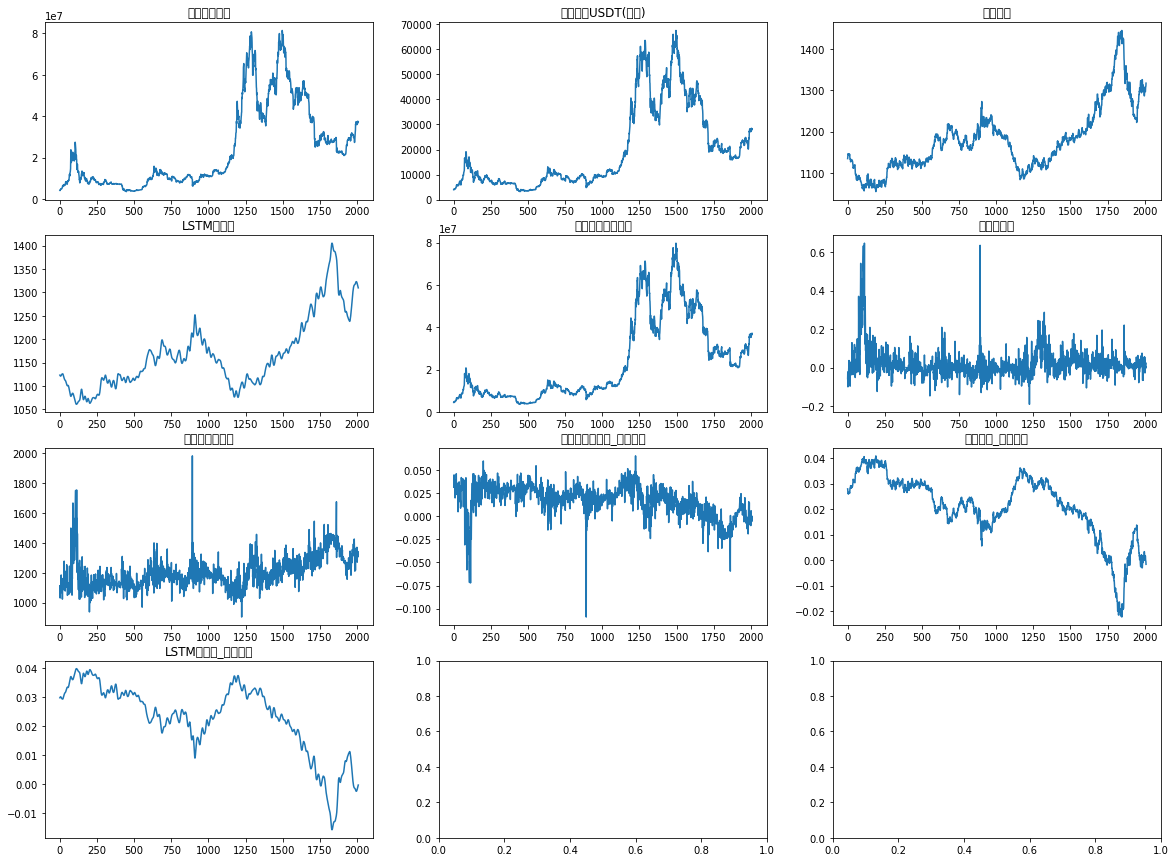

In [9]:
# # 데이터 프레임 내 데이터 시각화
import math #math 모듈을 먼저 import해야 한다.    
import matplotlib.pyplot as plt
# import seaborn as sns

    # 데이터 프레임 모든 컬럼 그리기
    # 함수명으로도 정의하기
def columns_plot(data): # y좌표
    
#     col_list_plt = list(data.select_dtypes(exclude = "object").columns)
    col_list_plt = list(data.select_dtypes(include = ["float","int"]).columns)
    x_plt_n = 3 # 한번에 그릴 plt x 축 수
    y_plt_n = int(len(col_list_plt)/x_plt_n) # 한번에 그릴 plt y 축 수# 한번에 그릴 plt y 축 수
    w_space = 0.2 # float("0."+str(x_plt_n)
    h_space = 0.2 # float("0."+str(y_plt_n)
    
    if (x_plt_n < math.ceil(len(col_list_plt) / y_plt_n)):
        x_plt_n = math.ceil(len(col_list_plt) / y_plt_n)

    #plot 이쁘게 
    f, axes = plt.subplots(x_plt_n, y_plt_n)
    f.set_size_inches((20, 15))
    plt.subplots_adjust(wspace = w_space, hspace = h_space)

    for i in range(len(col_list_plt)):

        bb = math.ceil(((i )// y_plt_n))
        axes[bb][i - math.ceil(((i )// y_plt_n)) * y_plt_n].plot(data[col_list_plt[i]],label = col_list_plt[i] )#, color = 'blue', marker = 'o')
        axes[bb][i - math.ceil(((i )// y_plt_n)) * y_plt_n].set_title(col_list_plt[i])
    plt.rc('font', family='Malgun Gothic')
    plt.show()
    



# for i in range(len(key_list)):
#     print(key_list[i])
#     columns_plot(All_data[key_list[i]])

columns_plot(data)

## 통계적 연관성 분석

In [10]:
import matplotlib
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
 


In [11]:
df = data.copy()

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

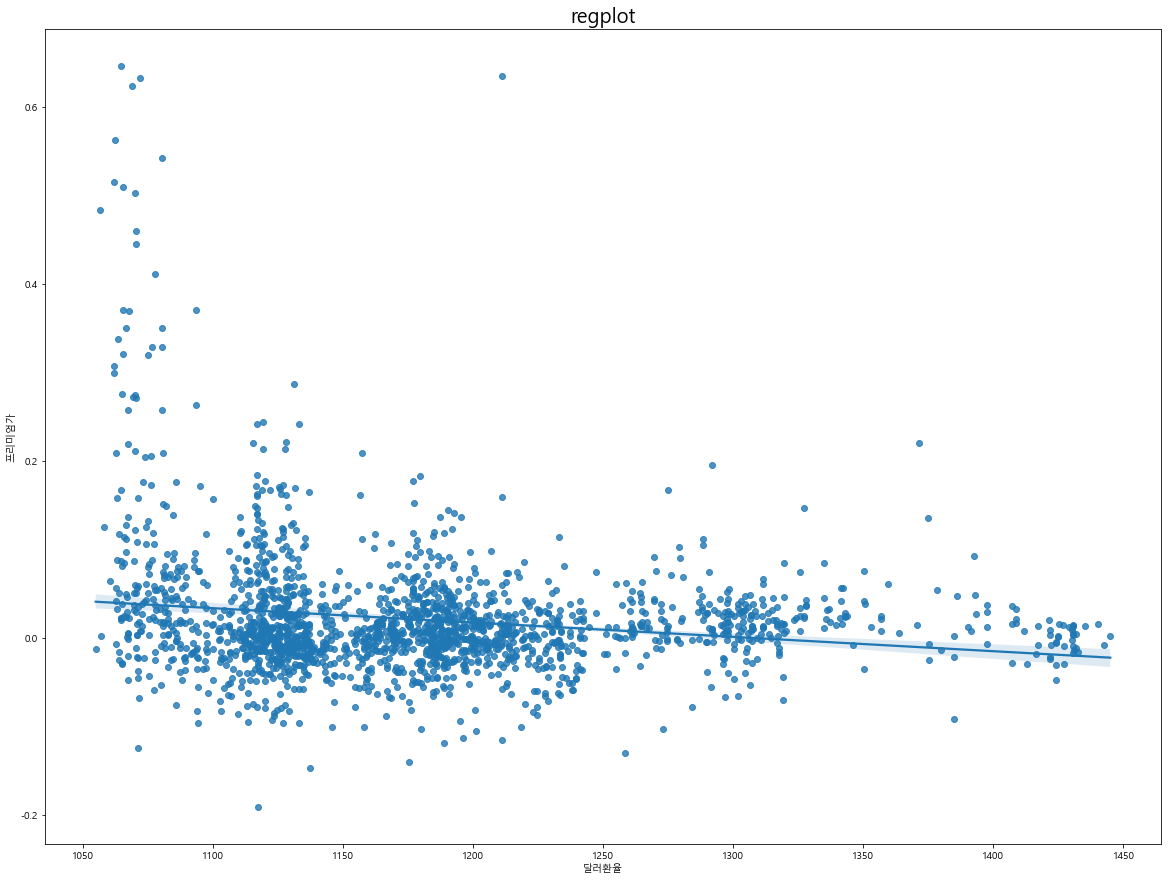

In [13]:
plt.figure(figsize=(20, 15))
plt.title('regplot', fontsize=20)
sns.regplot(x = '달러환율', y = '프리미엄가', data = df) # 단순 선형회귀 리그레션값을 바로 보여줌.
plt.show()

In [14]:
 
from statsmodels.formula.api import ols
fit = ols('프리미엄가 ~ 달러환율',data=df).fit() ## 단순선형회귀모형 적합
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  프리미엄가   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     66.96
Date:                Tue, 16 May 2023   Prob (F-statistic):           4.86e-16
Time:                        18:46:51   Log-Likelihood:                 2501.9
No. Observations:                2010   AIC:                            -5000.
Df Residuals:                    2008   BIC:                            -4989.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2118      0.023      9.060      0.000       0.166       0.258
달러환율          -0.0002   1.98e-05     -8.183      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     1521.286   Durbin-Watson:                   0.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38760.069
Skew:                           3.329   Prob(JB):                         0.00
Kurtosis:                      23.457   Cond. No.                     1.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
 
from statsmodels.formula.api import ols
fit = ols('프리미엄가 ~ 달러환율 -1',data=df).fit() ## 단순선형회귀모형 적합
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  프리미엄가   R-squared (uncentered):                   0.074
Model:                            OLS   Adj. R-squared (uncentered):              0.073
Method:                 Least Squares   F-statistic:                              159.5
Date:                Tue, 16 May 2023   Prob (F-statistic):                    3.04e-35
Time:                        18:47:08   Log-Likelihood:                          2461.7
No. Observations:                2010   AIC:                                     -4921.
Df Residuals:                    2009   BIC:                                     -4916.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
달러환율        1.697e-05   1.34e-06     12.630      0.000    1.43e-05    1.96e-05
==============================================================================
Omnibus:                     1604.373   Durbin-Watson:                   0.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43981.910
Skew:                           3.584   Prob(JB):                         0.00
Kurtosis:                      24.766   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
## 회귀 계수
print(fit.params.Intercept) ## 절편
print(fit.params.달러환율) ## 기울기


AttributeError: 'Series' object has no attribute 'Intercept'

In [ ]:
프리미엄 = -0.21180211963833073 x 환율 + 0.00016202131768171181

In [17]:



# sns.clustermap(data.corr(), 
#                annot = True,      # 실제 값 화면에 나타내기
#                cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
#                vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
#               )
df1 = data.corr()


C:\Users\Happy\AppData\Local\Temp\ipykernel_12136\2298274325.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df1 = data.corr()


In [18]:
drop_name = ["재측정달러가치"]

In [19]:
df1.loc[["달러환율"],["프리미엄가"]]

,프리미엄가
달러환율,-0.179639


C:\Users\Happy\AppData\Local\Temp\ipykernel_12136\291031676.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df1, dtype=np.bool)


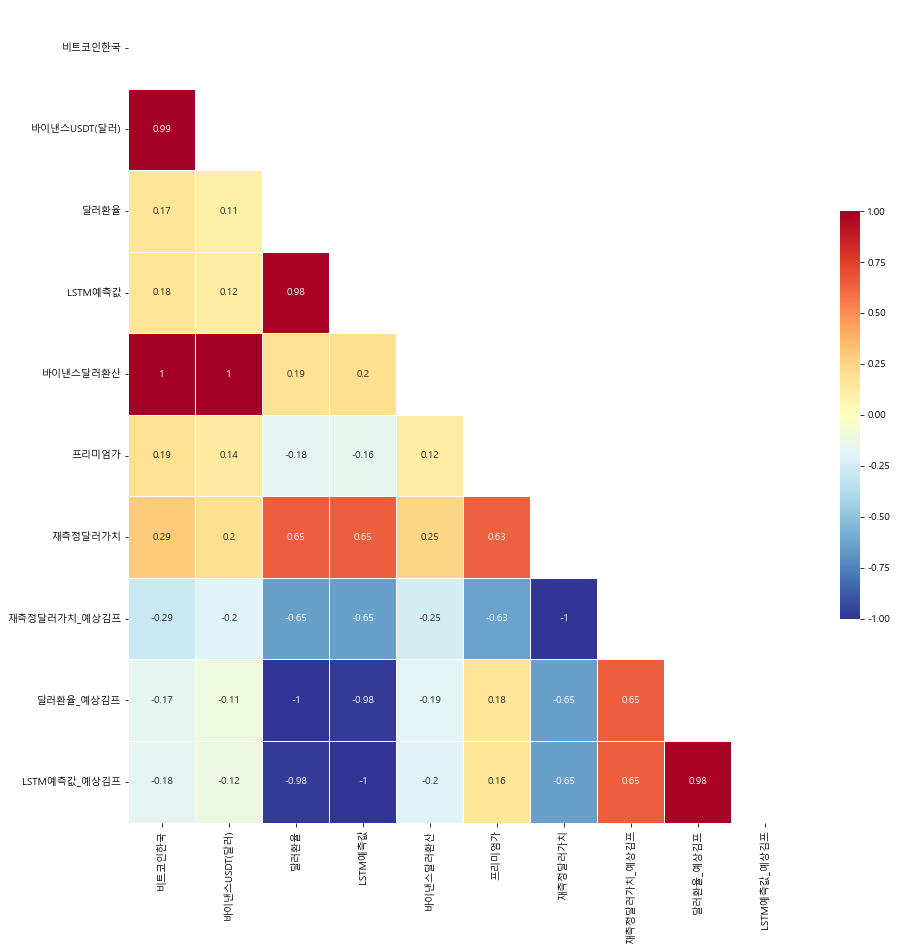

In [20]:
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(15,15) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df1, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## 수익율 측정

In [21]:
import pandas as pd

In [22]:
data = pd.read_csv("data.csv",encoding = "utf-8")
# del data["Unnamed: 0"]

In [23]:
# 9시인것을 다 뺴버려서 다시 맞추어줌.
# data["날짜_2"] = [str(data["날짜"][i])[:]+" 09:00" for i in range(len(data["날짜"]))]

In [4]:


data["날짜_2"] = pd.to_datetime(data['날짜_2'], format='%Y-%m-%d %H:%M', errors='raise')

# 서버 점검일 or 비트코인 전송 불가일
up_sutdown = [("2018-04-16 20:00", "2018-04-17 00:00"),
            ("2018-04-24 07:59", "2018-04-24 08:30"),
            ("2018-06-15 04:00", "2018-06-15 05:00"),
            ("2018-08-22 02:00", "2018-08-22 07:00"),
            ("2018-10-18 02:00", "2018-10-18 03:00"),
            ("2018-12-05 03:00", "2018-12-05 04:00"),
            ("2018-12-12 03:00", "2018-12-12 04:00"),
            ("2019-01-01 01:00", "2019-01-01 03:00"),
            ("2019-03-20 02:00", "2019-03-20 06:00"),
            ("2019-03-24 03:00", "2019-03-24 04:00"),
            ("2020-01-31 02:00", "2020-01-31 05:00"),
            ("2021-01-07 05:00", "2021-01-07 06:00"),
            ("2021-03-03 03:30", "2021-03-03 06:30"),
            ("2021-03-14 03:00", "2021-03-14 06:00"),
            ("2021-03-23 03:00", "2021-03-23 06:00"),
            ("2021-06-30 23:00", "2021-07-01 03:00"),
            ("2019-10-17 21:00", "2019-10-18 13:00"),
            ("2019-04-10 21:50", "2019-04-17 02:00"),
            ("2019-12-12 23:55", "2019-12-13 03:00"),
            ("2019-12-15 00:00", "2019-12-15 01:00"),
            ("2020-12-29 01:30", "2020-12-29 02:25"),
            ("2020-12-30 19:01", "2021-01-01 05:02"),
            ("2021-06-29 21:01", "2021-07-01 04:51"),
            ("2021-08-17 02:00" , "2021-08-17 06:00") ,
            ("2021-08-26 03:00" , "2021-08-26 05:00") ,
            ("2021-09-30 05:50" , "2021-09-30 06:50") ,
            ("2021-10-05 23:30" , "2021-10-06 00:30") ,
            ("2021-10-12 23:00" , "2021-10-13 02:00") ,
            ("2021-10-19 23:00" , "2021-10-20 02:00") ,
            ("2021-11-15 03:00" , "2021-11-15 06:00") ,
            ("2021-10-19 23:30" , "2021-10-20 00:30") ,
            ("2021-11-15 03:00" , "2021-11-15 06:00") ,
            ("2022-01-01 07:00" , "2022-01-01 05:52") ,
            ("2022-02-14 04:46" , "2022-02-14 04:45") ,
            ("2022-05-11 02:00" , "2022-05-11 05:00") ,
            ("2022-05-24 02:00" , "2022-05-24 04:00") ,
            ("2022-10-01 04:25" , "2022-10-01 05:50") ,
            ("2022-10-15 23:50" , "2022-10-16 01:00") ,
            ("2022-12-31 20:00" , "2023-01-01 07:00") ,
            ("2023-02-22 02:00" , "2023-02-22 06:00") ,
            ("2023-03-31 23:00" , "2023-04-01 07:00") ,
            ("2023-04-01 05:54" , "2023-04-01 06:00") ,
            ("2023-04-03 17:55" , "2023-04-03 17:18") ,
            ("2001-01-02" , "2018-04-10") # trian 기간 제외
#             ("2022-07-19" , "2023-04-09") # LSTM데이터 셋과 타임테이블 맞춤
             ]
# 서버 점검일이 아닌 날짜만 받기
for i in range(len(up_sutdown)):
    data = data.loc[~(data["날짜_2"].between(up_sutdown[i][0],up_sutdown[i][1]))]


In [5]:
Measure_Usdt =  1

seed = 1000000
up_fee = 0.0005
bin_fee = 0.0001
send_fee = 0.0009

up_to_bin_pre = 0.01
bin_to_up_pre = 0.15


data["바이낸스달러환산"] = data["달러환율"] * data["바이낸스USDT(달러)"]
data["프리미엄가"] = ( data["비트코인한국"] / data["바이낸스달러환산"] - 1)
data["재측정달러가치"] = ((Measure_Usdt / data['바이낸스USDT(달러)']) *data['비트코인한국']) / Measure_Usdt


info = {"state": False, "enter_price": 0, "enter_time": None, "exit_price": 0, "ror": 1, "fiat_money": seed}
info_dataFrame = pd.DataFrame(info, index=[0])

data = data.reset_index(drop = True)

In [11]:
# 기간에 따른 수익율 재측정.
data = data.loc[(data["날짜"].between("2020-01-01","2024-01-01"))].reset_index(drop = True) # 위에서 정의됨
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율,날짜_2,LSTM예측값,바이낸스달러환산,프리미엄가,재측정달러가치,재측정달러가치_예상김프,달러환율_예상김프,LSTM예측값_예상김프
0,2020-01-01,8343000.0,7195.24,1155.07,2020-01-01 09:00:00,1149.394287,8.311006e+06,-0.003850,1159.516569,-0.023936,-0.024656,-0.025576
1,2020-01-02,8308000.0,7200.77,1155.02,2020-01-02 09:00:00,1148.802368,8.317033e+06,0.001086,1153.765500,-0.024868,-0.024664,-0.025672
2,2020-01-03,8300000.0,6965.49,1157.94,2020-01-03 09:00:00,1148.537598,8.065619e+06,-0.029059,1191.588819,-0.018739,-0.024191,-0.025715
3,2020-01-04,8038000.0,7345.00,1157.94,2020-01-04 09:00:00,1148.624756,8.505069e+06,0.054917,1094.349898,-0.034494,-0.024191,-0.025700
4,2020-01-05,8476000.0,7354.19,1157.94,2020-01-05 09:00:00,1148.914673,8.515711e+06,0.004663,1152.540253,-0.025066,-0.024191,-0.025653
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,2023-04-02,37540000.0,28452.74,1296.97,2023-04-02 09:00:00,1314.534912,3.690235e+07,-0.017279,1319.380840,0.001966,-0.001665,0.001181
1186,2023-04-03,37596000.0,28171.87,1306.47,2023-04-03 09:00:00,1313.118896,3.680570e+07,-0.021472,1334.522699,0.004419,-0.000126,0.000951
1187,2023-04-04,37296000.0,27800.00,1308.76,2023-04-04 09:00:00,1311.787964,3.638353e+07,-0.025079,1341.582734,0.005563,0.000245,0.000735
1188,2023-04-05,36814000.0,28165.47,1310.54,2023-04-05 09:00:00,1310.544189,3.691198e+07,0.002654,1307.061448,-0.000030,0.000533,0.000534


In [12]:
# # 용어정리
# # 프리미엄가 == 김프 
# # 예상김프 == 단순선형회귀 예측 김프
# i = 0
# data["달러환율"][i] , data["재측정달러가치"][i],data["재측정달러가치_예상김프"][i] , data["달러환율_예상김프"][i] , data["프리미엄가"][i] 
# if (info['state'] == False) and (data["프리미엄가"][i] > data["달러환율_예상김프"][i]):
# if (info['state'] == False) and (data["프리미엄가"][i] > data["재측정달러가치_예상김프"][i]):

In [13]:
info

{'state': True,
 'enter_price': 36814000.0,
 'enter_time': '2023-04-05',
 'exit_price': 28165.47,
 'ror': 1.0489653201009697,
 'fiat_money': 1857204997536.2993,
 '비공식환율': 1307.061447936072,
 'seed_fiat': 1420048565.5816863,
 'seed_krw': 1861030447137.423,
 '바이낸스USDT': 28165.47,
 '비트코인KRW': 36814000.0,
 '달러환율': 1310.54,
 '김치프리미엄': 0.0026542891204602848,
 '선형회귀예상김프': 0.0005332980362598,
 'LSTM달러_예측값_예상김프': 0.0005339768169755}

In [14]:
def fun_cheak_ror(data,seed,info_dataFrame,info):
    a = 1

    for i in range(len(data)):
        seed1 = seed

        if (info['state'] == False) and (data["프리미엄가"][i] > data["달러환율_예상김프"][i]): # 4709
#         if ((data["LSTM예측값_예상김프"][i] - data["프리미엄가"][i])<0) and (info['state'] == False): # 4535
#         if (info['state'] == False) and (data["프리미엄가"][i] > data["재측정달러가치_예상김프"][i]): # 4932


#         현재 내 시드(원화/달러가치)가 전송 후 판매까지 완료한 달러가치보다 큰경우 => 내가 외국 거래소에서 환전 받을때 더 수익을 보는 경우.
#         if (float(seed / data['달러환율'][i]) <= (float((info["fiat_money"] / data['비트코인한국'][i] * (1 - up_fee)- send_fee) * data['바이낸스USDT(달러)'][i] * (1 - bin_fee) ))) and (info['state'] == False): # ror 565
        # 김프가 # 현재 내 시드(원화/달러가치)가 전송 후 판매까지 완료한 달러가치보다 큰경우
        # if (data["프리미엄가"][i] < up_to_bin_pre) and ((float(seed / data['달러환율'][i]) <= (float((info["fiat_money"] / data['비트코인한국'][i] * (1 - up_fee)- send_fee) * data['바이낸스USDT(달러)'][i] * (1 - bin_fee) ))) and (info['state'] == False)):

        # if ((data['프리미엄가'][i]) <= up_to_bin_pre) and (info['state'] == False):  # 프리미엄이 0보다 작고 포지션이 없다면
#         if ((data['프리미엄가'][i]) <= up_to_bin_pre) and (info['state'] == False) and (data["달러환율"][i] < data["재측정달러가치"][i]):  # 프리미엄이 0보다 작고 포지션이 없다면

#         if (info['state'] == False) and (data["달러환율"][i] > data["재측정달러가치"][i]):  # 환율보다 비공식 환율이 더 큰 경우

#         if (data["달러환율"][i] < data["LSTM예측값"][i]) and (info['state'] == False):
#         if (data["프리미엄가"][i] > data["LSTM예측값_예상김프"][i]) and (info['state'] == False) : # 역프일때 바로진입하지 않고 더 많은 수익을 볼 수 있군
        #         print("if문 통과 포지션 진입",data["프리미엄가"][i] , data["LSTM예측값_예상김프"][i])
            info["state"] = True  # 바이낸스로 차익봄
            info["enter_price"] = data['비트코인한국'][i]
            info["enter_time"] = data['날짜'][i]
            info["exit_price"] = data['바이낸스USDT(달러)'][i]
            info["비공식환율"] = data['재측정달러가치'][i]

            seed_usdt = float((info["fiat_money"] / data['비트코인한국'][i] * (1 - up_fee) - send_fee) * data['바이낸스USDT(달러)'][i] * (1 - bin_fee))  # 달러로 가질돈

            info["seed_fiat"] = seed_usdt
            info["seed_krw"] = seed_usdt * data["달러환율"][i]
            info["바이낸스USDT"] = data['바이낸스USDT(달러)'][i]
            info["비트코인KRW"] =  data['비트코인한국'][i]
            info["달러환율"] = data["달러환율"][i]
            info["김치프리미엄"] = data["프리미엄가"][i]
            info["선형회귀예상김프"] = data["달러환율_예상김프"][i] # = 단순선형회귀 달러에 대고 찍은 프리미엄
            info["LSTM달러_예측값_예상김프"] = data["LSTM예측값_예상김프"][i]

            new_info_dataFrame = pd.DataFrame(info, index=[0])
            info_dataFrame = pd.concat([info_dataFrame, new_info_dataFrame], axis=0)  # 수익 데이터 저장
            a = 0
        #         info["ror"] = None


        #     if (((data['프리미엄가'][i]) >= bin_to_up_pre) and (info['state'] == True)):  # 프리미엄이 0보다 크고 포지션이 없다면
        elif  (a != 1) and((float(seed * (1 + bin_to_up_pre)) < (float(((seed_usdt  / data['바이낸스USDT(달러)'][i]) * (1 - bin_fee) - send_fee) * data['비트코인한국'][i] * (1 - up_fee)))))and (info['state'] == True):
    #         print("if문 통과 포지션 탈출",float(seed * (1 + bin_to_up_pre)) , (float(((seed_usdt  / data['바이낸스USDT(달러)'][i]) * (1 - bin_fee) - send_fee) * data['비트코인한국'][i] * (1 - up_fee))))
            info["state"] = False  # 업비트로 재전송
            info["enter_price"] = data['바이낸스USDT(달러)'][i]
            info["enter_time"] = data['날짜'][i]
            info["exit_price"] = data['비트코인한국'][i]
            info["비공식환율"] = data['재측정달러가치'][i]

            seed = info["fiat_money"] = float(((seed_usdt  / data['바이낸스USDT(달러)'][i]) * (1 - bin_fee) - send_fee) * data['비트코인한국'][i] * (1 - up_fee))
        #         print(info["fiat_money"])
            info["ror"] = seed / seed1

            info["seed_fiat"] = seed
            info["seed_krw"] = seed
            info["바이낸스USDT"] = data['바이낸스USDT(달러)'][i]
            info["비트코인KRW"] =  data['비트코인한국'][i]
            info["달러환율"] = data["달러환율"][i]
            info["김치프리미엄"] = data["프리미엄가"][i]
            info["선형회귀예상김프"] = data["달러환율_예상김프"][i] # = 단순선형회귀 달러에 대고 찍은 프리미엄

            new_info_dataFrame = pd.DataFrame(info, index=[0])
            info_dataFrame = pd.concat([info_dataFrame, new_info_dataFrame], axis=0)  # 수익 데이터 저장

    return info_dataFrame

In [15]:
# data = data.loc[~(abs(data["프리미엄가"])>0.1)].reset_index(drop = True)
a = 1
seed = 1000000
bin_to_up_pre = 0.01
info = {"state": False, "enter_price": 0, "enter_time": None, "exit_price": 0, "ror": 1, "fiat_money": seed, "비공식환율" : 0}
info_dataFrame = pd.DataFrame(info, index=[0])
info_dataFrame_ror = fun_cheak_ror(data,seed,info_dataFrame,info)

info_dataFrame = info_dataFrame_ror.reset_index(drop = True)
print("ror : ",(info_dataFrame["fiat_money"][len(info_dataFrame)-1])/(info_dataFrame["fiat_money"][0]))
info_dataFrame

ror :  4709.854503706371


,state,enter_price,enter_time,exit_price,ror,fiat_money,비공식환율,seed_fiat,seed_krw,바이낸스USDT,비트코인KRW,달러환율,김치프리미엄,선형회귀예상김프,LSTM달러_예측값_예상김프
0,False,0.00,None,0.00,1.000000,1.000000e+06,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,8343000.00,2020-01-01,7195.24,1.000000,1.000000e+06,1159.516569,8.554359e+02,9.880883e+05,7195.24,8343000.0,1155.07,-0.003850,-0.024656,-0.025576
2,False,6965.49,2020-01-03,8300000.00,1.011250,1.011250e+06,1191.588819,1.011250e+06,1.011250e+06,6965.49,8300000.0,1157.94,-0.029059,-0.024191,-0.025576
3,True,8038000.00,2020-01-04,7345.00,1.011250,1.011250e+06,1094.349898,9.169004e+02,1.061716e+06,7345.00,8038000.0,1157.94,0.054917,-0.024191,-0.025700
4,False,7354.19,2020-01-05,8476000.00,1.036842,1.048506e+06,1152.540253,1.048506e+06,1.048506e+06,7354.19,8476000.0,1157.94,0.004663,-0.024191,-0.025700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,True,36372000.00,2023-03-24,28295.42,1.049385,4.257045e+09,1285.437714,3.309735e+06,4.258537e+09,28295.42,36372000.0,1286.67,0.000958,-0.003334,0.002569
376,False,27454.46,2023-03-25,37268000.00,1.054737,4.490065e+09,1357.447934,4.490065e+09,4.490065e+09,27454.46,37268000.0,1286.67,-0.055009,-0.003334,0.002569
377,True,36020000.00,2023-03-30,28348.60,1.054737,4.490065e+09,1270.609483,3.531642e+06,4.616316e+09,28348.60,36020000.0,1307.13,0.027939,-0.000019,0.001842
378,False,28028.53,2023-03-31,37402000.00,1.048950,4.709855e+09,1334.426029,4.709855e+09,4.709855e+09,28028.53,37402000.0,1296.97,-0.028880,-0.001665,0.001842


In [107]:
data.loc[data["날짜"]=="2020-01-01"]

,날짜,비트코인한국,바이낸스USDT(달러),달러환율,날짜_2,LSTM예측값,바이낸스달러환산,프리미엄가,재측정달러가치,재측정달러가치_예상김프,달러환율_예상김프,LSTM예측값_예상김프
624,2020-01-01,8343000.0,7195.24,1155.07,2020-01-01 09:00:00,1149.394287,8.311006e+06,-0.00385,1159.516569,-0.023936,-0.024656,-0.025576


In [108]:
# info_dataFrame.loc[info_dataFrame["ror"]>1.1]

In [109]:
info_dataFrame

,state,enter_price,enter_time,exit_price,ror,fiat_money,비공식환율,seed_fiat,seed_krw,바이낸스USDT,비트코인KRW,달러환율,김치프리미엄,선형회귀예상김프,LSTM달러_예측값_예상김프
0,False,0.00,None,0.00,1.000000,1.000000e+06,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,7449000.00,2018-04-11,6839.56,1.000000,1.000000e+06,1089.105147,9.114791e+02,9.705521e+05,6839.56,7449000.0,1064.81,-0.022816,-0.039280,-0.038968
2,False,8869.99,2018-04-26,10505000.00,1.069395,1.069395e+06,1184.330535,1.069395e+06,1.069395e+06,8869.99,10505000.0,1082.34,-0.094232,-0.036440,-0.038968
3,True,9829000.00,2018-04-27,9267.03,1.069395,1.069395e+06,1060.641867,9.993084e+02,1.076945e+06,9267.03,9829000.0,1077.69,0.015819,-0.037193,-0.038618
4,False,8915.35,2018-04-28,10130000.00,1.052617,1.125663e+06,1136.242548,1.125663e+06,1.125663e+06,8915.35,10130000.0,1077.69,-0.054332,-0.037193,-0.038618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,True,36372000.00,2023-03-24,28295.42,1.049401,1.678602e+12,1285.437714,1.305077e+09,1.679204e+12,28295.42,36372000.0,1286.67,0.000958,-0.003334,0.002569
652,False,27454.46,2023-03-25,37268000.00,1.054753,1.770511e+12,1357.447934,1.770511e+12,1.770511e+12,27454.46,37268000.0,1286.67,-0.055009,-0.003334,0.002569
653,True,36020000.00,2023-03-30,28348.60,1.054753,1.770511e+12,1270.609483,1.392599e+09,1.820308e+12,28348.60,36020000.0,1307.13,0.027939,-0.000019,0.001842
654,False,28028.53,2023-03-31,37402000.00,1.048965,1.857205e+12,1334.426029,1.857205e+12,1.857205e+12,28028.53,37402000.0,1296.97,-0.028880,-0.001665,0.001842


In [110]:
info_dataFrame.to_csv("info_dataFrame.csv",index = False,encoding = "cp949")

In [111]:
import matplotlib.pyplot as plt

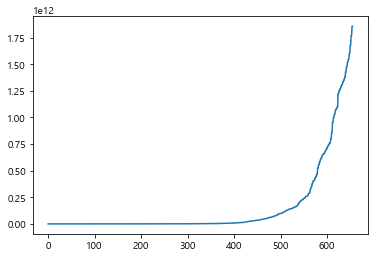

In [112]:
plt.plot(info_dataFrame["fiat_money"])

([<matplotlib.lines.Line2D at 0x1aa6e914160>], 1.0458935275533332, 656)

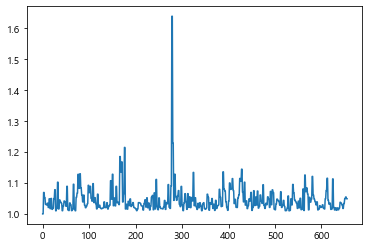

In [113]:
plt.plot(info_dataFrame["ror"]), info_dataFrame["ror"].mean(), len(info_dataFrame) #, sum( info_dataFrame["ror"]) / len(data)/30

In [114]:
import datetime
info_dataFrame['enter_time'] = pd.to_datetime(info_dataFrame['enter_time'], format='%Y-%m-%d', errors='raise')

In [115]:
df1 = info_dataFrame[["ror","enter_time","state","seed_krw"]]

In [116]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [117]:
target_date = '2020-02-10'

month_before = (datetime.strptime(target_date, '%Y-%m-%d') + relativedelta(months = 1)).strftime('%Y-%m-%d')

In [118]:
# info = {"state": False, "enter_price": 0, "enter_time": None, "exit_price": 0, "ror": 1, "fiat_money": seed, "비공식환율" : 0}
# info_dataFrame = pd.DataFrame(info, index=[0])

# new_info_dataFrame = pd.DataFrame(info, index=[0])
# info_dataFrame = pd.concat([info_dataFrame, new_info_dataFrame], axis=0)  # 수익 데이터 저장

In [119]:
ror = {"time":df1.iloc[0].enter_time,"ror":0,"거래횟수":0 }
ror_dataFrame = pd.DataFrame(ror, index=[0])
# start_time = df1.iloc[0].enter_time
print("바꿀 시작일",df1.iloc[0].enter_time)
start_time = "2020-01-01"
a = df1.iloc[len(df1["enter_time"])-1].enter_time
while True:
    
    end_time = (datetime.strptime(start_time, '%Y-%m-%d') + relativedelta(months = 1)).strftime('%Y-%m-%d')

    df_2 = df1.loc[df1["enter_time"].between((start_time),end_time)]
    
    try:
        ror["time"] = start_time
        ror["ror"] = df_2.iloc[len(df_2)-1].seed_krw/df_2.iloc[0].seed_krw
        ror["거래횟수"] = len(df_2)
        
        new_ror_dataFrame = pd.DataFrame(ror, index=[0])
        ror_dataFrame = pd.concat([ror_dataFrame, new_ror_dataFrame], axis=0)  # 수익 데이터 저장
        print(end_time,start_time)
    except:
        pass
    
    start_time = (datetime.strptime(start_time, '%Y-%m-%d') + relativedelta(months = 1)).strftime('%Y-%m-%d')
    if datetime.strptime(start_time, '%Y-%m-%d') > a:
        break
ror_dataFrame = ror_dataFrame.reset_index(drop = True)

바꿀 시작일 NaT
2020-02-01 2020-01-01
2020-03-01 2020-02-01
2020-04-01 2020-03-01
2020-05-01 2020-04-01
2020-06-01 2020-05-01
2020-07-01 2020-06-01
2020-09-01 2020-08-01
2020-10-01 2020-09-01
2020-11-01 2020-10-01
2020-12-01 2020-11-01
2021-01-01 2020-12-01
2021-02-01 2021-01-01
2021-03-01 2021-02-01
2021-04-01 2021-03-01
2021-05-01 2021-04-01
2021-06-01 2021-05-01
2021-07-01 2021-06-01
2021-08-01 2021-07-01
2021-09-01 2021-08-01
2021-10-01 2021-09-01
2021-11-01 2021-10-01
2021-12-01 2021-11-01
2022-01-01 2021-12-01
2022-02-01 2022-01-01
2022-03-01 2022-02-01
2022-04-01 2022-03-01
2022-05-01 2022-04-01
2022-06-01 2022-05-01
2022-07-01 2022-06-01
2022-08-01 2022-07-01
2022-09-01 2022-08-01
2022-10-01 2022-09-01
2022-11-01 2022-10-01
2022-12-01 2022-11-01
2023-01-01 2022-12-01
2023-02-01 2023-01-01
2023-03-01 2023-02-01
2023-04-01 2023-03-01
2023-05-01 2023-04-01


In [92]:
ror_dataFrame

,time,ror,거래횟수
0,NaN,0.000000,0
1,2020-01-01,1.064598,5
2,2020-02-01,1.155832,10
3,2020-03-01,2.861077,17
4,2020-04-01,1.326270,16
5,2020-05-01,1.258872,13
6,2020-06-01,1.240135,12
7,2020-08-01,1.185875,17
8,2020-09-01,1.231081,12
9,2020-10-01,0.986666,2


In [93]:
df1.loc[df1["enter_time"].between("2020-10-01","2020-11-01")]

,ror,enter_time,state,seed_krw
100,1.015817,2020-10-02,False,1.236053e+07
101,1.015817,2020-10-03,True,1.219572e+07


In [94]:
df1.loc[df1["enter_time"].between("2020-11-01","2020-12-01")]

,ror,enter_time,state,seed_krw
102,1.028877,2020-11-27,False,1.271746e+07
103,1.028877,2020-11-28,True,1.251528e+07


In [95]:
df1

,ror,enter_time,state,seed_krw
0,1.000000,NaT,False,NaN
1,1.000000,2020-01-01,True,9.880883e+05
2,1.011250,2020-01-03,False,1.011250e+06
3,1.011250,2020-01-04,True,1.061716e+06
4,1.036842,2020-01-05,False,1.048506e+06
...,...,...,...,...
375,1.049385,2023-03-24,True,4.258537e+09
376,1.054737,2023-03-25,False,4.490065e+09
377,1.054737,2023-03-30,True,4.616316e+09
378,1.048950,2023-03-31,False,4.709855e+09


In [55]:
df1.loc[df1["ror"]<1]

,ror,enter_time,state,seed_krw


In [56]:
info_dataFrame = pd.DataFrame(info, index=[0])

In [57]:
df_2

,ror,enter_time,state,seed_krw
375,1.048951,2023-04-05,True,4.942618e+09


In [58]:
df_2.iloc[len(df_2)-1].seed_krw/df_2.iloc[0].seed_krw

1.0

In [59]:
df_2.seed_krw[1]

KeyError: 1

In [ ]:
df1["year"] = df1["enter_time"].dt.year
df1["month"] = df1["enter_time"].dt.month
df1.groupby(["year","month"]).agg(['sum',"mean"]) # ror 은 sum 하면 안될것 같긴함. 자세히 보기 위해서는 month 별로 정렬해야함.=> 그룹바이 key값가지고 for 문 돌리며 될듯.

In [338]:
dir(info_dataFrame)

['LSTM달러_예측값_예상김프',
 'T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__dataframe__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduc

In [339]:
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율,날짜_2,LSTM예측값,바이낸스달러환산,프리미엄가,재측정달러가치,재측정달러가치_예상김프,달러환율_예상김프,LSTM예측값_예상김프
0,2020-01-01,8343000.0,7195.24,1155.07,2020-01-01 09:00:00,1149.394287,8.311006e+06,-0.003850,1159.516569,-0.023936,-0.024656,-0.025576
1,2020-01-02,8308000.0,7200.77,1155.02,2020-01-02 09:00:00,1148.802368,8.317033e+06,0.001086,1153.765500,-0.024868,-0.024664,-0.025672
2,2020-01-03,8300000.0,6965.49,1157.94,2020-01-03 09:00:00,1148.537598,8.065619e+06,-0.029059,1191.588819,-0.018739,-0.024191,-0.025715
3,2020-01-04,8038000.0,7345.00,1157.94,2020-01-04 09:00:00,1148.624756,8.505069e+06,0.054917,1094.349898,-0.034494,-0.024191,-0.025700
4,2020-01-05,8476000.0,7354.19,1157.94,2020-01-05 09:00:00,1148.914673,8.515711e+06,0.004663,1152.540253,-0.025066,-0.024191,-0.025653
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,2023-04-02,37540000.0,28452.74,1296.97,2023-04-02 09:00:00,1314.534912,3.690235e+07,-0.017279,1319.380840,0.001966,-0.001665,0.001181
1186,2023-04-03,37596000.0,28171.87,1306.47,2023-04-03 09:00:00,1313.118896,3.680570e+07,-0.021472,1334.522699,0.004419,-0.000126,0.000951
1187,2023-04-04,37296000.0,27800.00,1308.76,2023-04-04 09:00:00,1311.787964,3.638353e+07,-0.025079,1341.582734,0.005563,0.000245,0.000735
1188,2023-04-05,36814000.0,28165.47,1310.54,2023-04-05 09:00:00,1310.544189,3.691198e+07,0.002654,1307.061448,-0.000030,0.000533,0.000534


In [340]:
type(start_time),type(end_time)

(str, str)

1051916.9833513754